In [ ]:
"""
Now lets produce some diagnostics for the 20 K data.
""";


In [4]:
"""
The script that does the heavy lifting.
"""

import importlib

import numpy as np

import parsing_utils as utils
import ccd_image as ccd
import cluster

importlib.reload(utils)
importlib.reload(ccd)
importlib.reload(cluster)


clusters_20K = {x: [] for x in utils.ANGLES_20K}
bkg_in_clusters_per_field_20K = [
    np.zeros_like(utils.get_rough_background(utils.SCAN_DIRS_20K[0], True))
    for _ in range(71)
]

for field in range(71):
    for angle in utils.ANGLES_20K:
        print(f"Angle: {angle} deg, field: {field} mT")
        # First subtract the background and add the bkg subbed data to the
        # averaged_total_bkg_subbed_images array.
        tiff = utils.get_tiff_angle_field(angle, field, True)
        bkg = utils.get_rough_background_angle(angle, True)
        img = ccd.CCDImage(tiff, bkg, utils.MASK, utils.METADATA)
        img.subtract_bkg()
        bkg_subbed_data = np.copy(img.data)

        # Now do clustering.
        clusters = img.cluster_significant_pixels(utils.SIGNAL_LENGTH_SCALE,
                                                  utils.BKG_LENGTH_SCALE)

        # Save the clusters, so I don't have to keep redoing this calculation.
        clusters_20K[angle].append(clusters)
        cluster_mask = img.mask_from_clusters(clusters)

        # Only look at bkg_subbed_data that's clustered and significant.
        bkg_in_clusters = bkg_subbed_data * cluster_mask
        bkg_in_clusters_per_field_20K[field] += bkg_in_clusters


Angle: 0 deg, field: 0 mT
Angle: 15 deg, field: 0 mT
Angle: 30 deg, field: 0 mT
Angle: 45 deg, field: 0 mT
Angle: 60 deg, field: 0 mT
Angle: 75 deg, field: 0 mT
Angle: 90 deg, field: 0 mT
Angle: 105 deg, field: 0 mT
Angle: 120 deg, field: 0 mT
Angle: 135 deg, field: 0 mT
Angle: 150 deg, field: 0 mT
Angle: 165 deg, field: 0 mT
Angle: 5 deg, field: 0 mT
Angle: 20 deg, field: 0 mT
Angle: 35 deg, field: 0 mT
Angle: 50 deg, field: 0 mT
Angle: 65 deg, field: 0 mT
Angle: 80 deg, field: 0 mT
Angle: 95 deg, field: 0 mT
Angle: 110 deg, field: 0 mT
Angle: 125 deg, field: 0 mT
Angle: 140 deg, field: 0 mT
Angle: 0 deg, field: 1 mT
Angle: 15 deg, field: 1 mT
Angle: 30 deg, field: 1 mT
Angle: 45 deg, field: 1 mT
Angle: 60 deg, field: 1 mT
Angle: 75 deg, field: 1 mT
Angle: 90 deg, field: 1 mT
Angle: 105 deg, field: 1 mT
Angle: 120 deg, field: 1 mT
Angle: 135 deg, field: 1 mT
Angle: 150 deg, field: 1 mT
Angle: 165 deg, field: 1 mT
Angle: 5 deg, field: 1 mT
Angle: 20 deg, field: 1 mT
Angle: 35 deg, fiel

/Users/richard/Documents/Code/work/i10_experiments/soliton_experiment/ccd_image.py:224: RuntimeWarning: invalid value encountered in true_divide
  return np.abs((local_signal - local_bkg_levels)/total_deviaiton)


Angle: 15 deg, field: 70 mT
Angle: 30 deg, field: 70 mT
Angle: 45 deg, field: 70 mT
Angle: 60 deg, field: 70 mT
Angle: 75 deg, field: 70 mT
Angle: 90 deg, field: 70 mT
Angle: 105 deg, field: 70 mT
Angle: 120 deg, field: 70 mT
Angle: 135 deg, field: 70 mT
Angle: 150 deg, field: 70 mT
Angle: 165 deg, field: 70 mT
Angle: 5 deg, field: 70 mT
Angle: 20 deg, field: 70 mT
Angle: 35 deg, field: 70 mT
Angle: 50 deg, field: 70 mT
Angle: 65 deg, field: 70 mT
Angle: 80 deg, field: 70 mT
Angle: 95 deg, field: 70 mT
Angle: 110 deg, field: 70 mT
Angle: 125 deg, field: 70 mT
Angle: 140 deg, field: 70 mT


/Users/richard/Documents/Code/work/i10_experiments/soliton_experiment/parsing_utils.py:217: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  
/Users/richard/Documents/Code/work/i10_experiments/soliton_experiment/parsing_utils.py:210: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


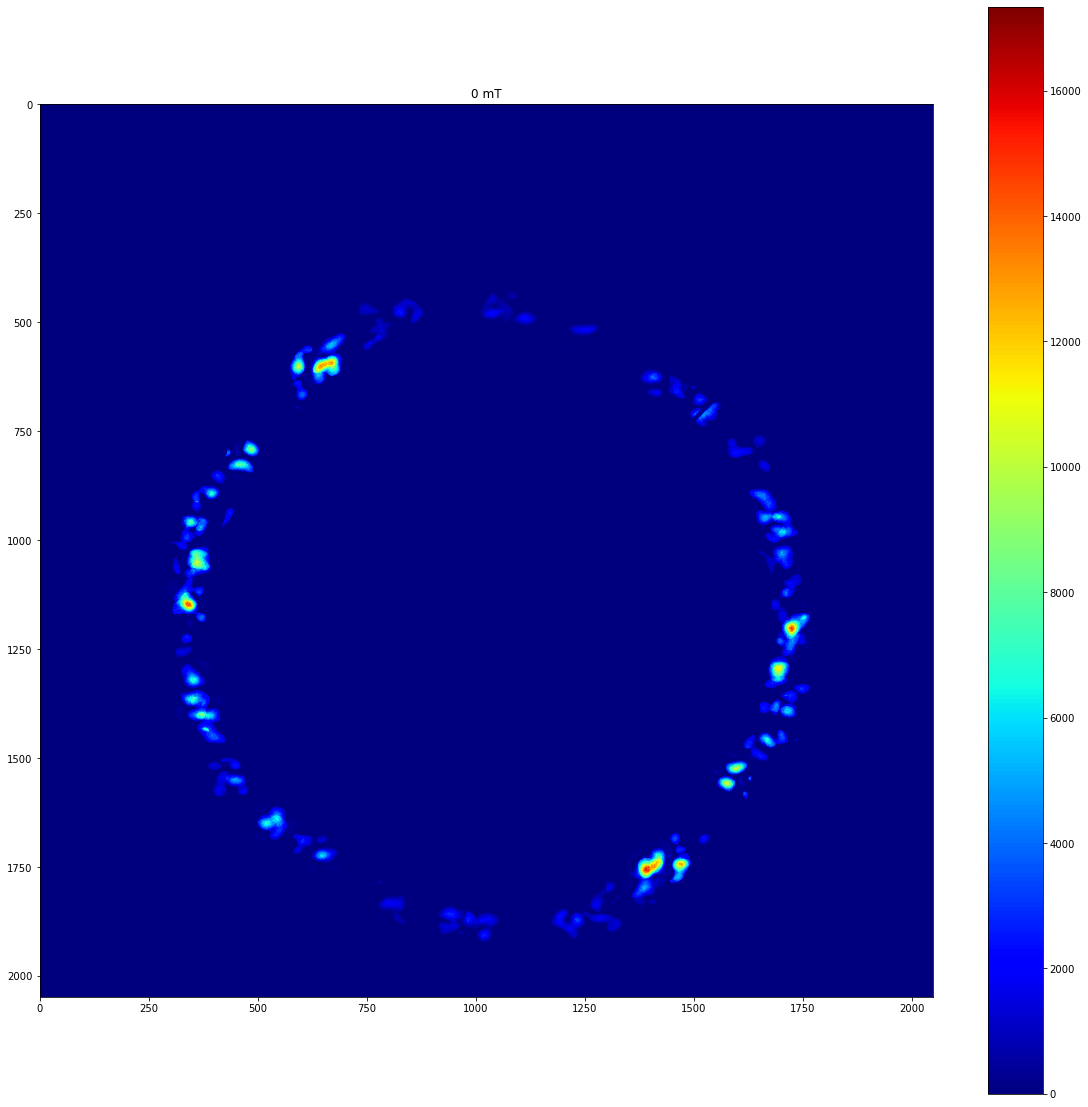

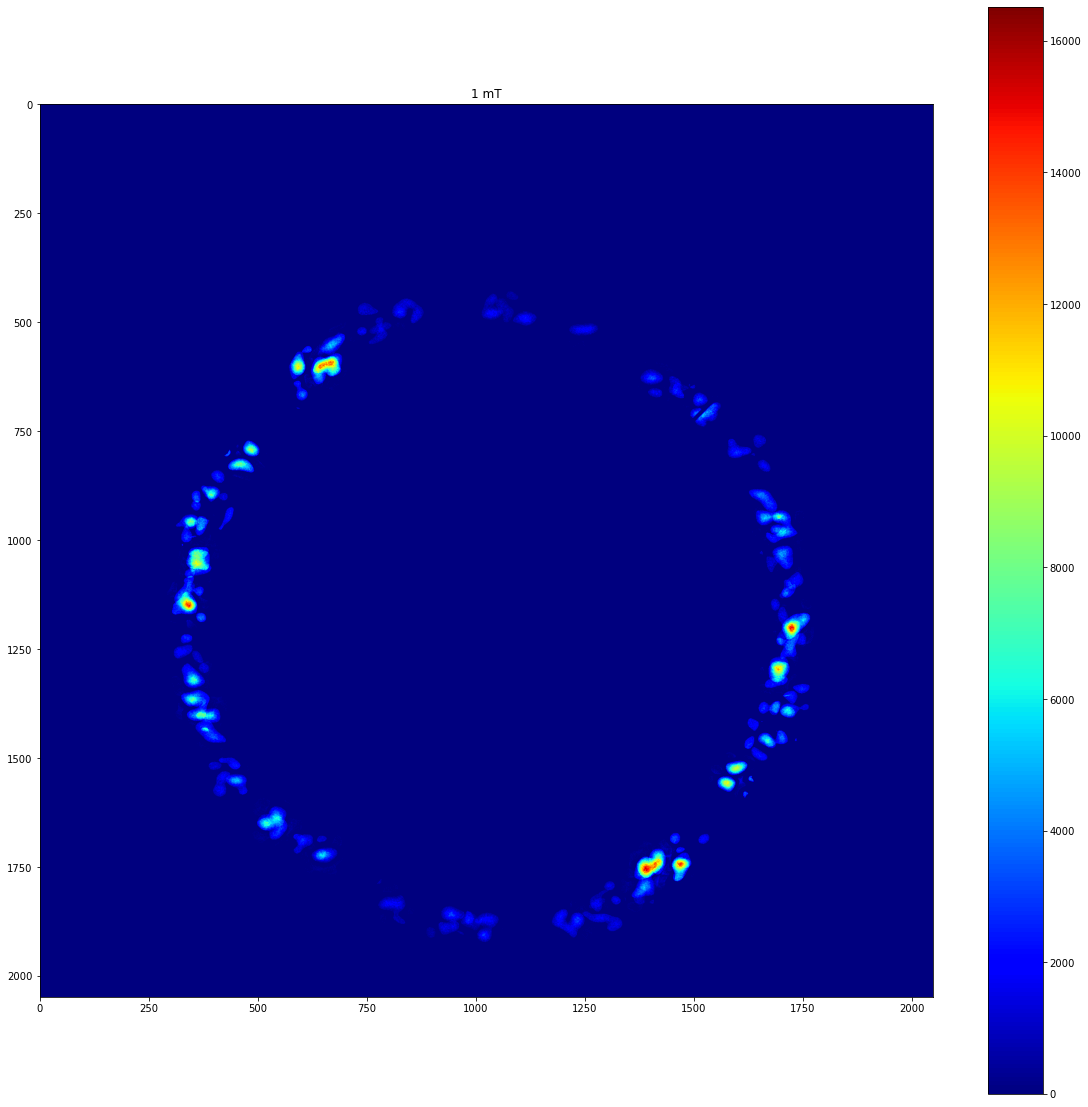

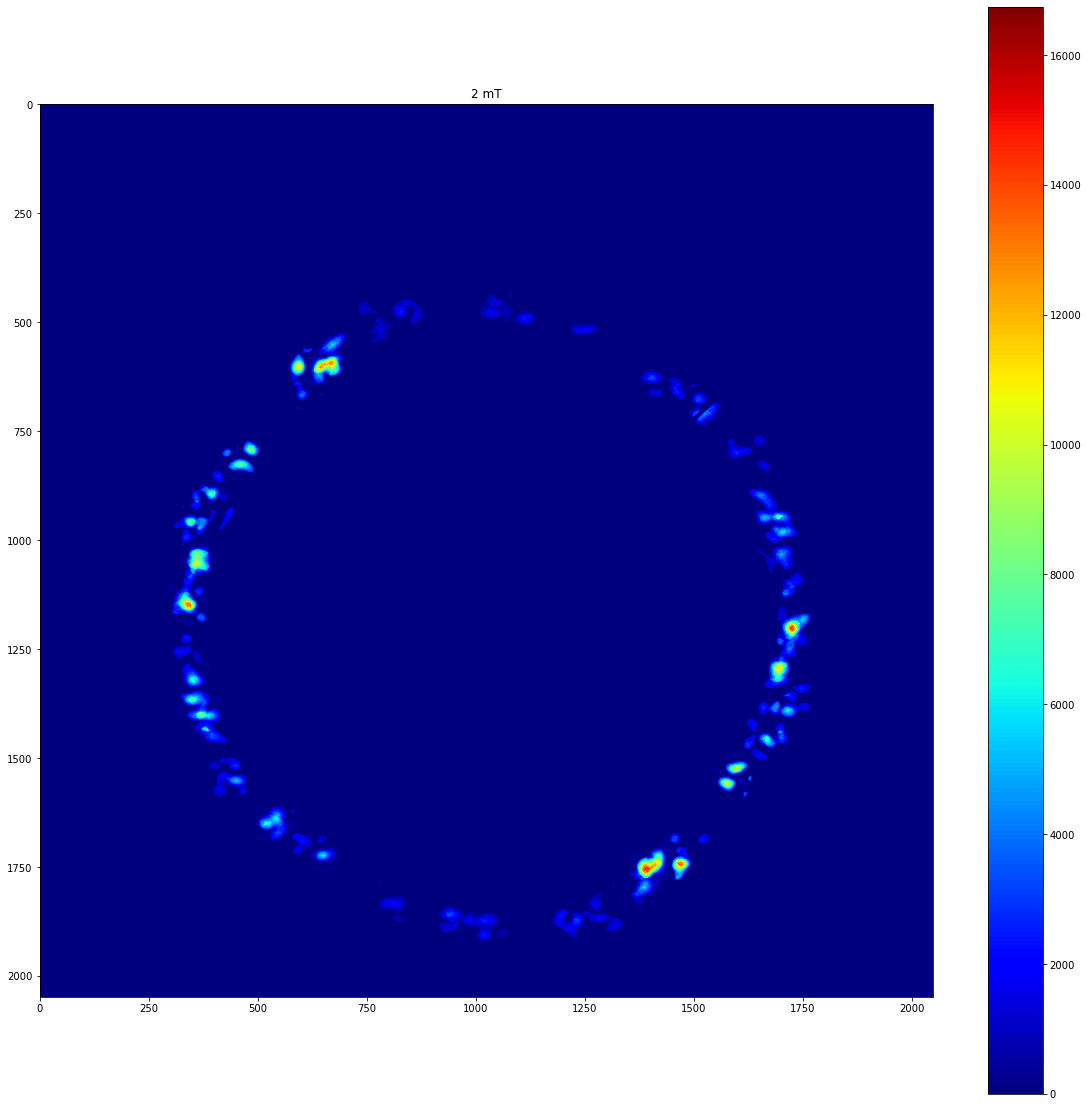

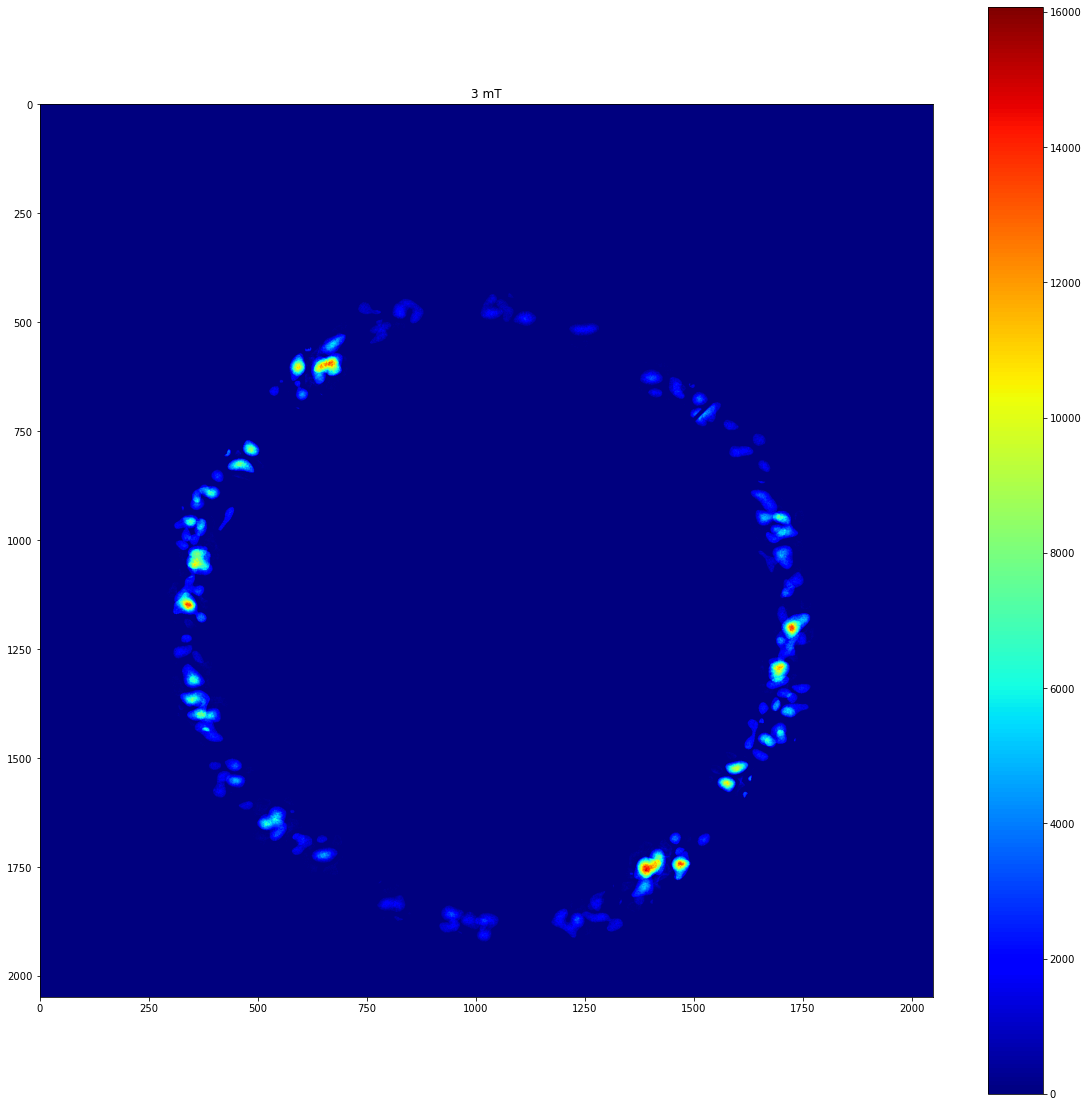

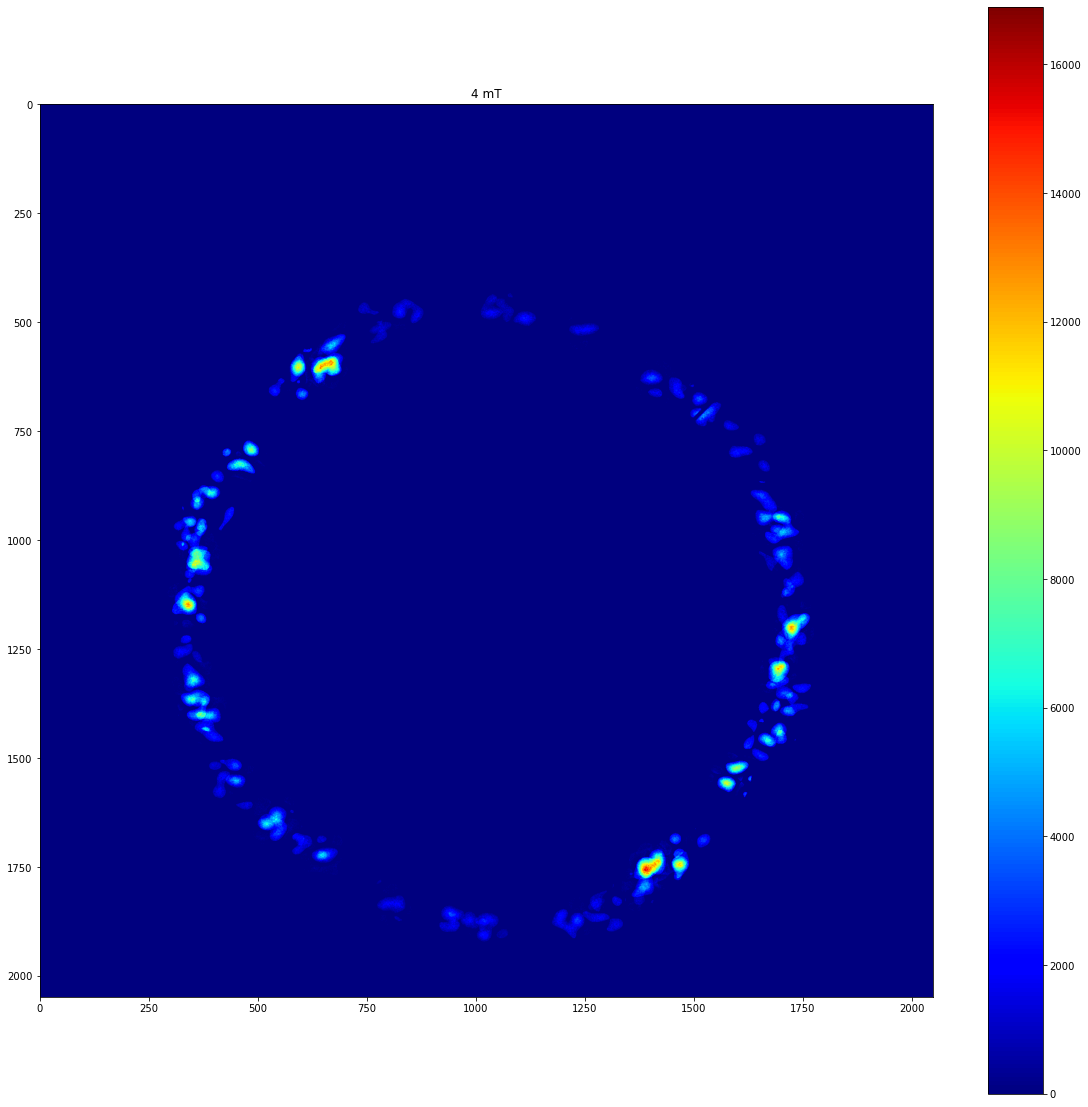

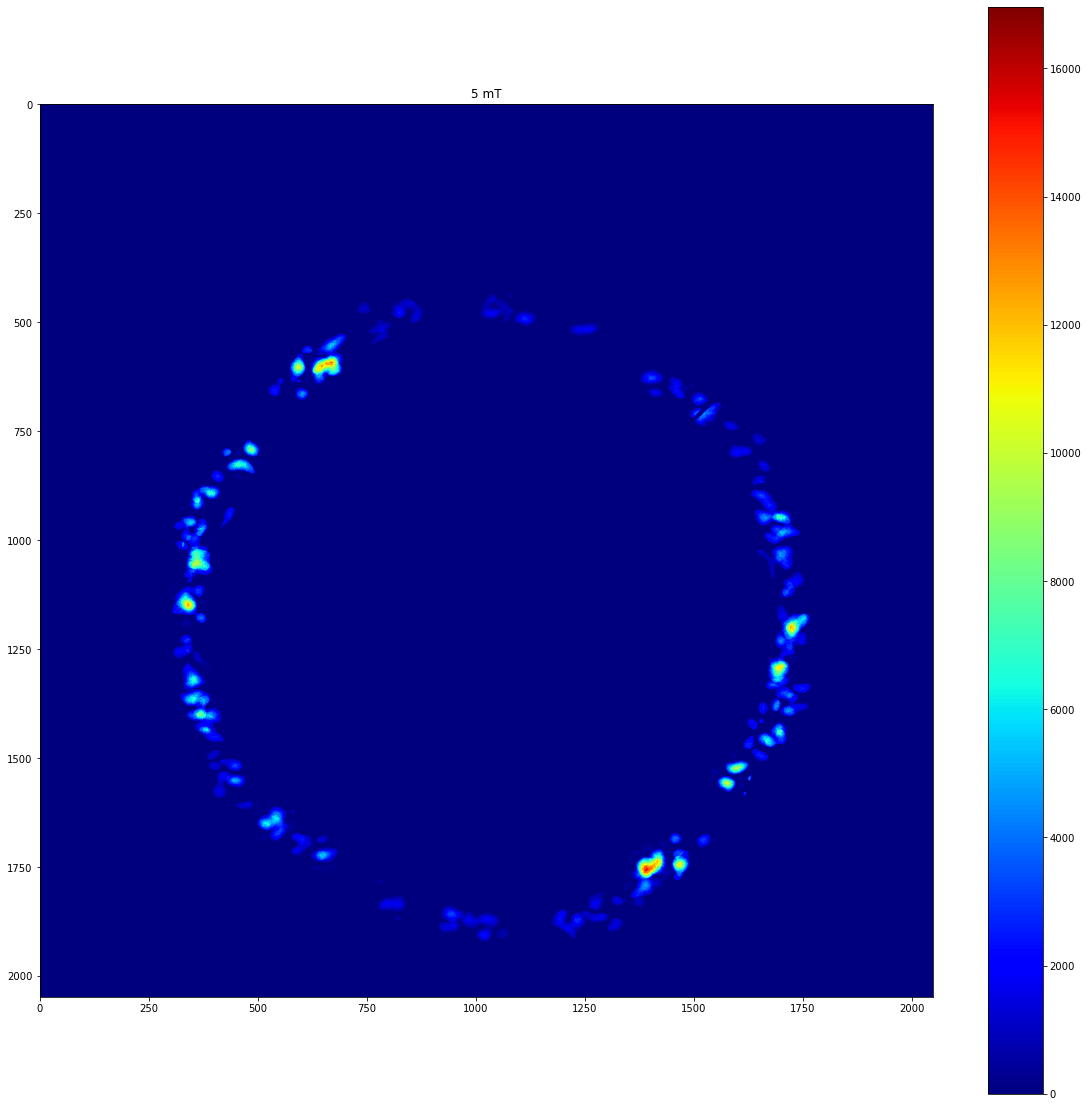

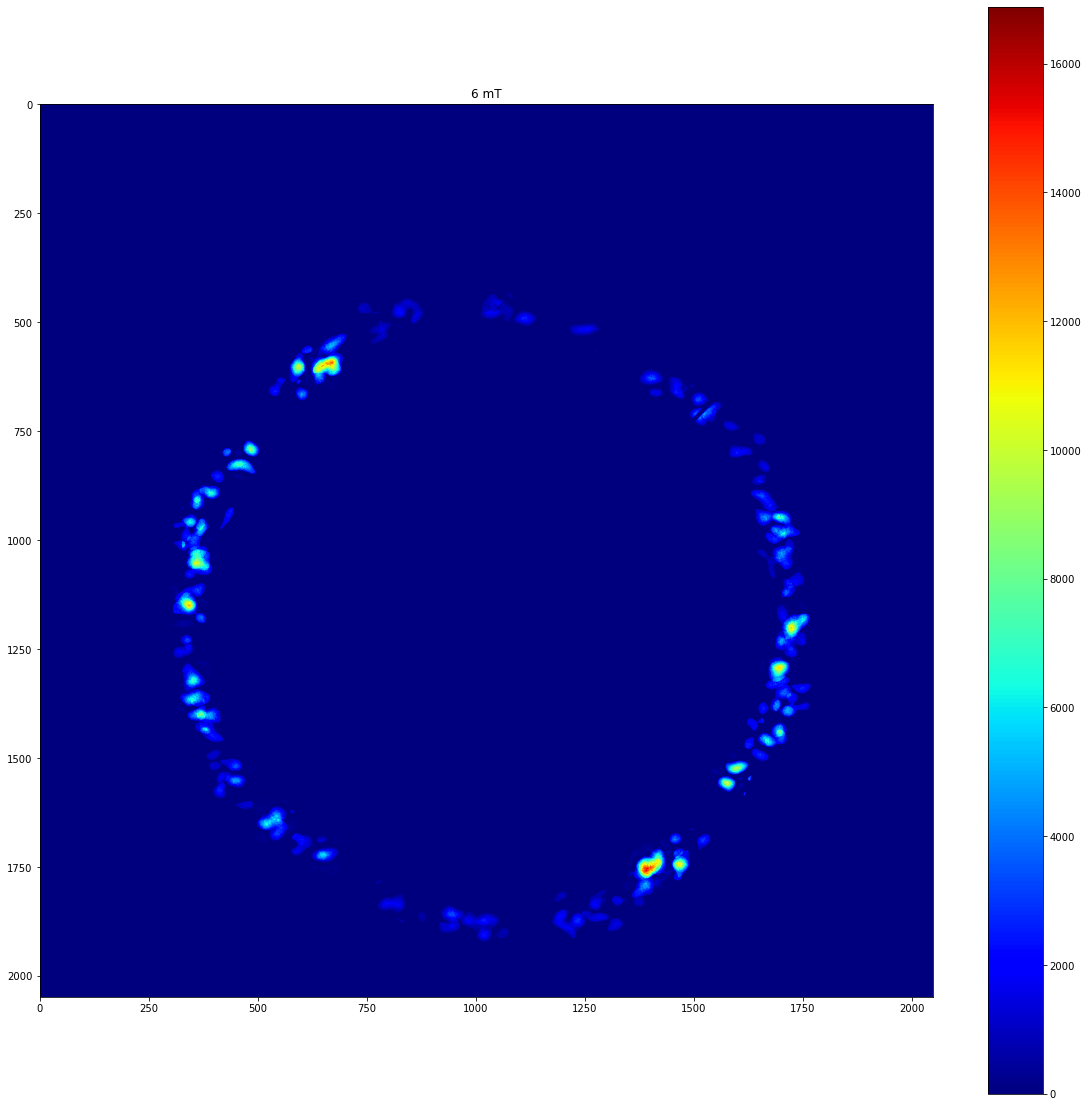

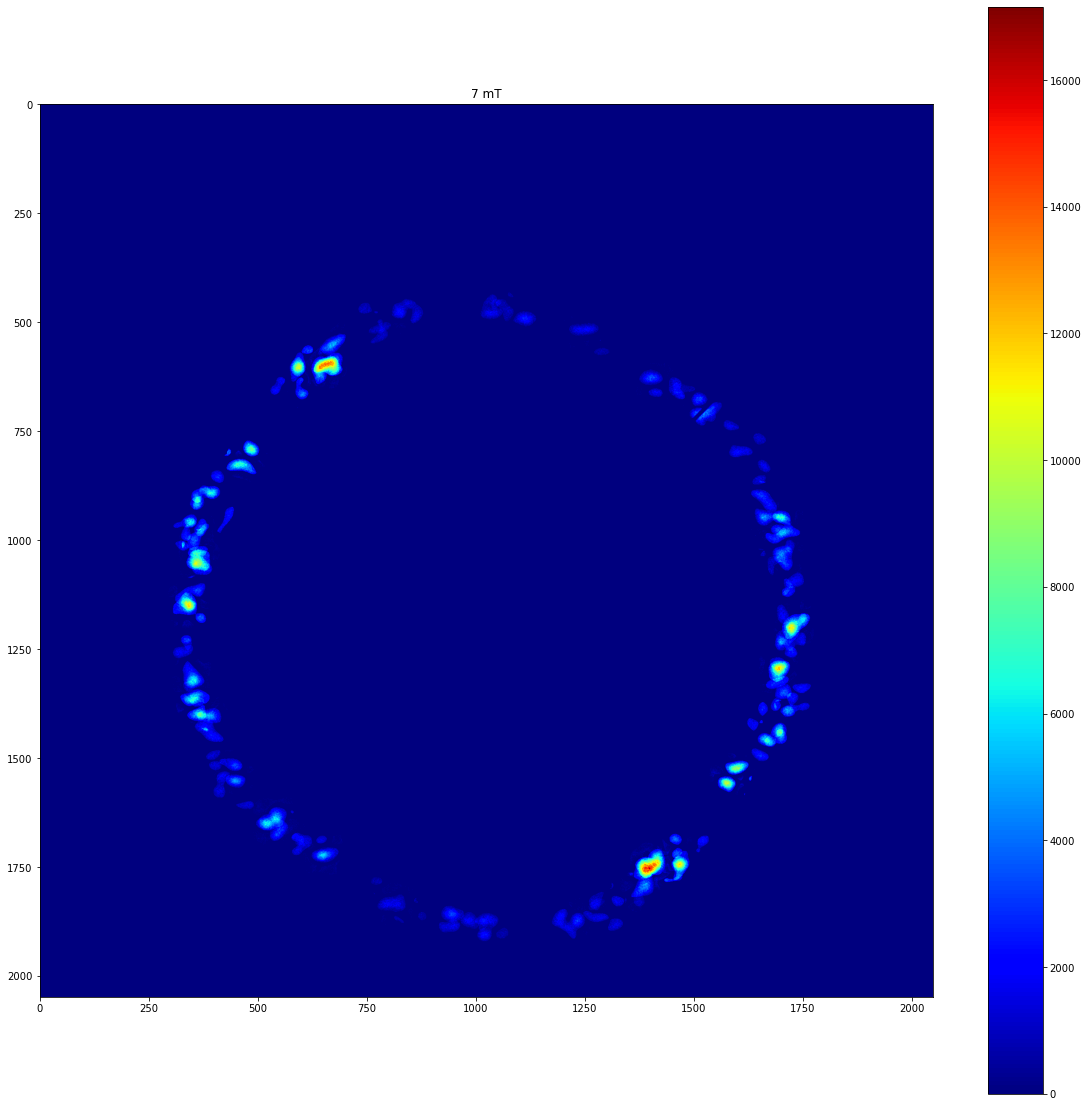

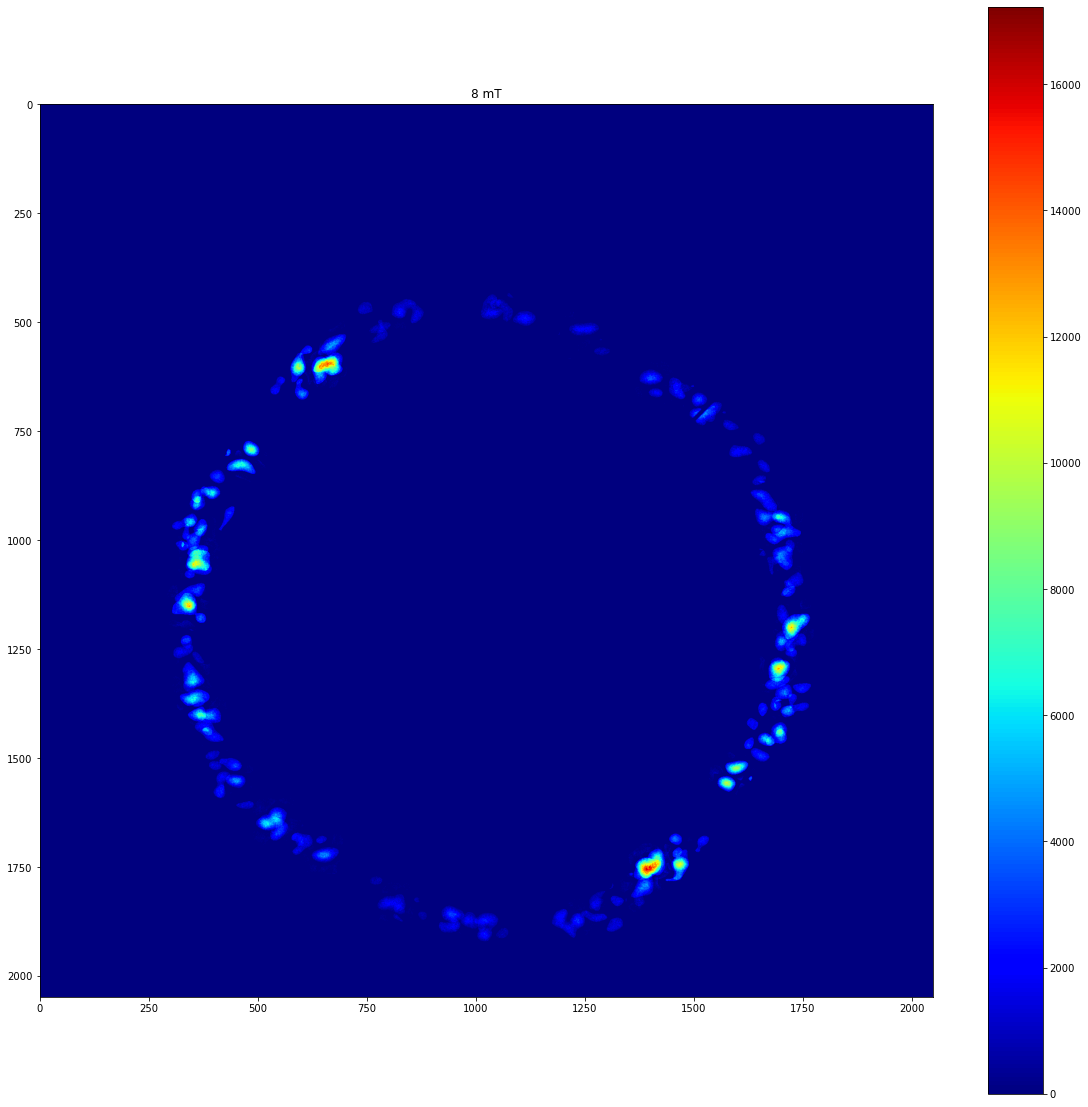

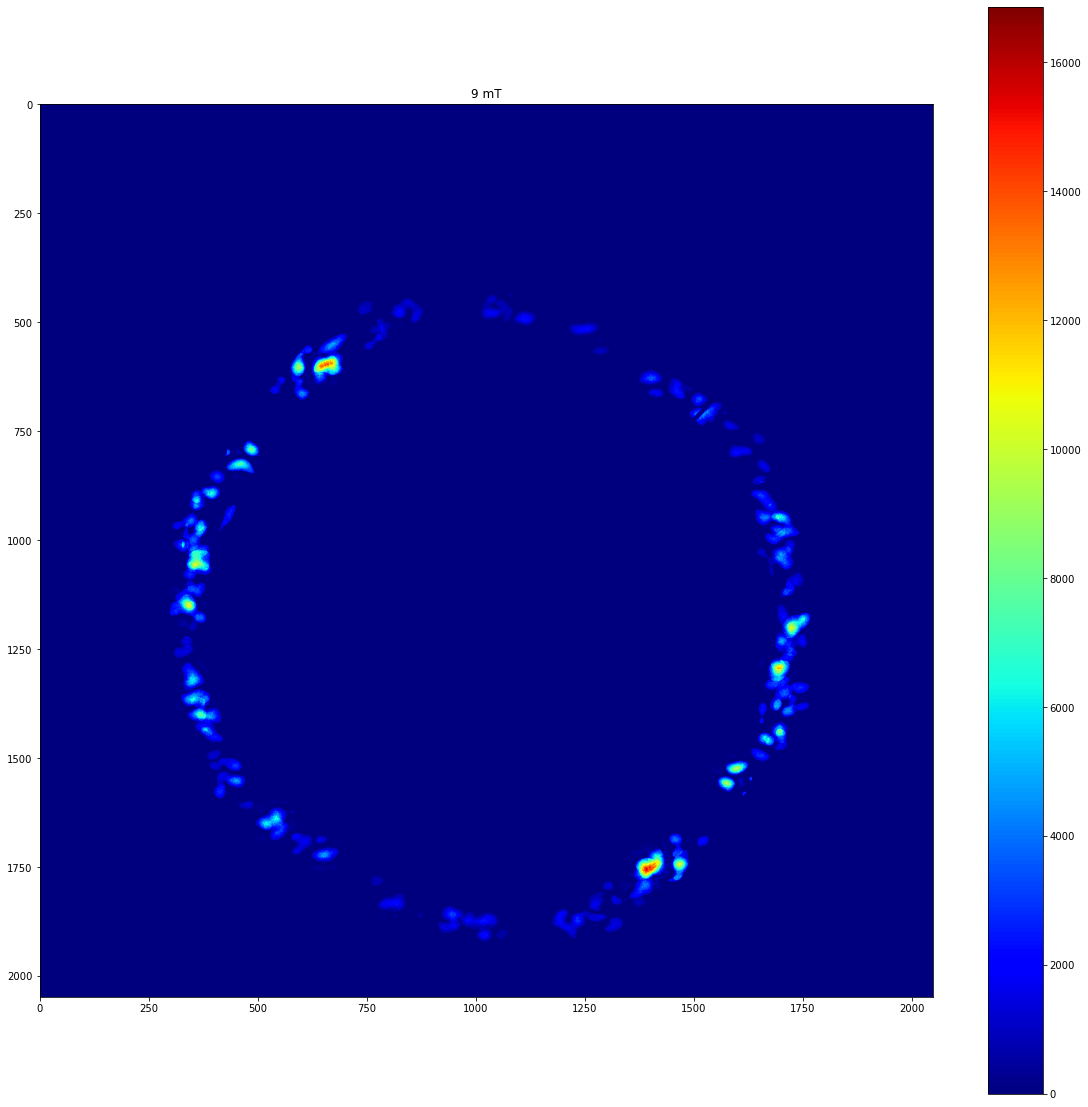

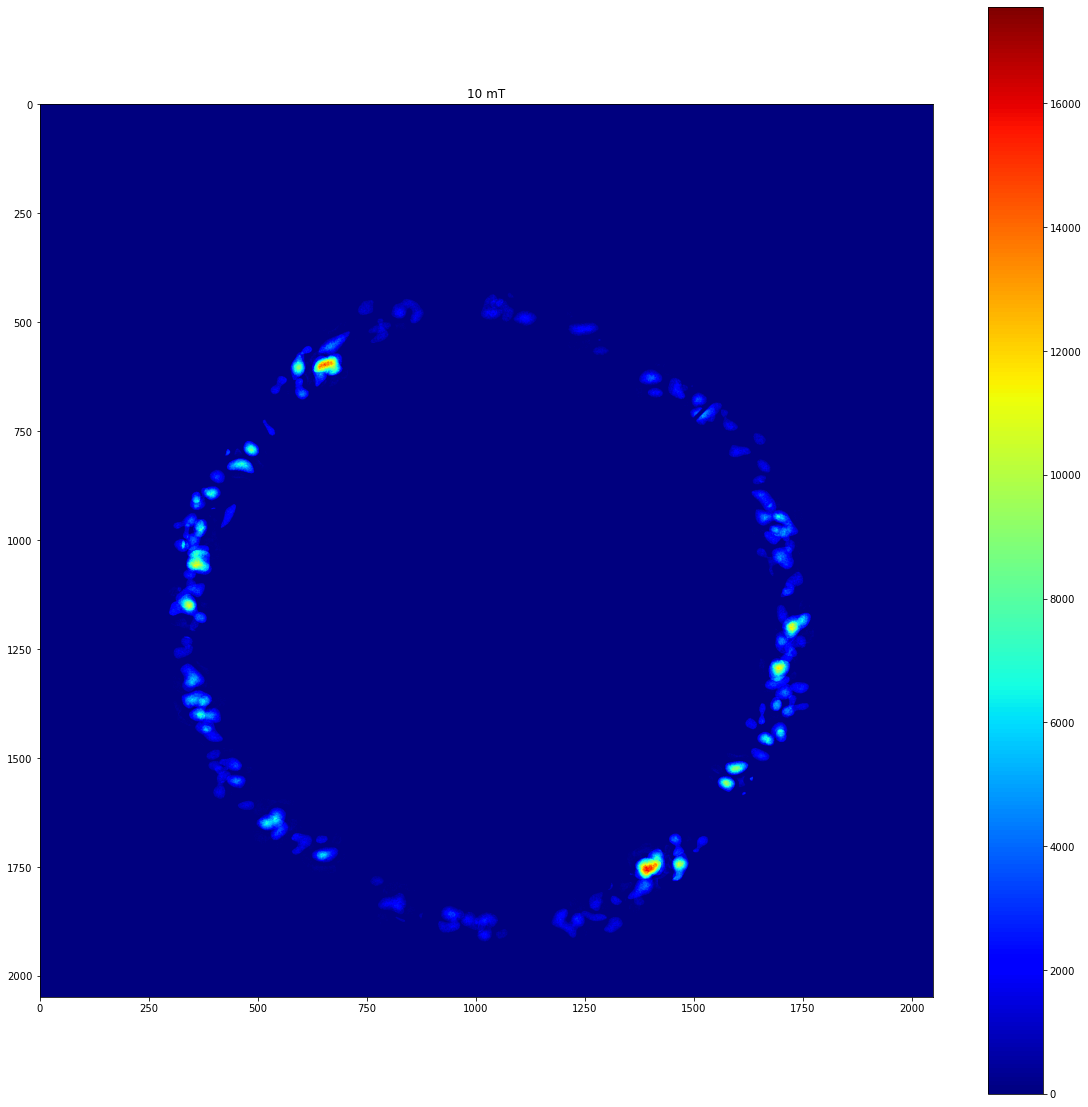

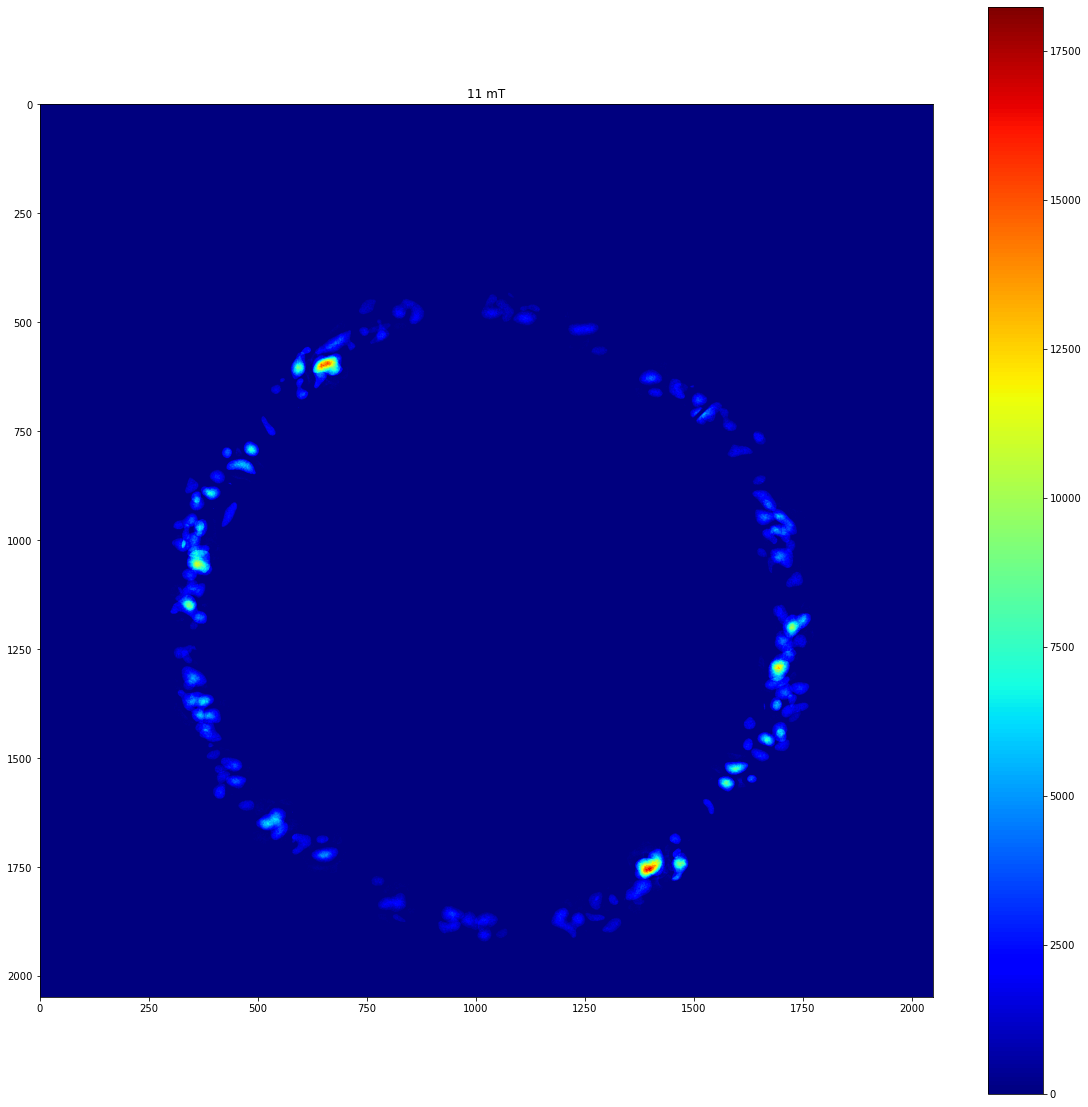

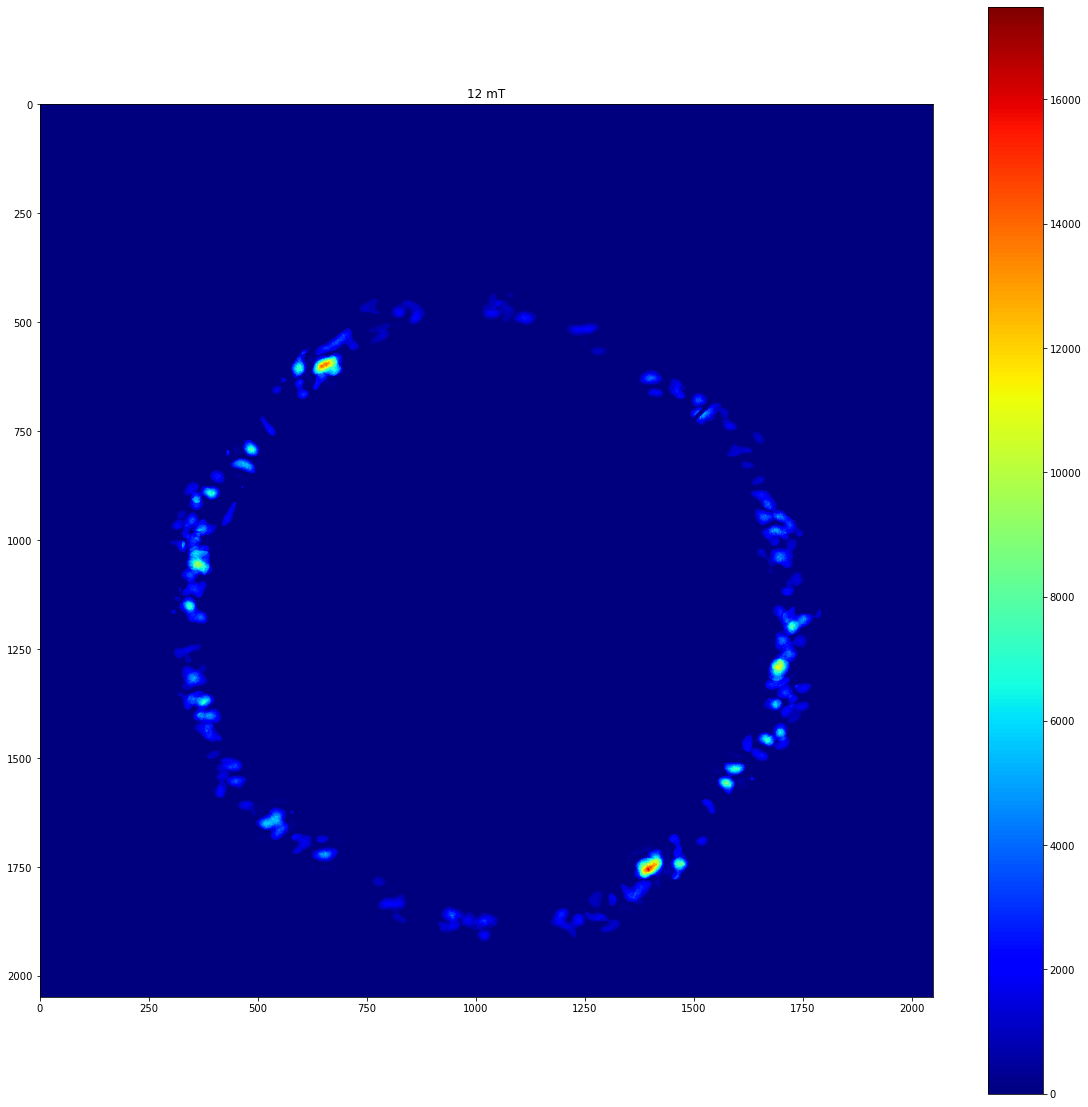

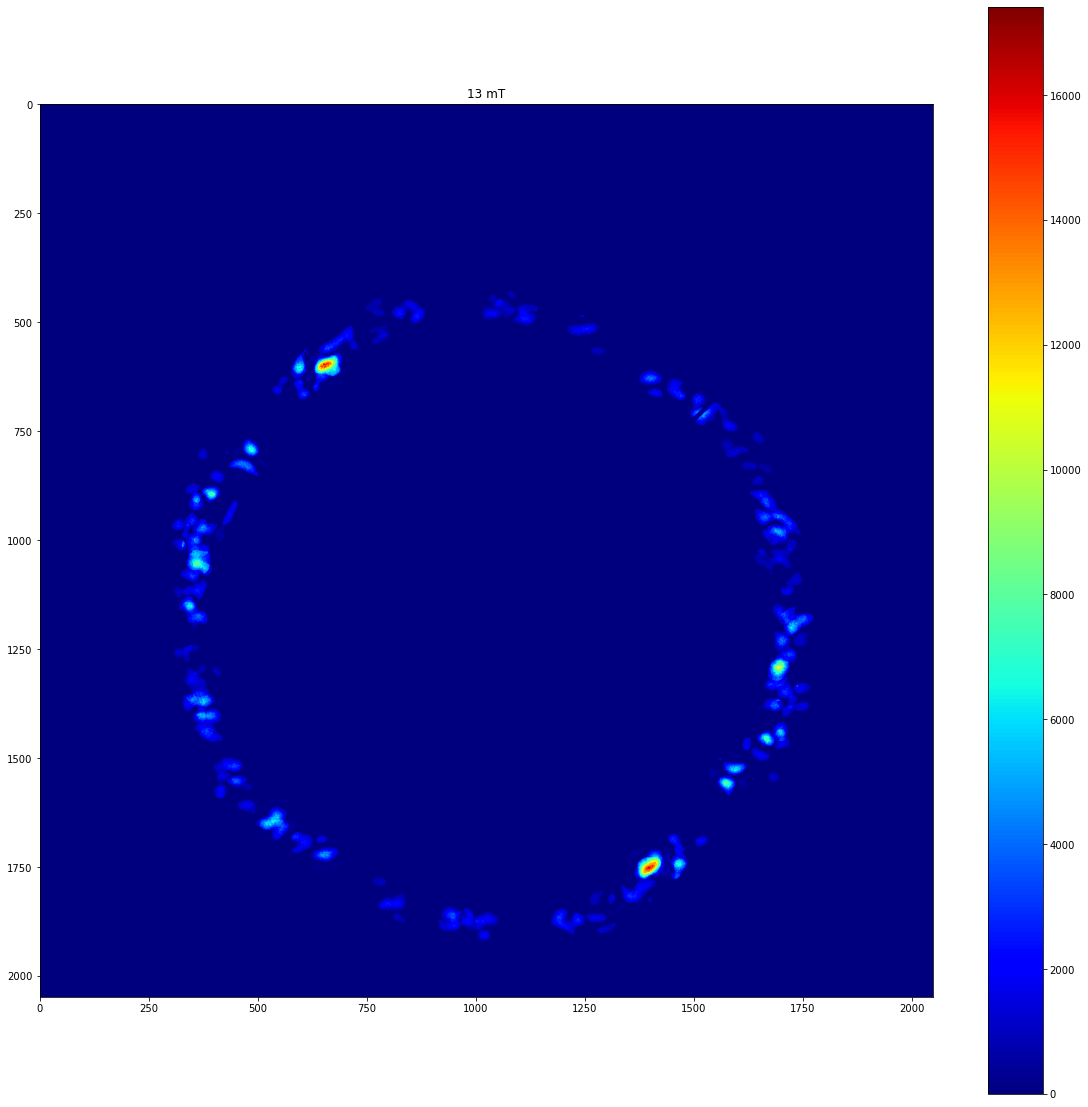

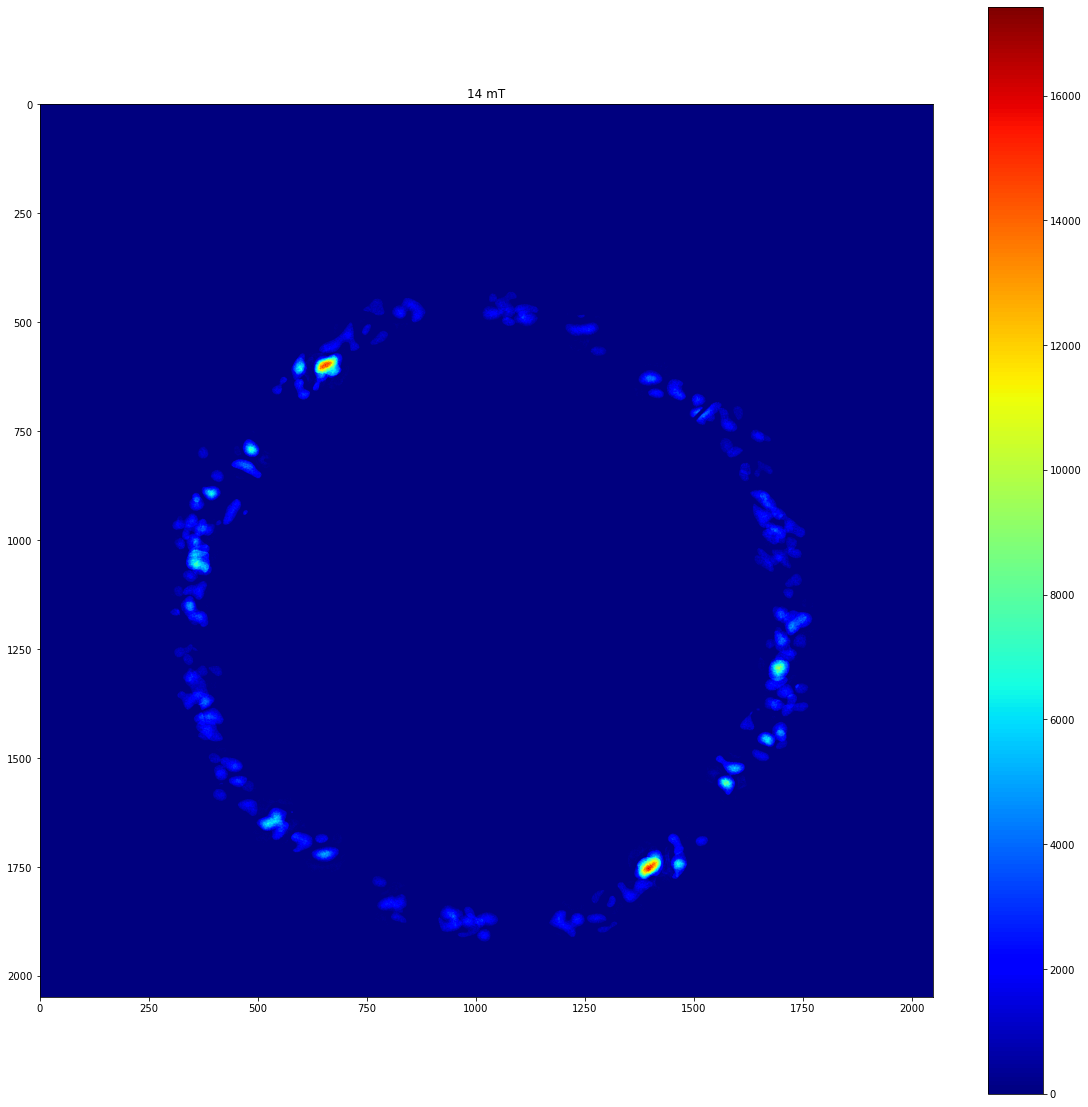

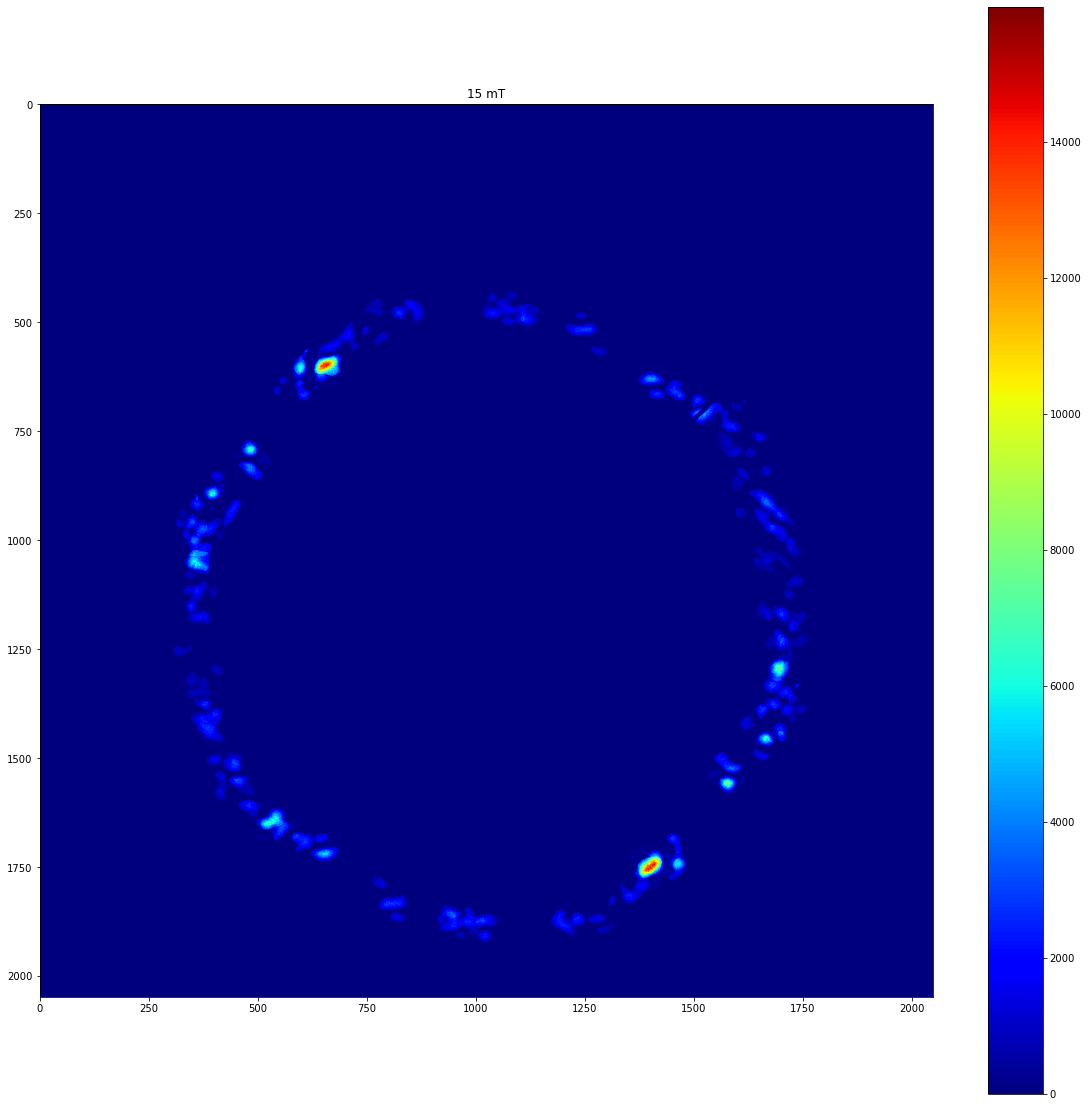

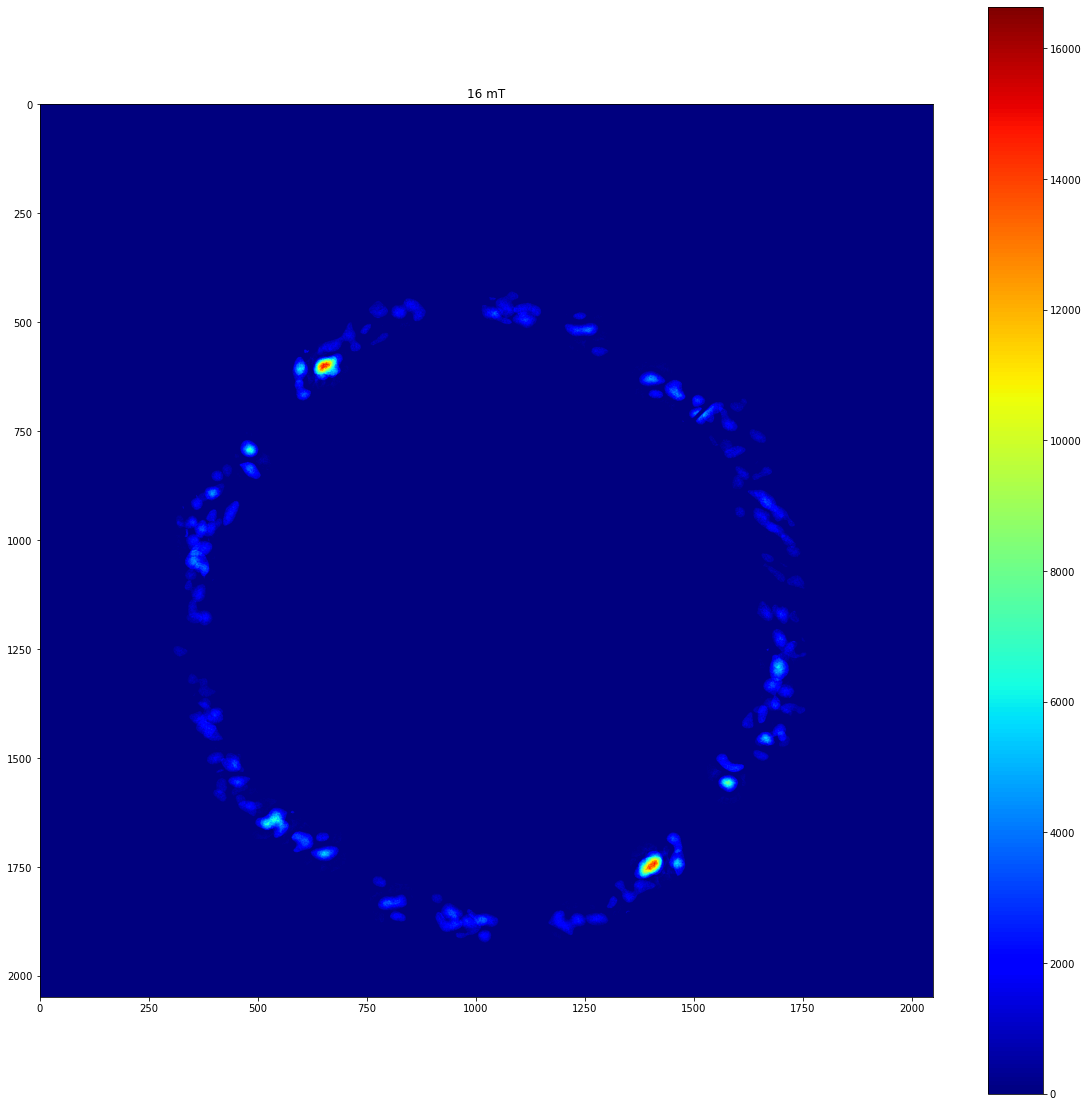

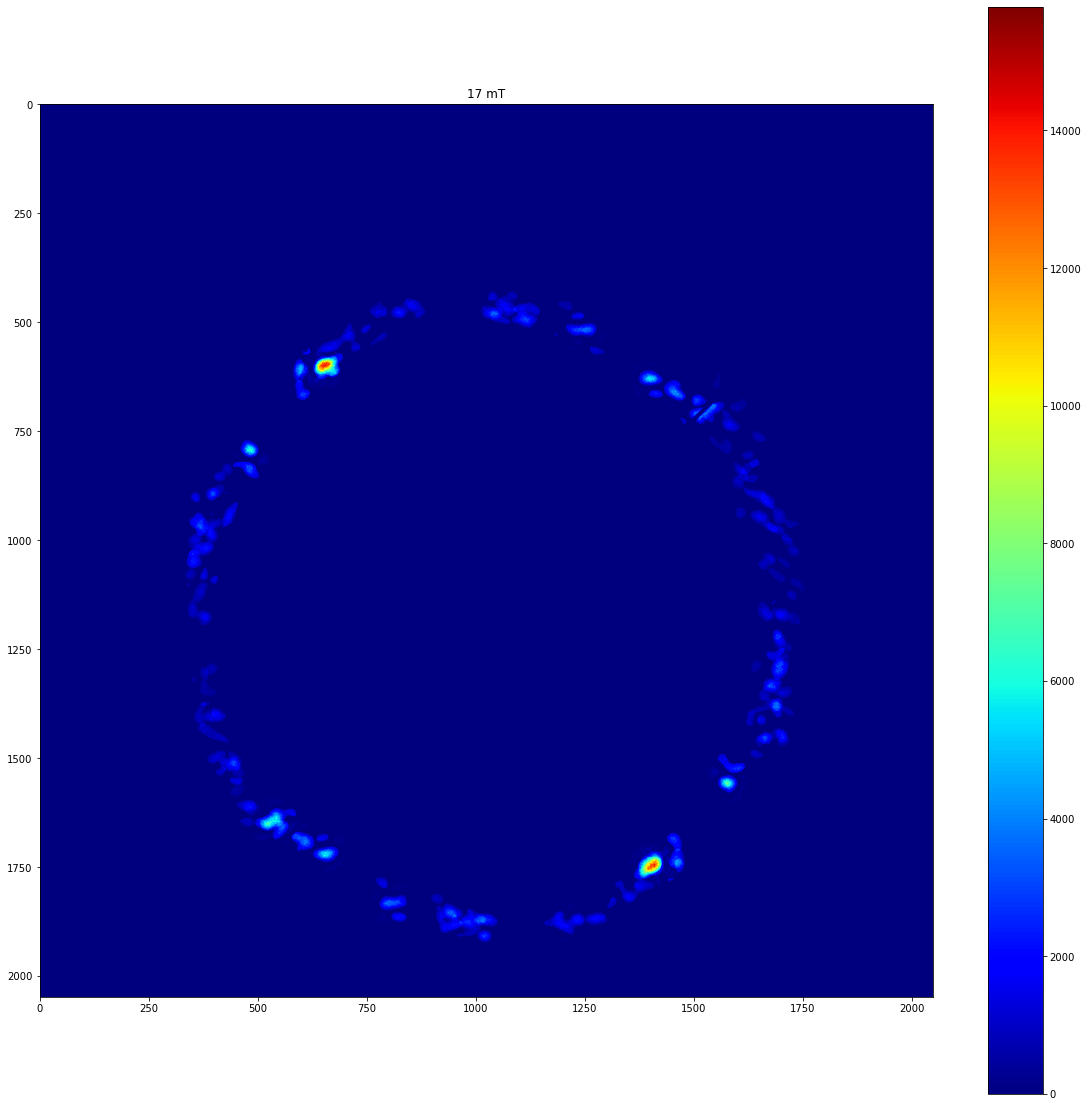

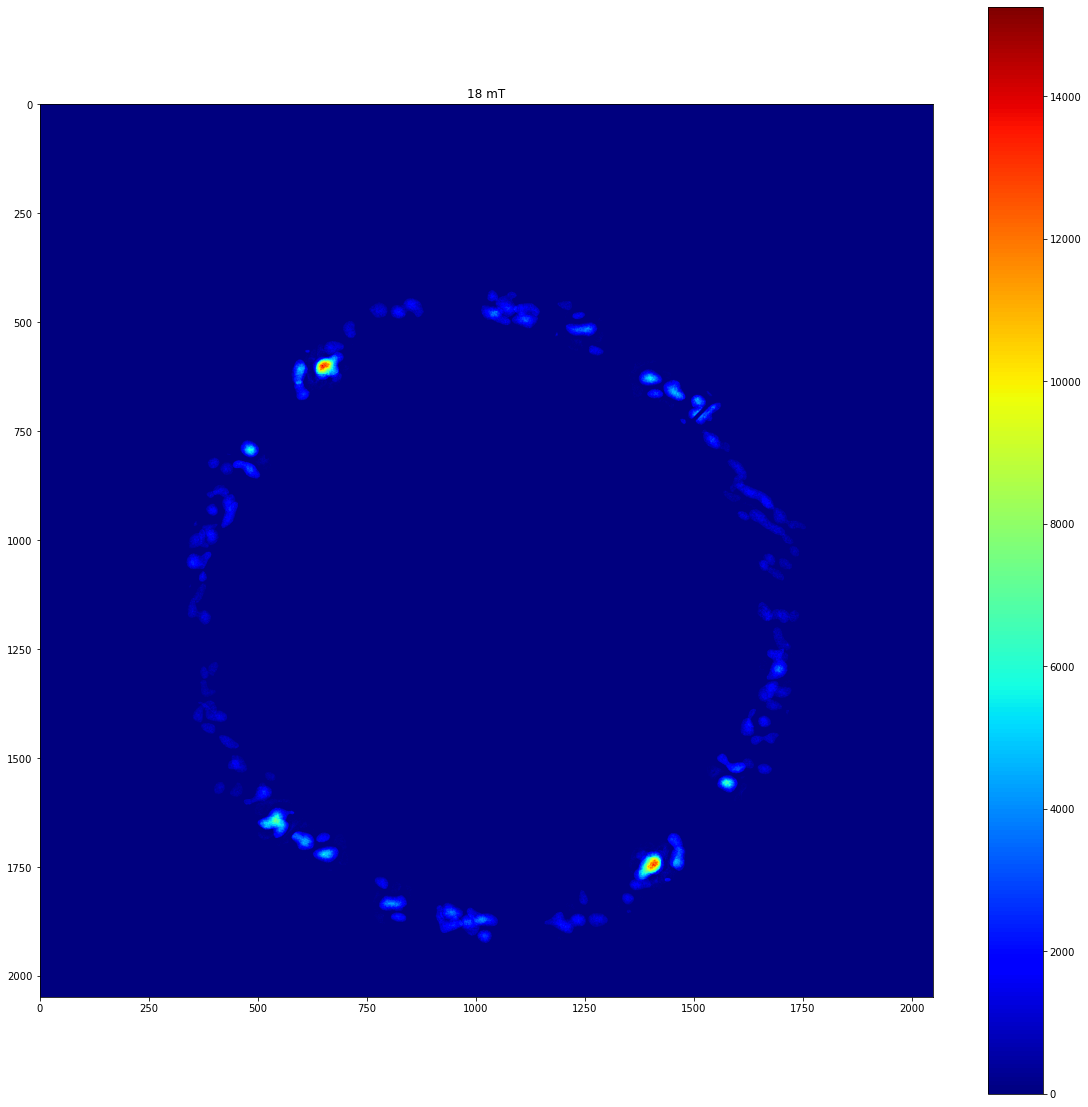

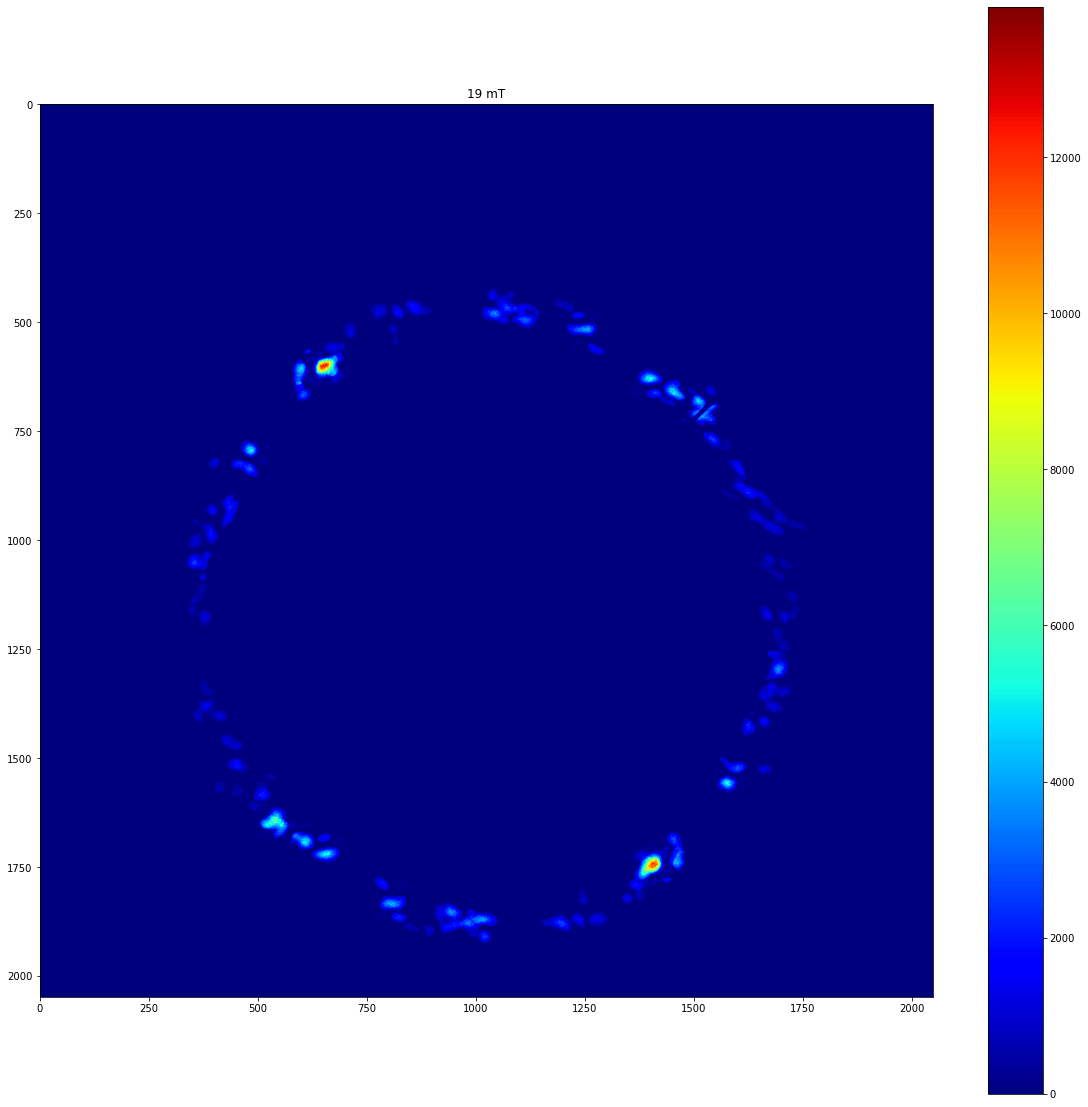

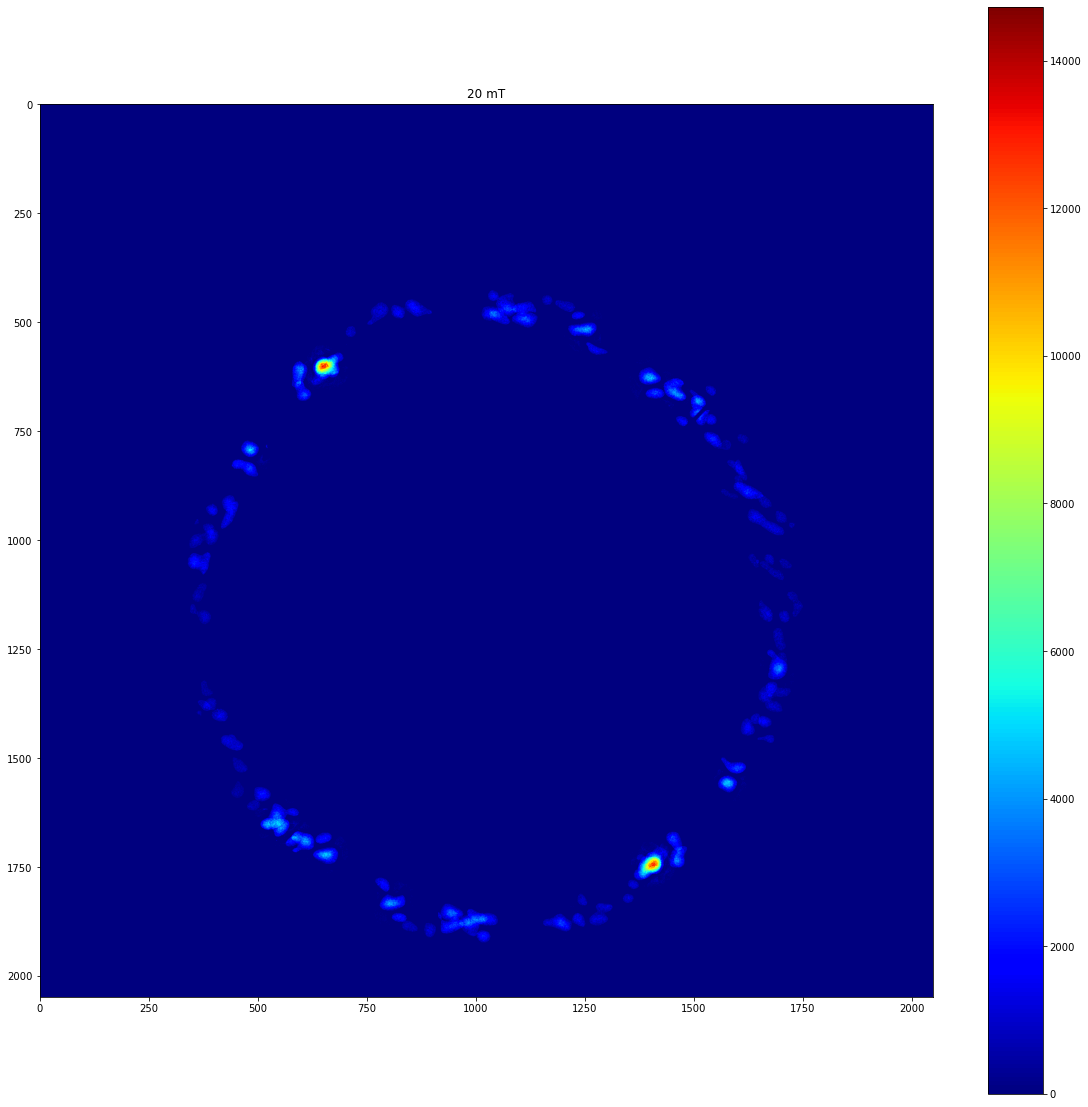

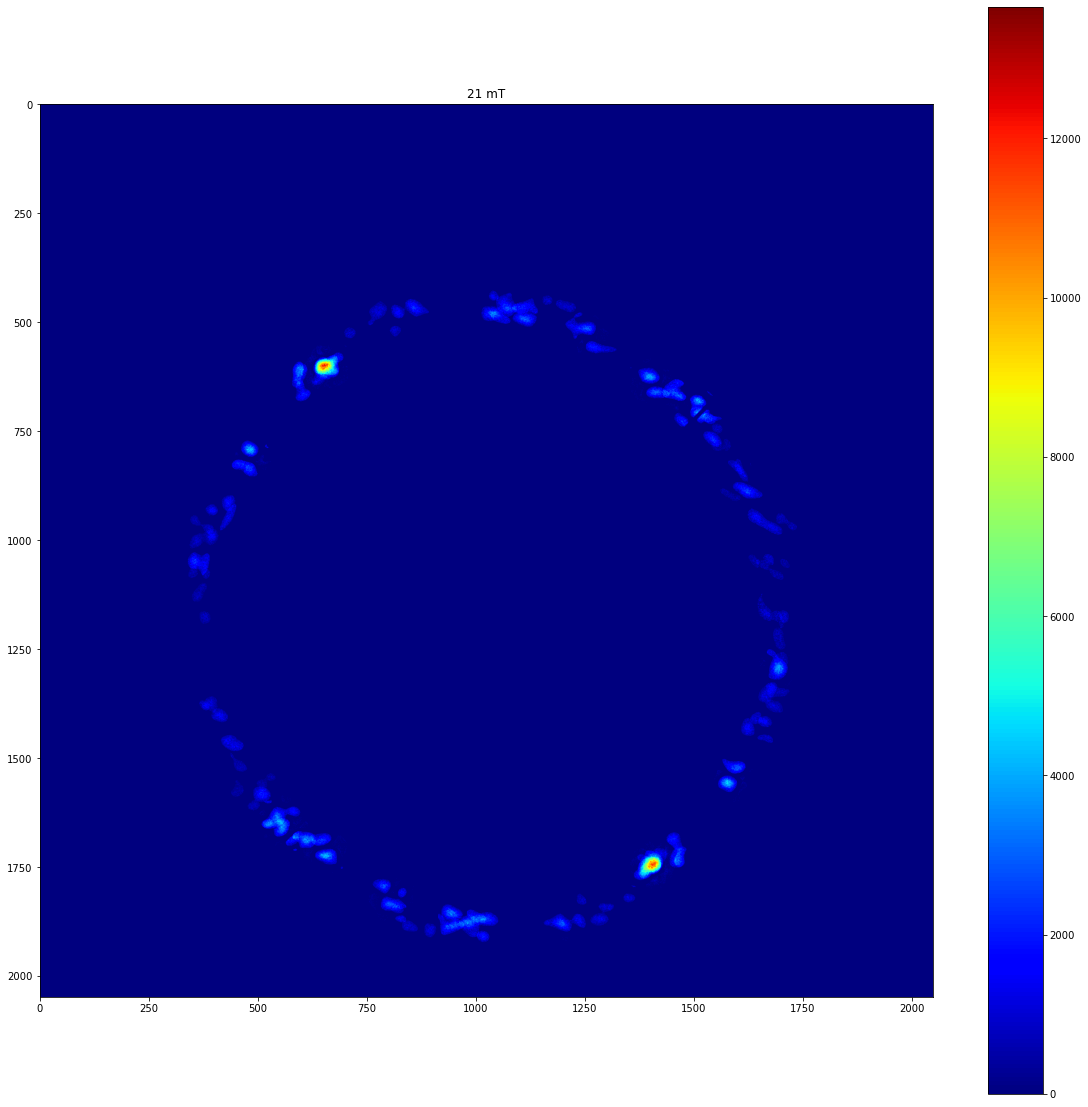

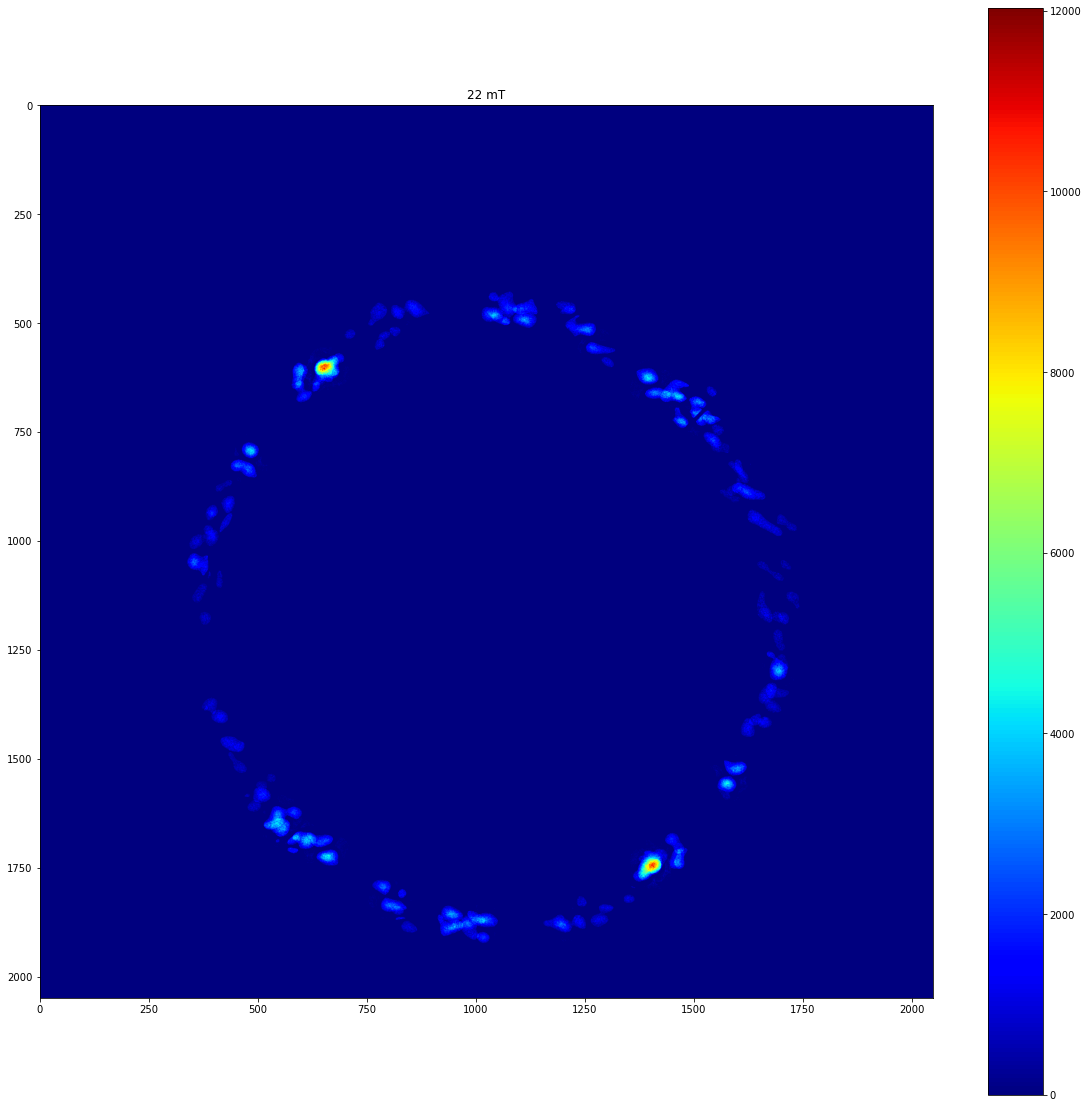

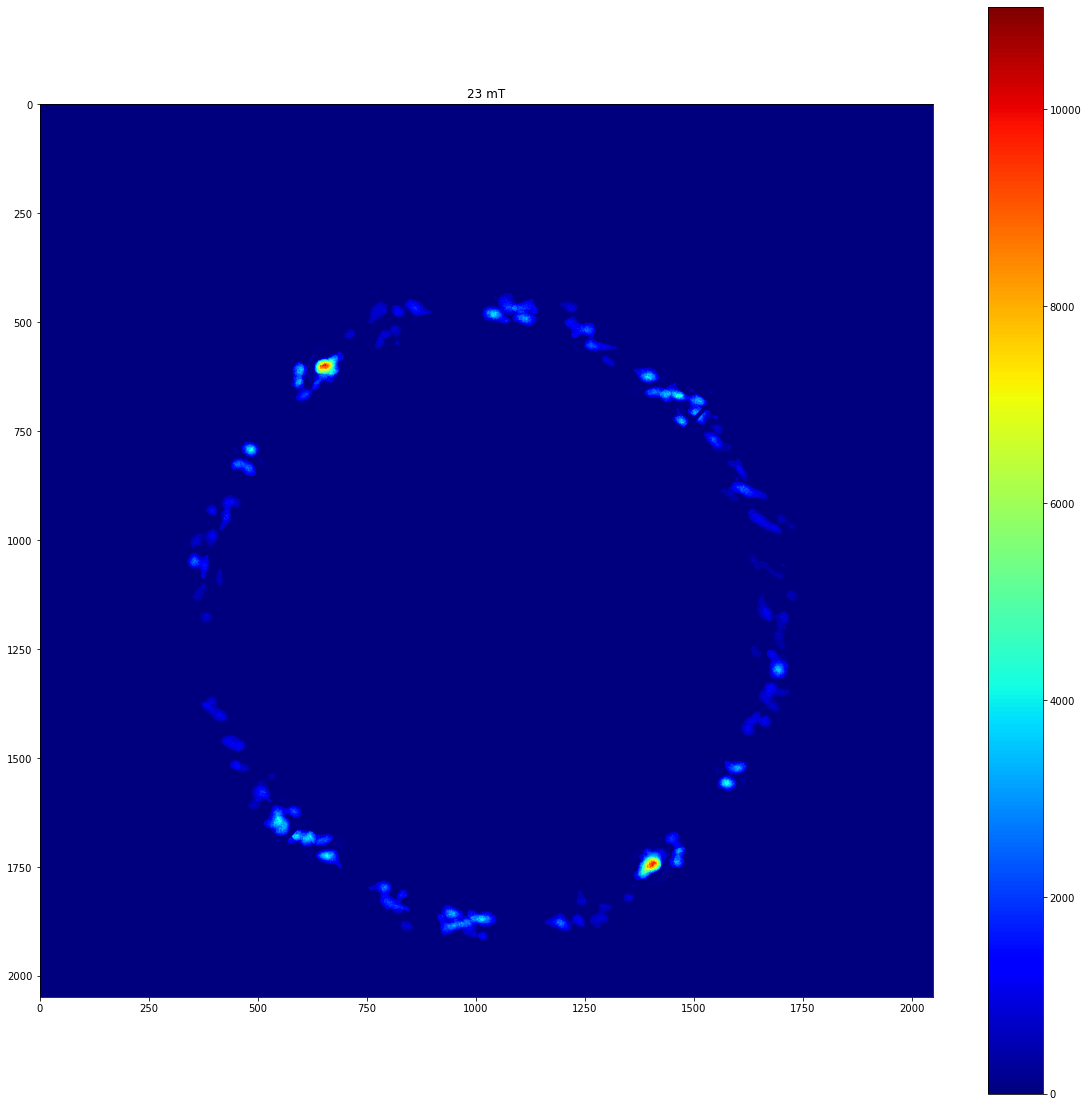

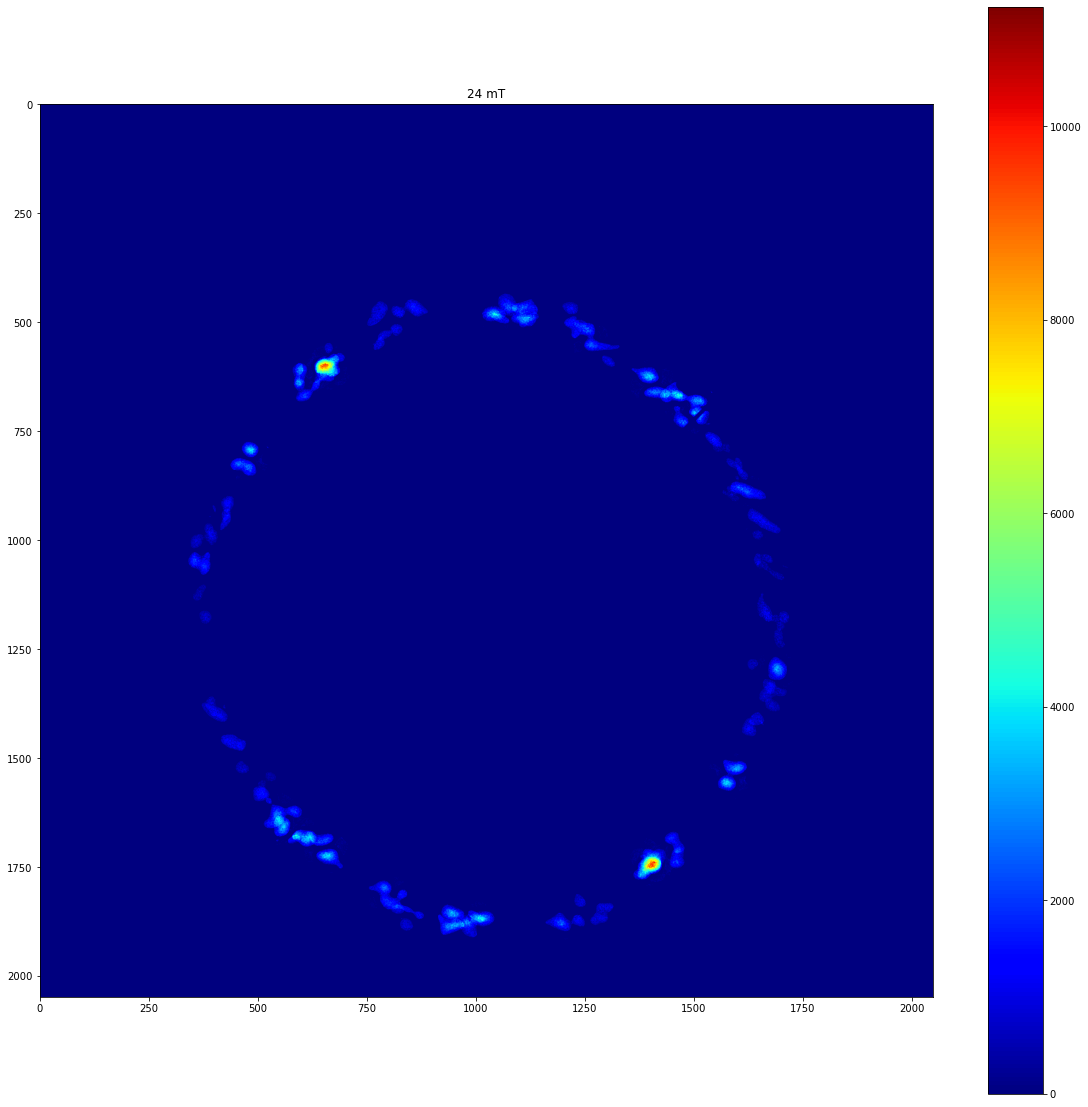

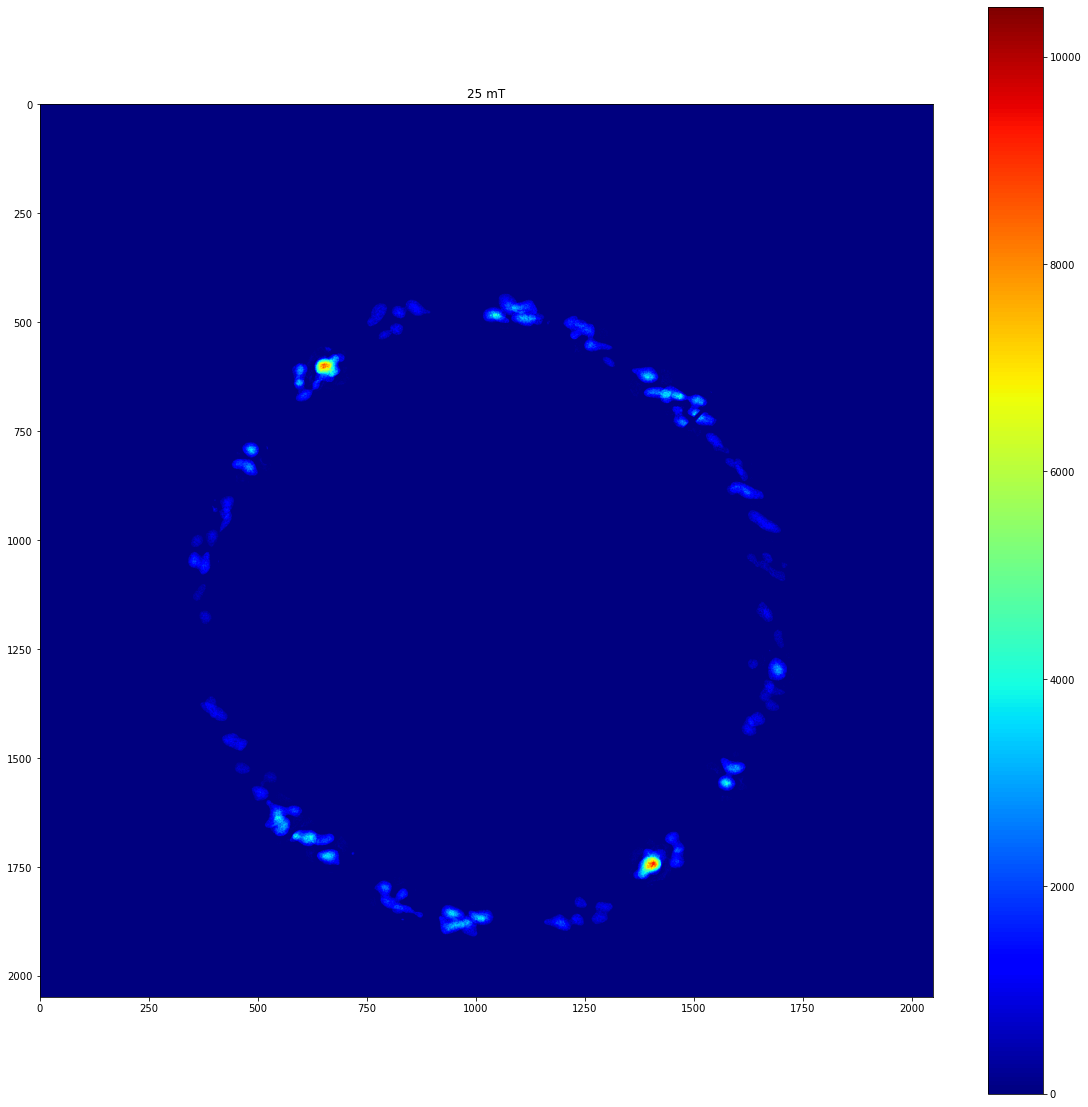

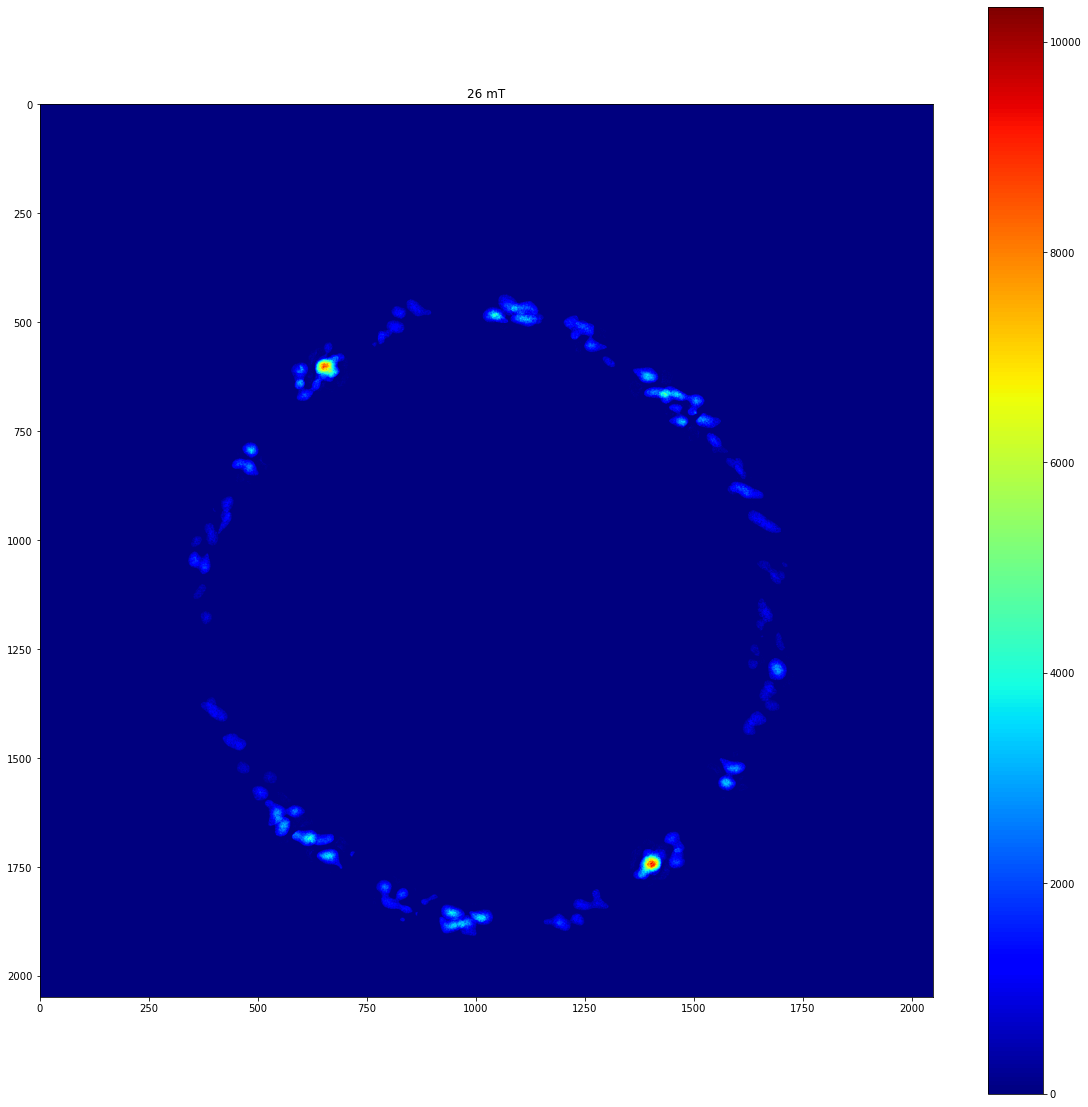

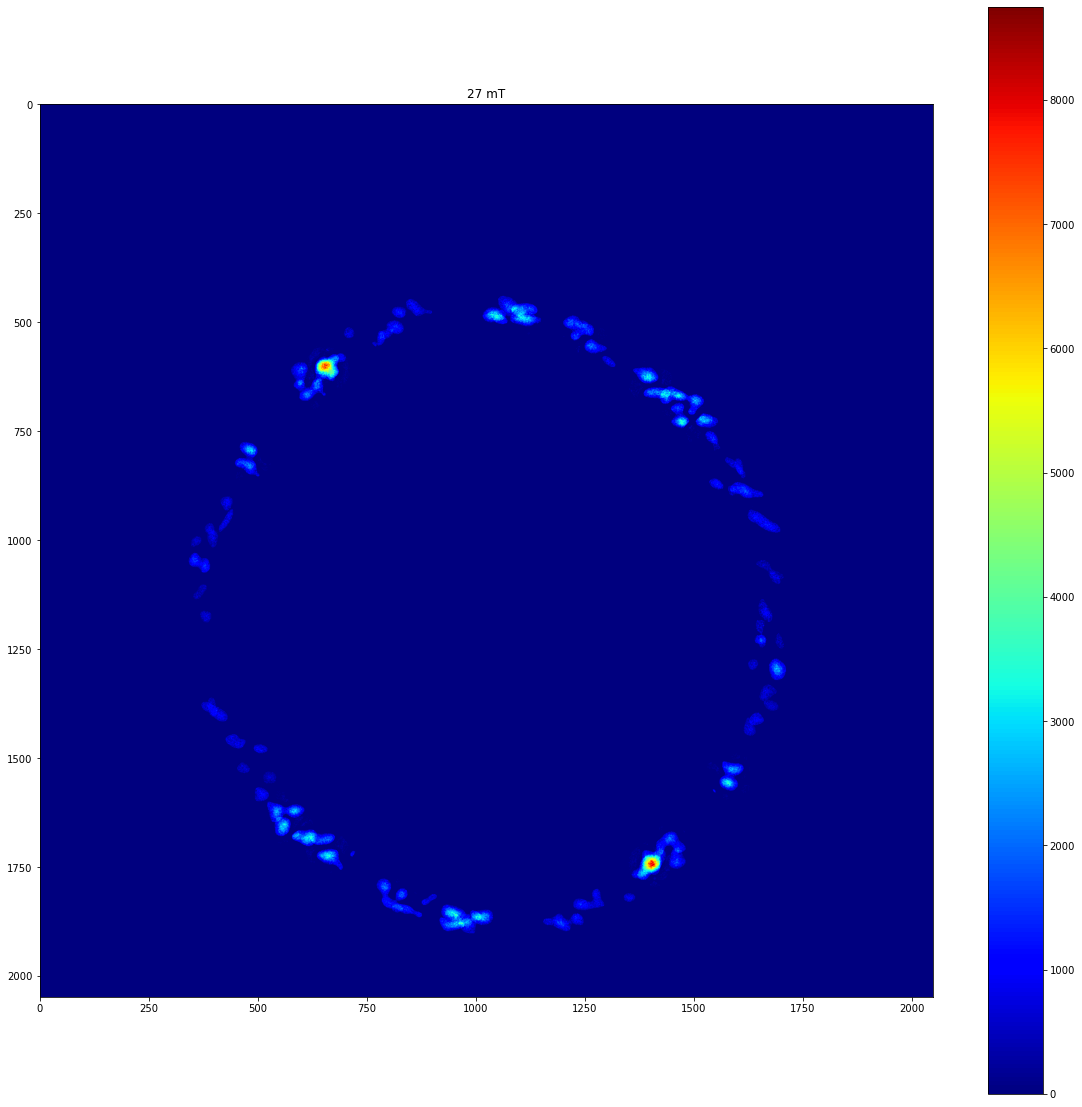

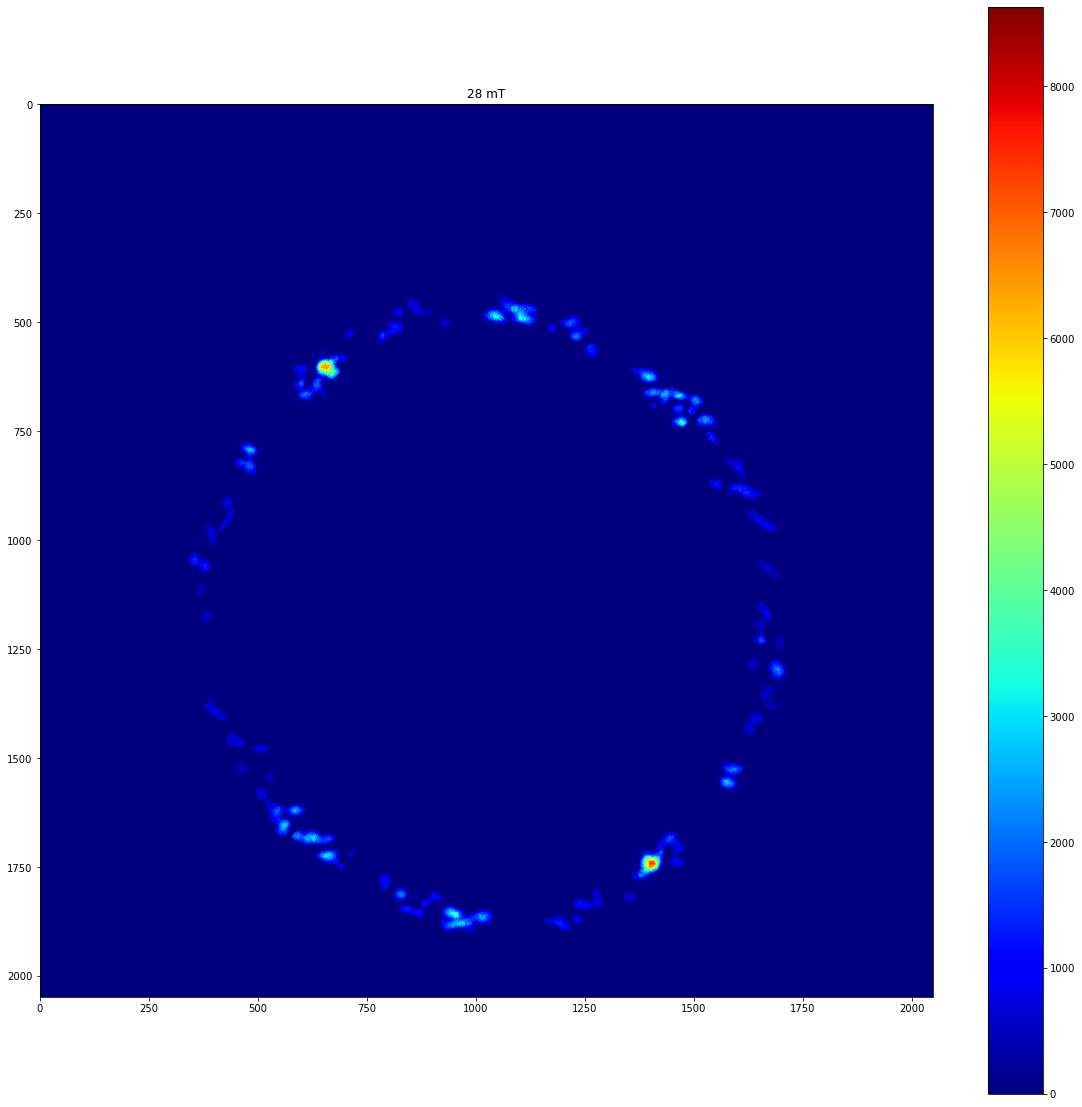

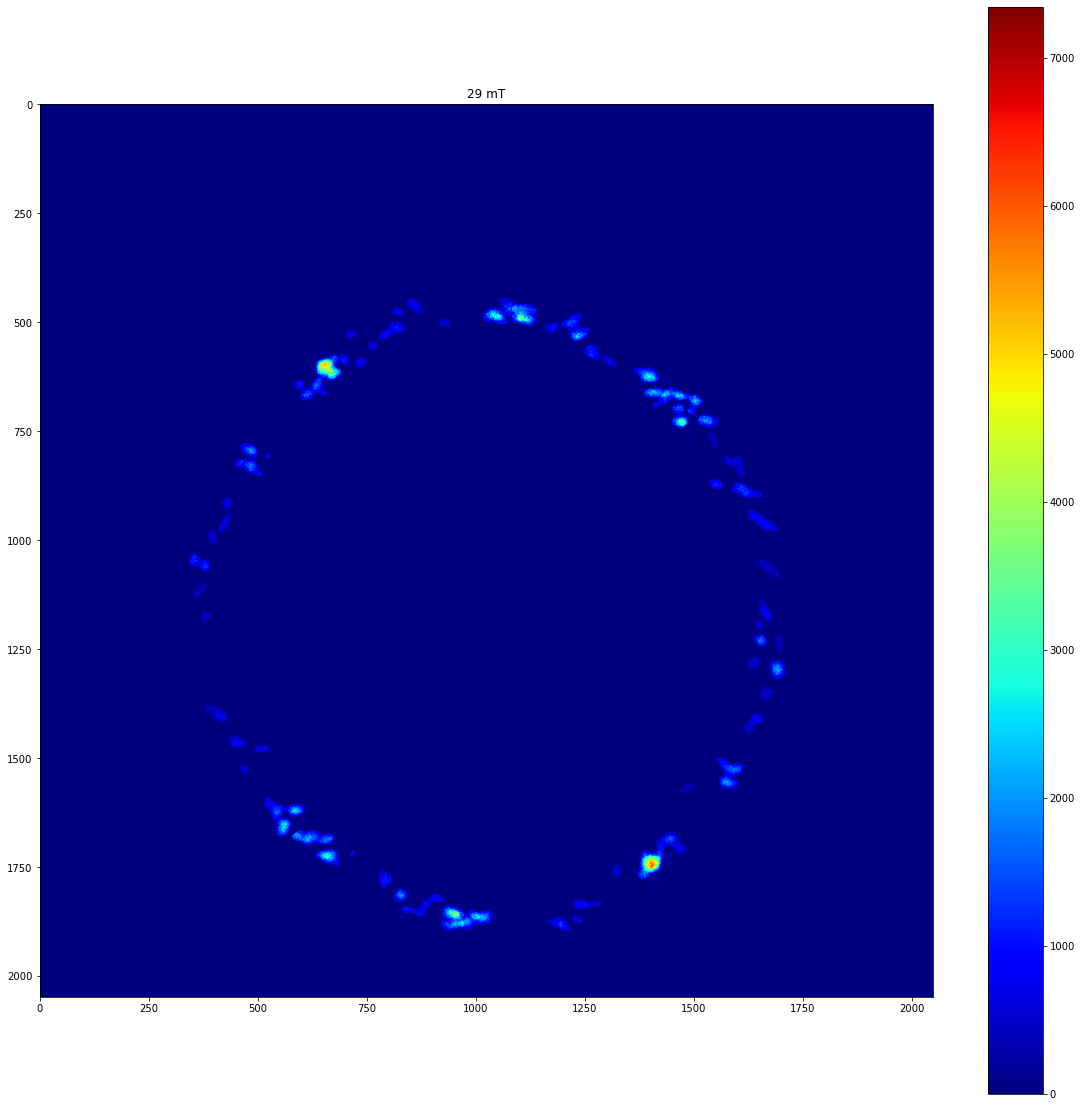

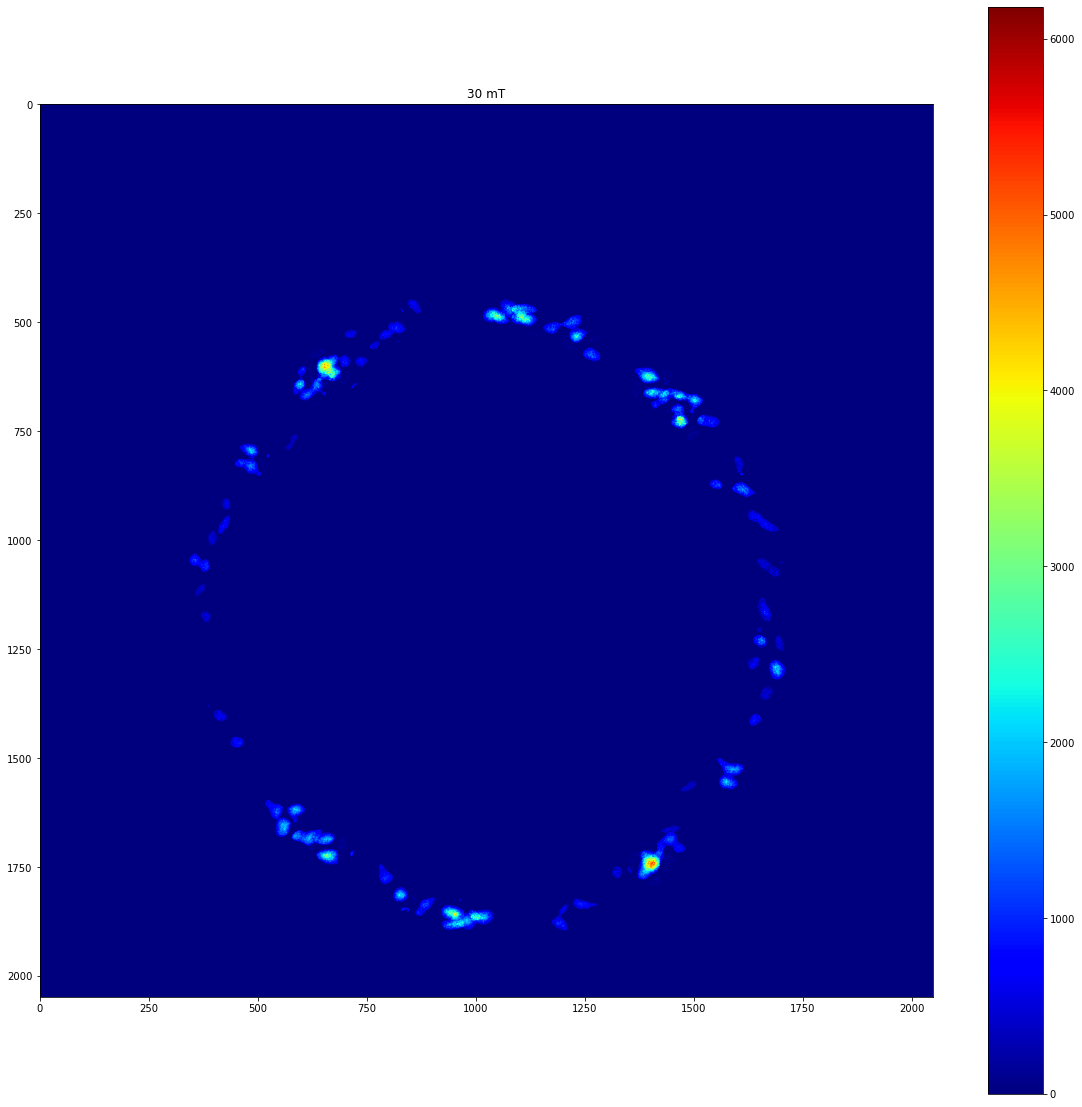

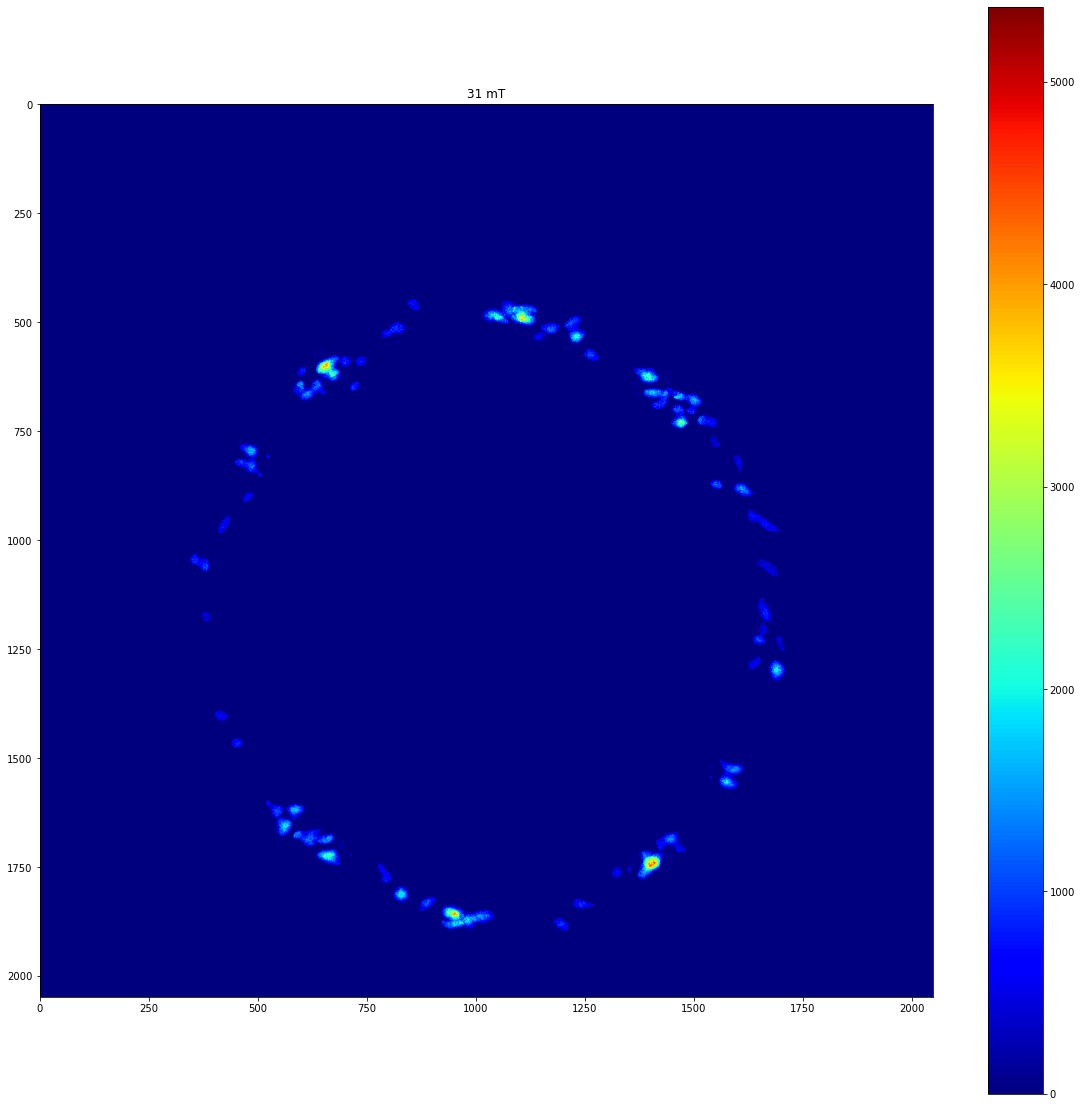

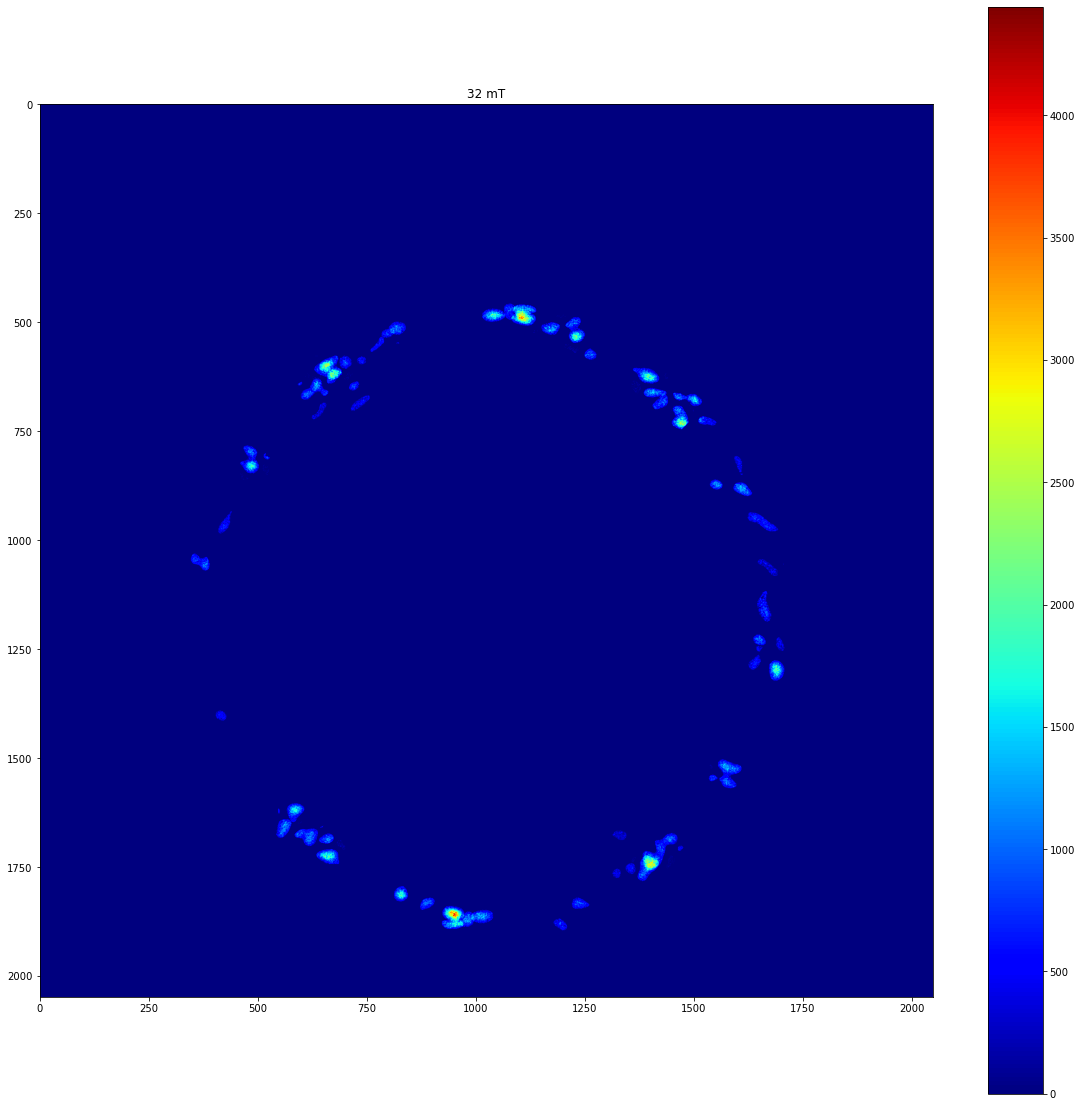

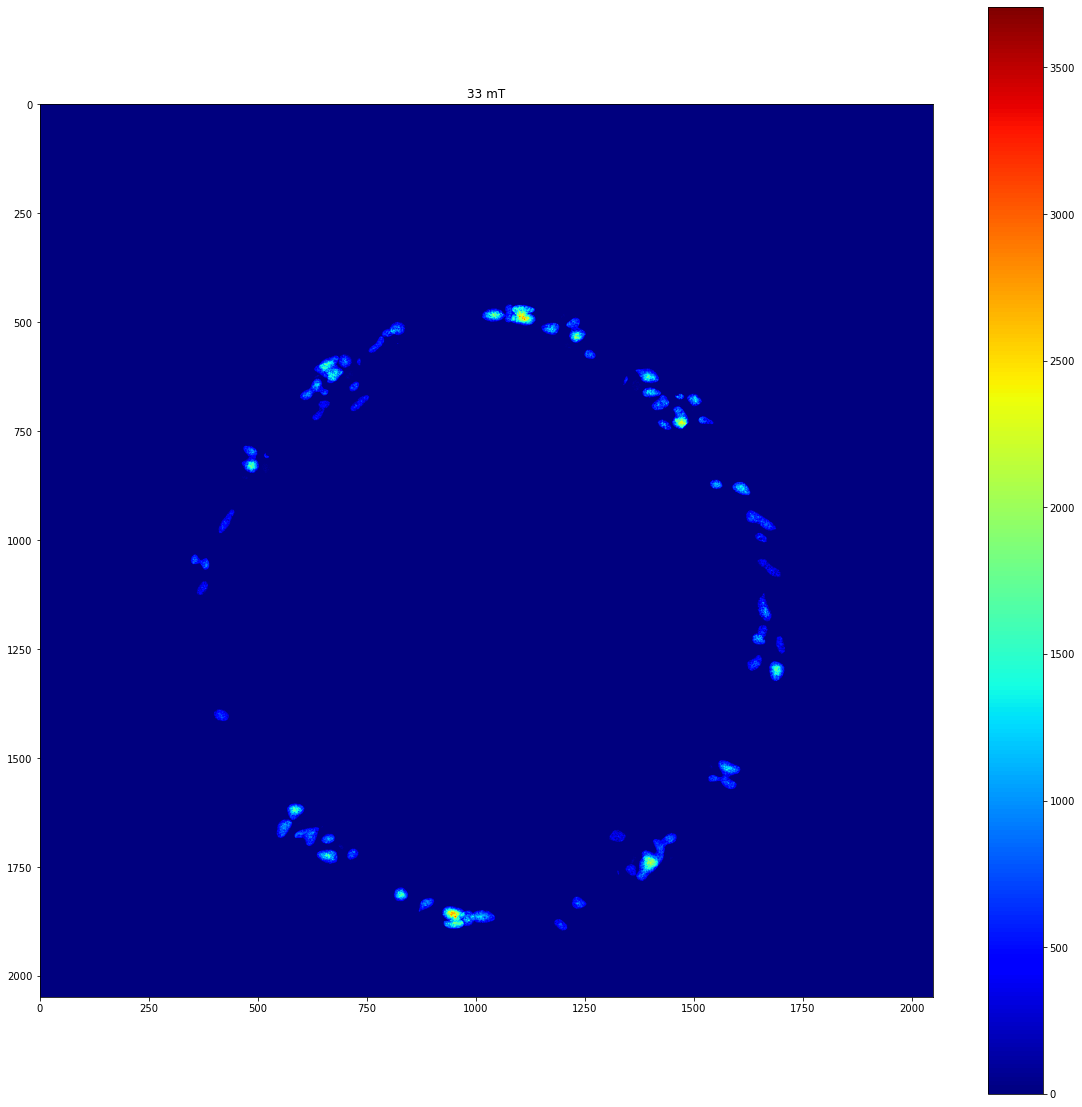

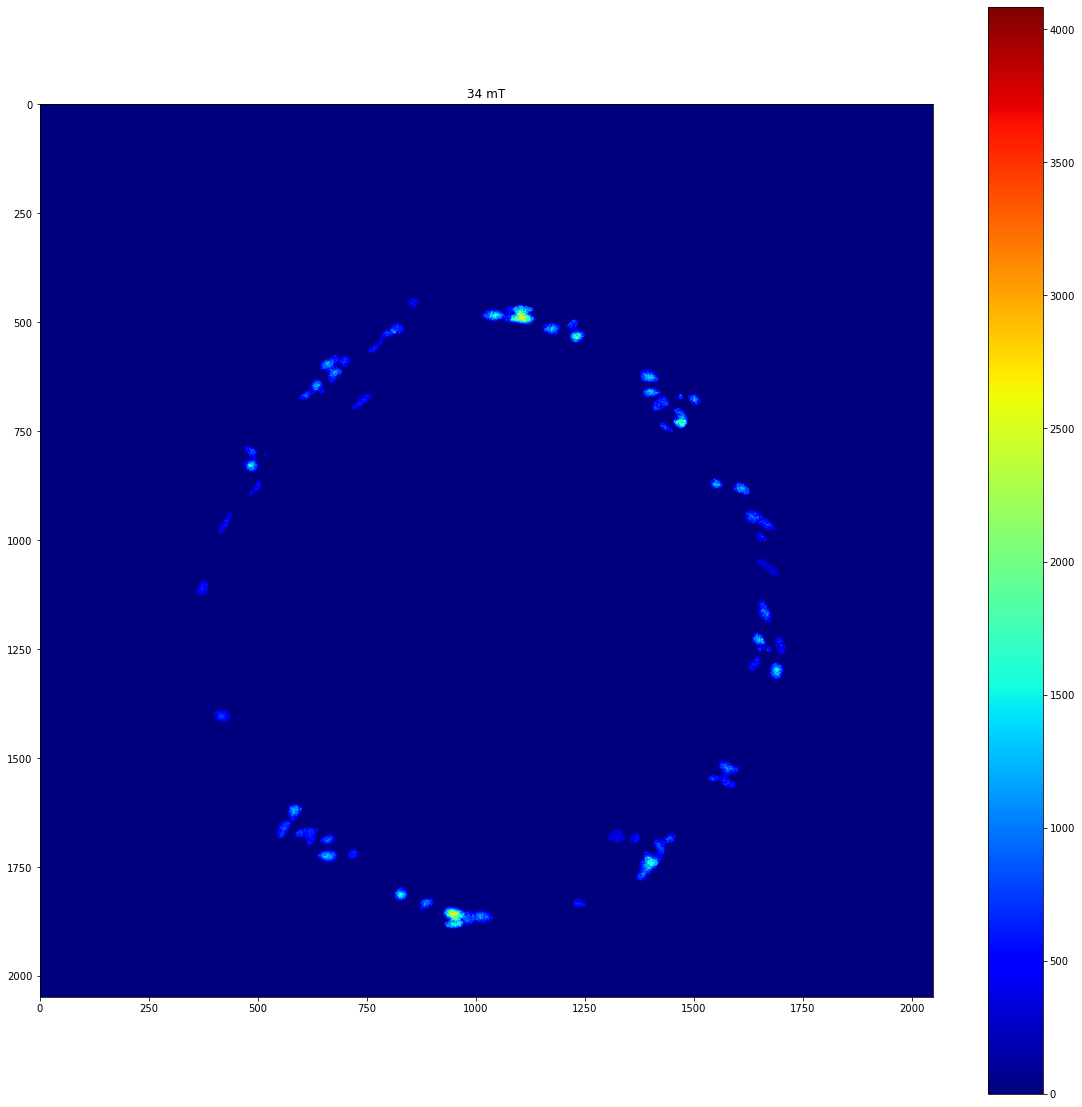

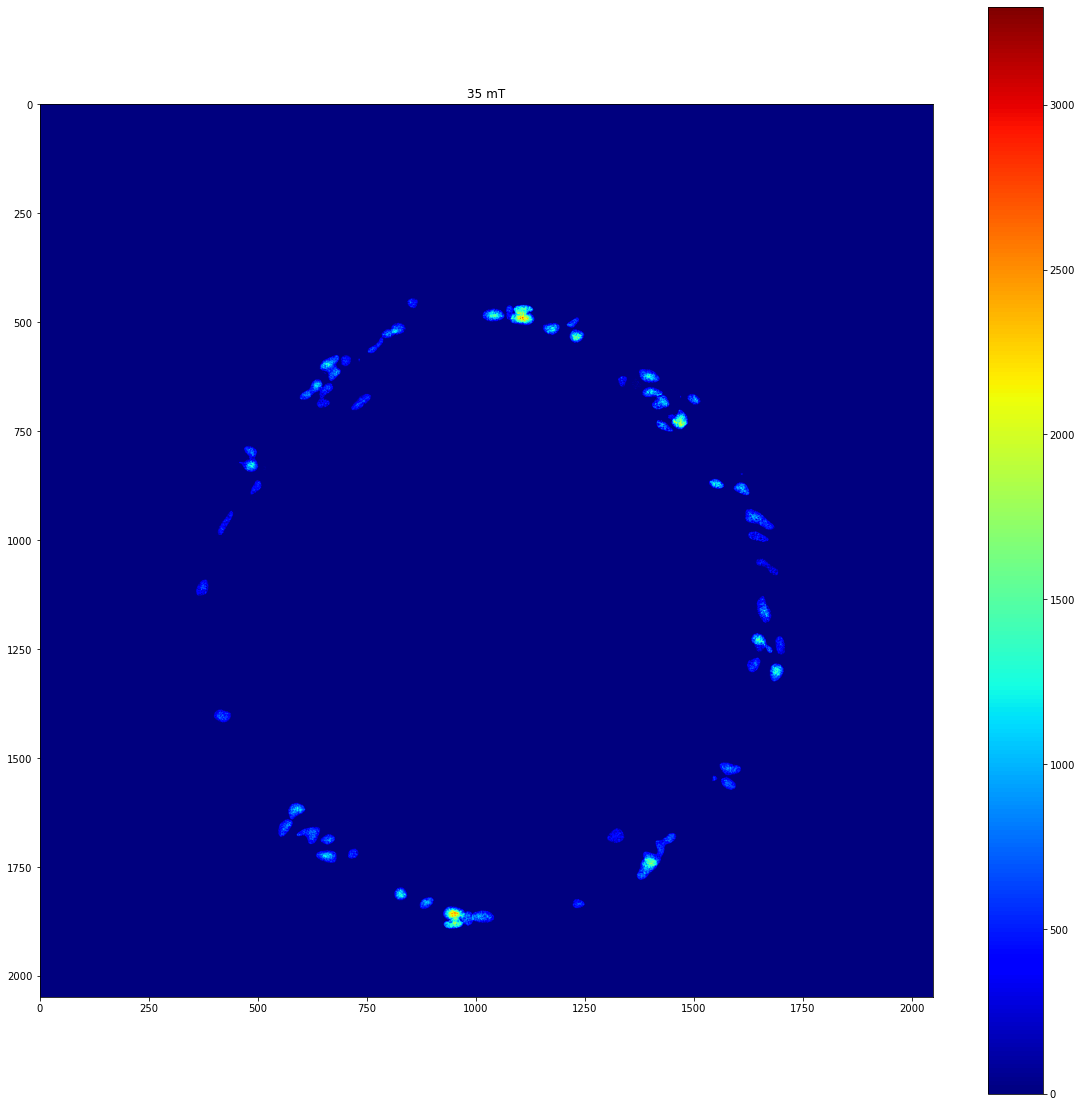

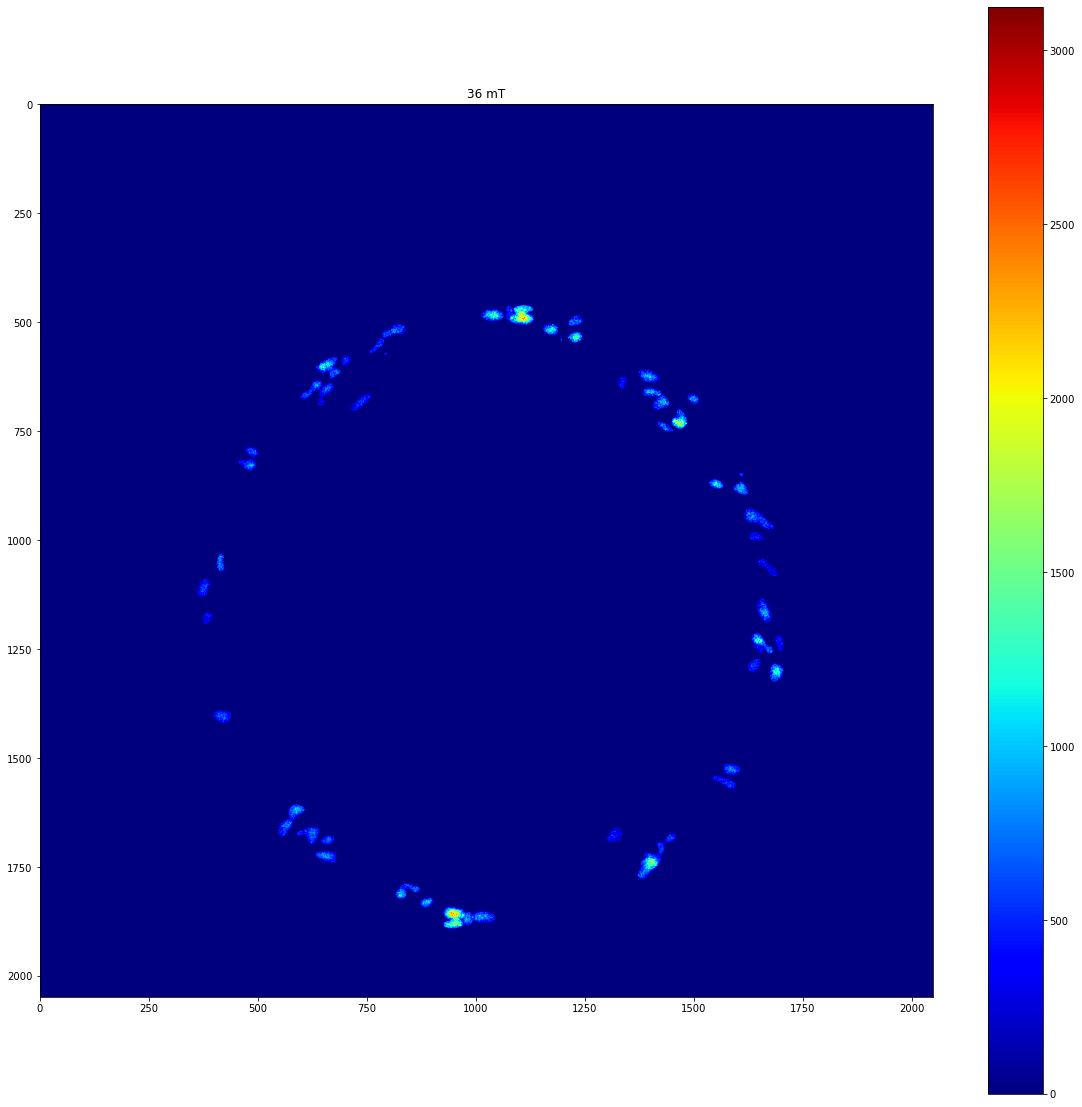

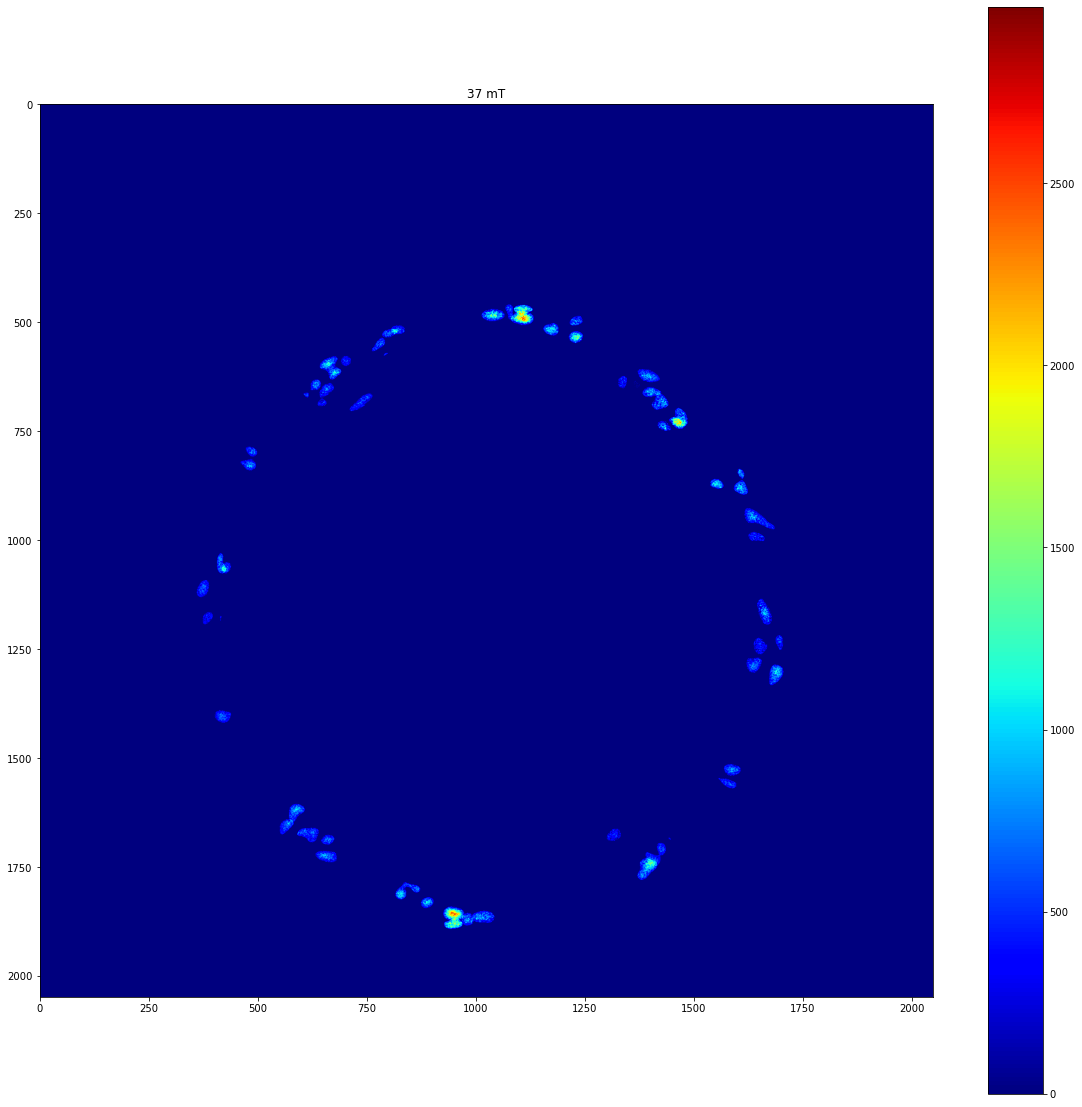

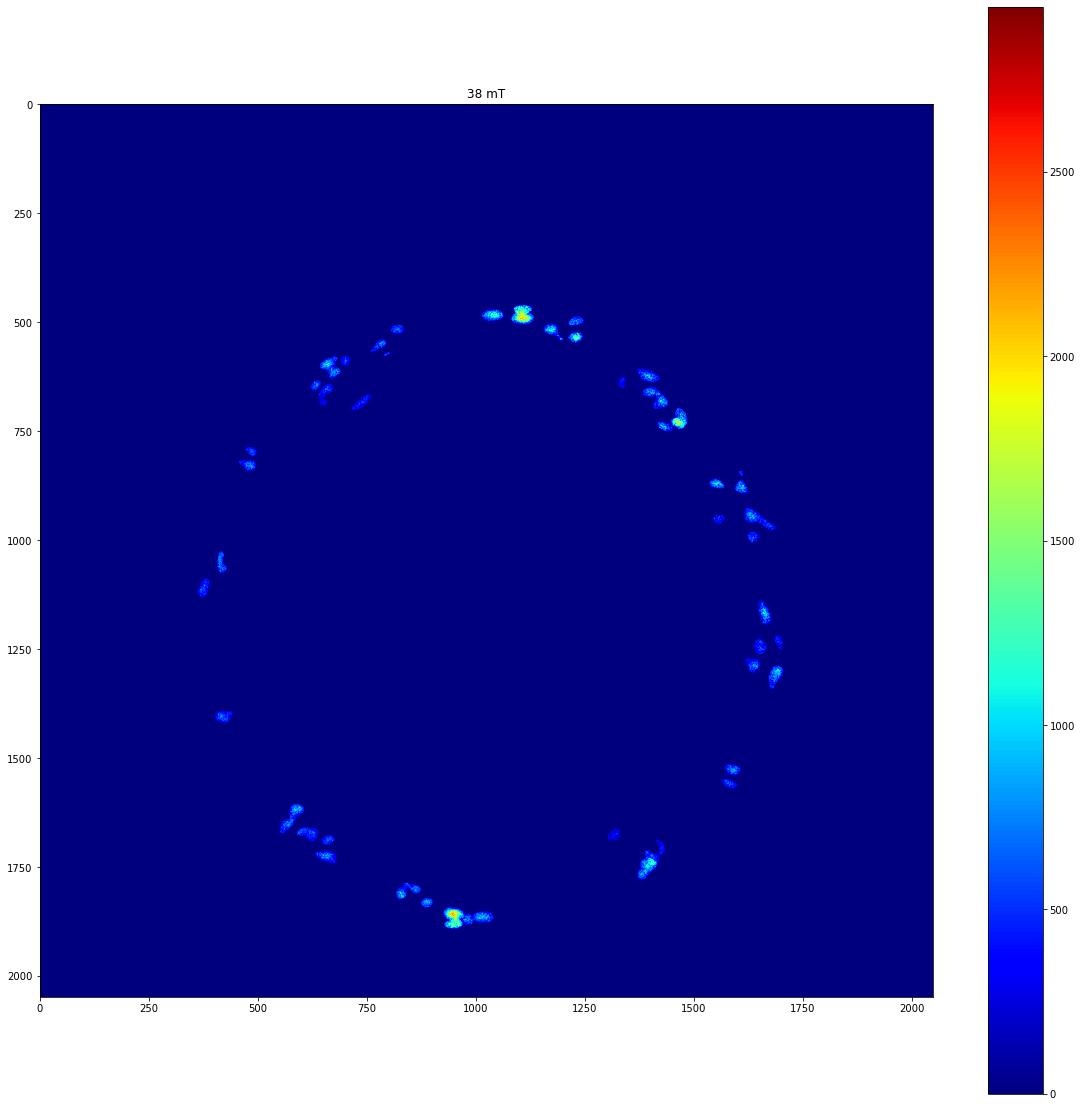

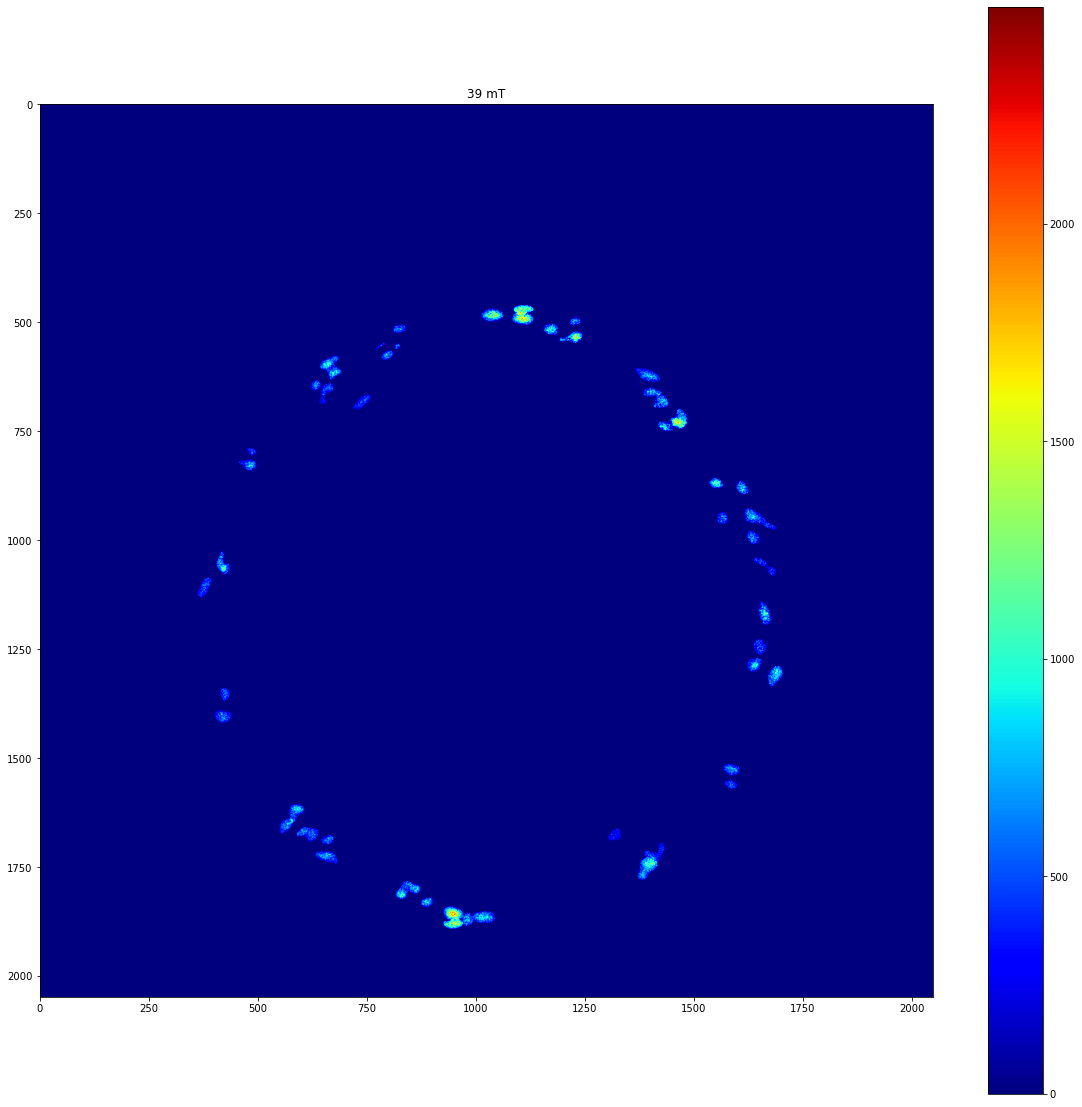

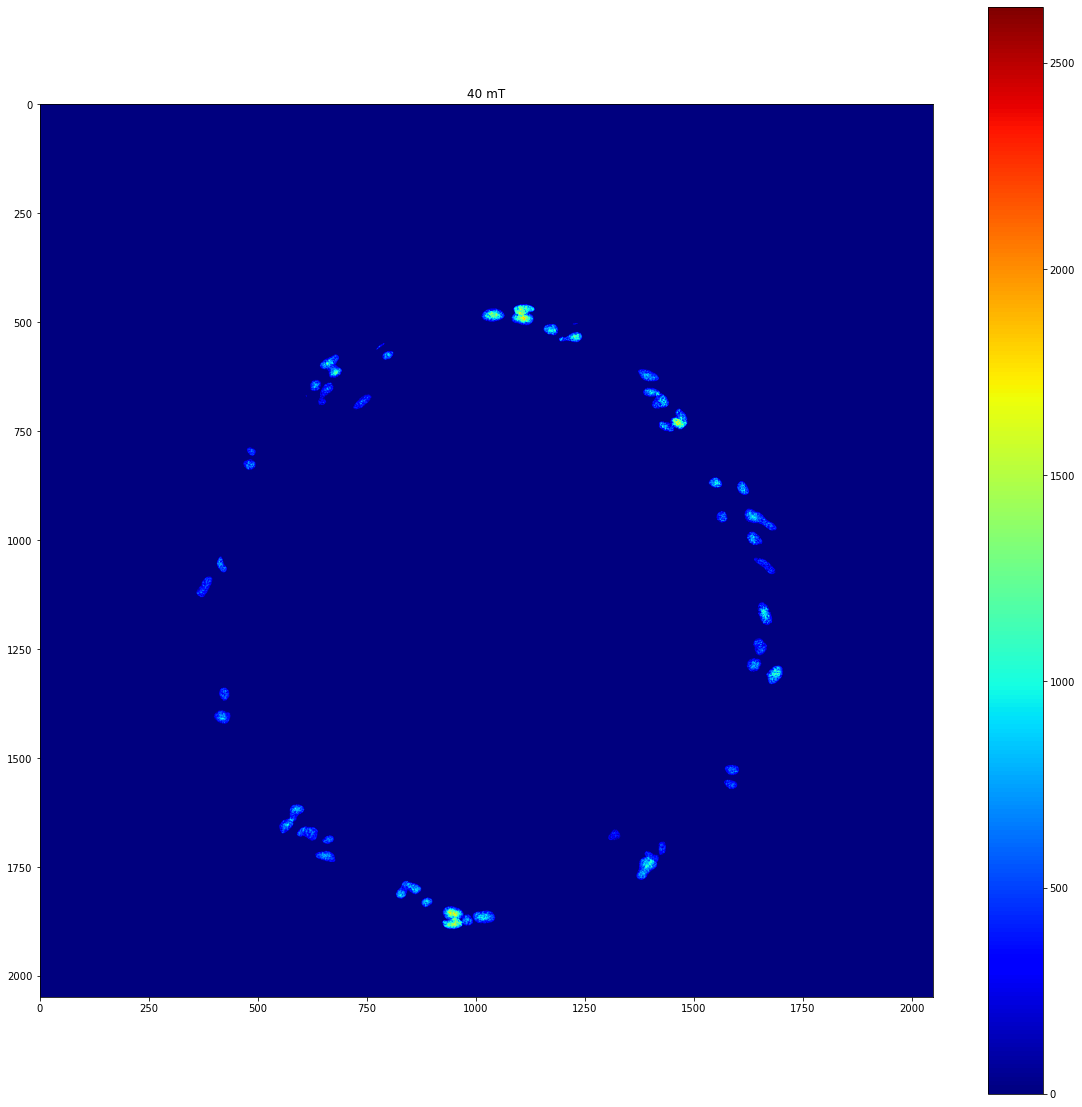

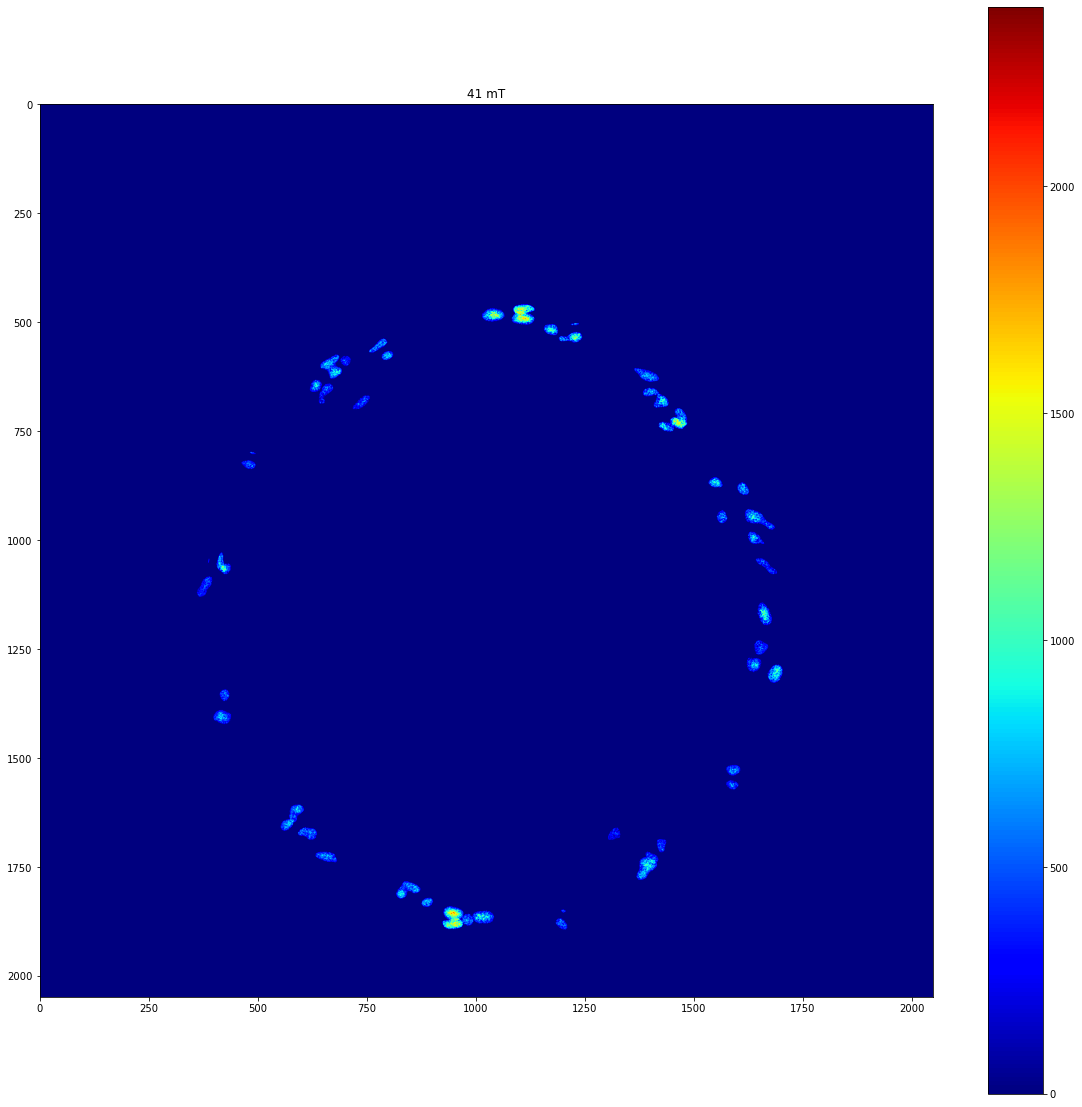

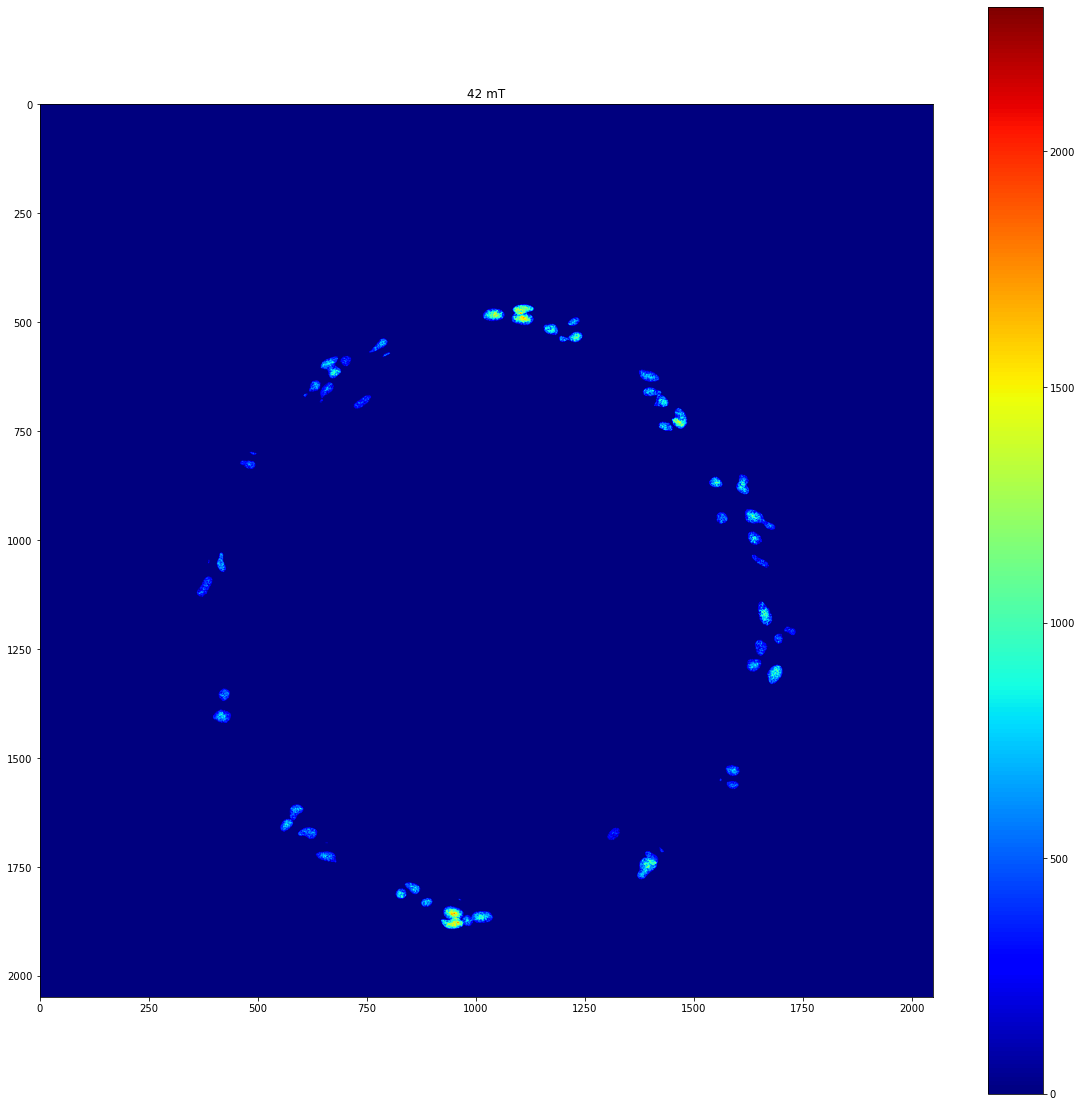

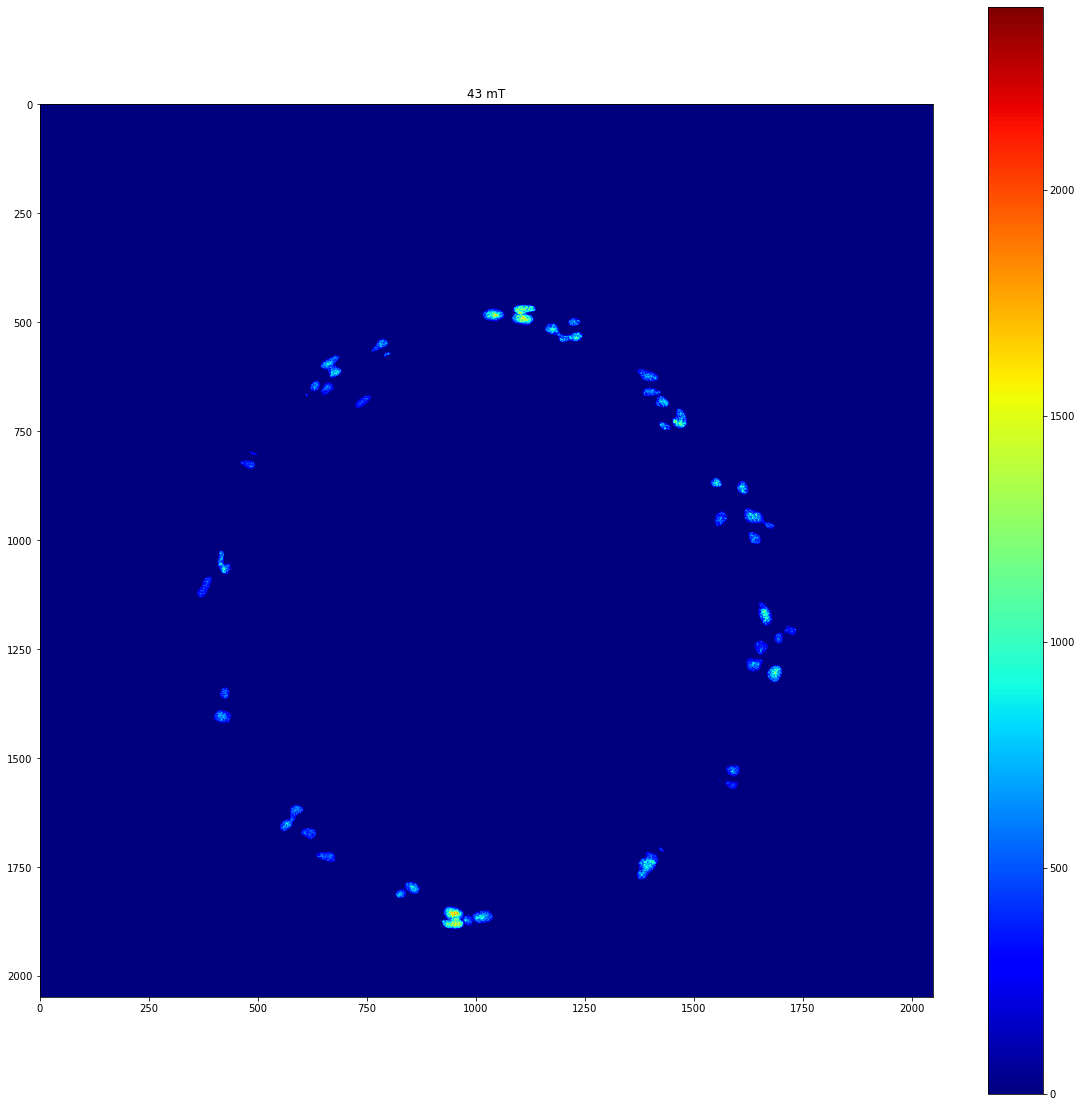

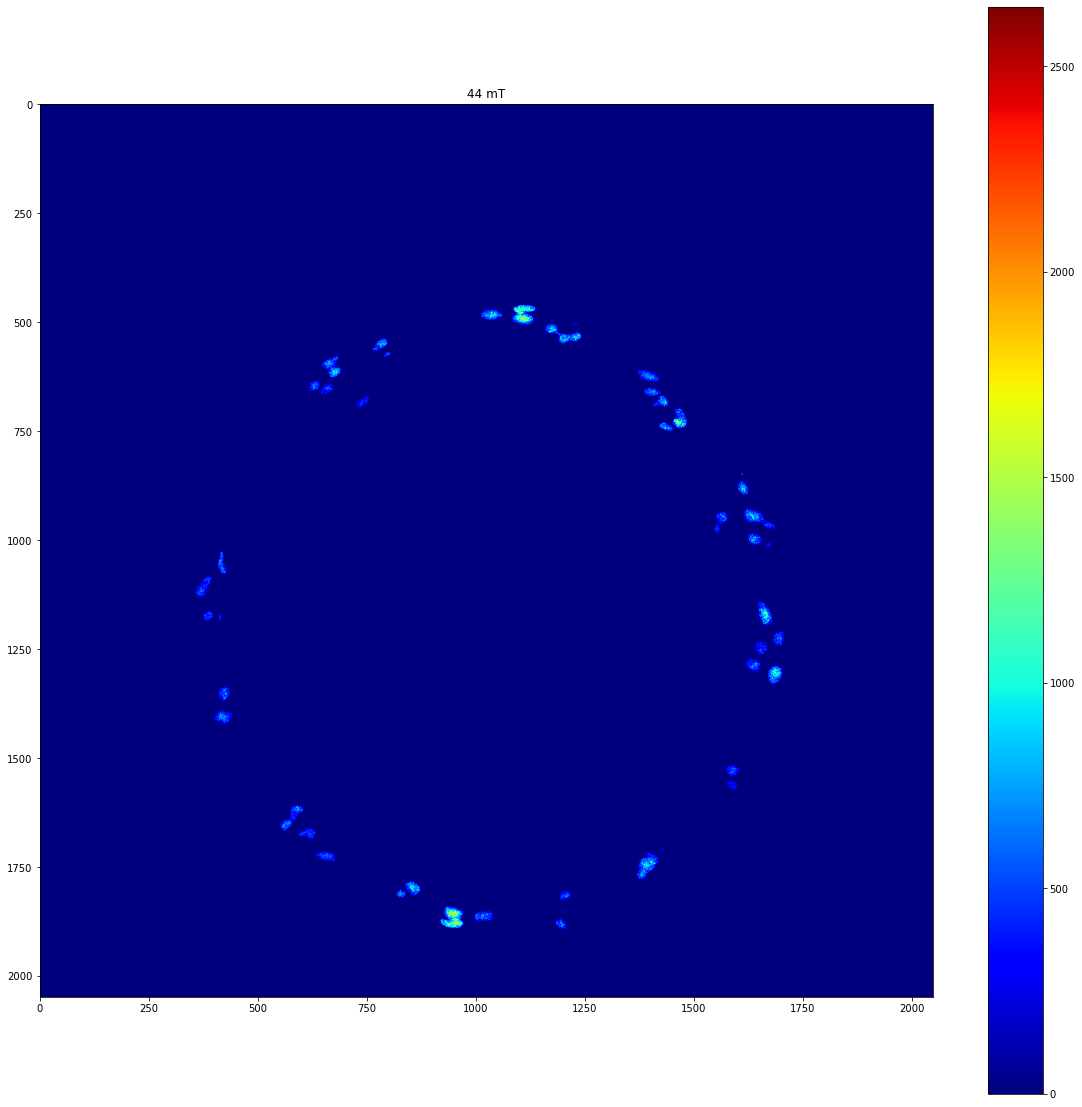

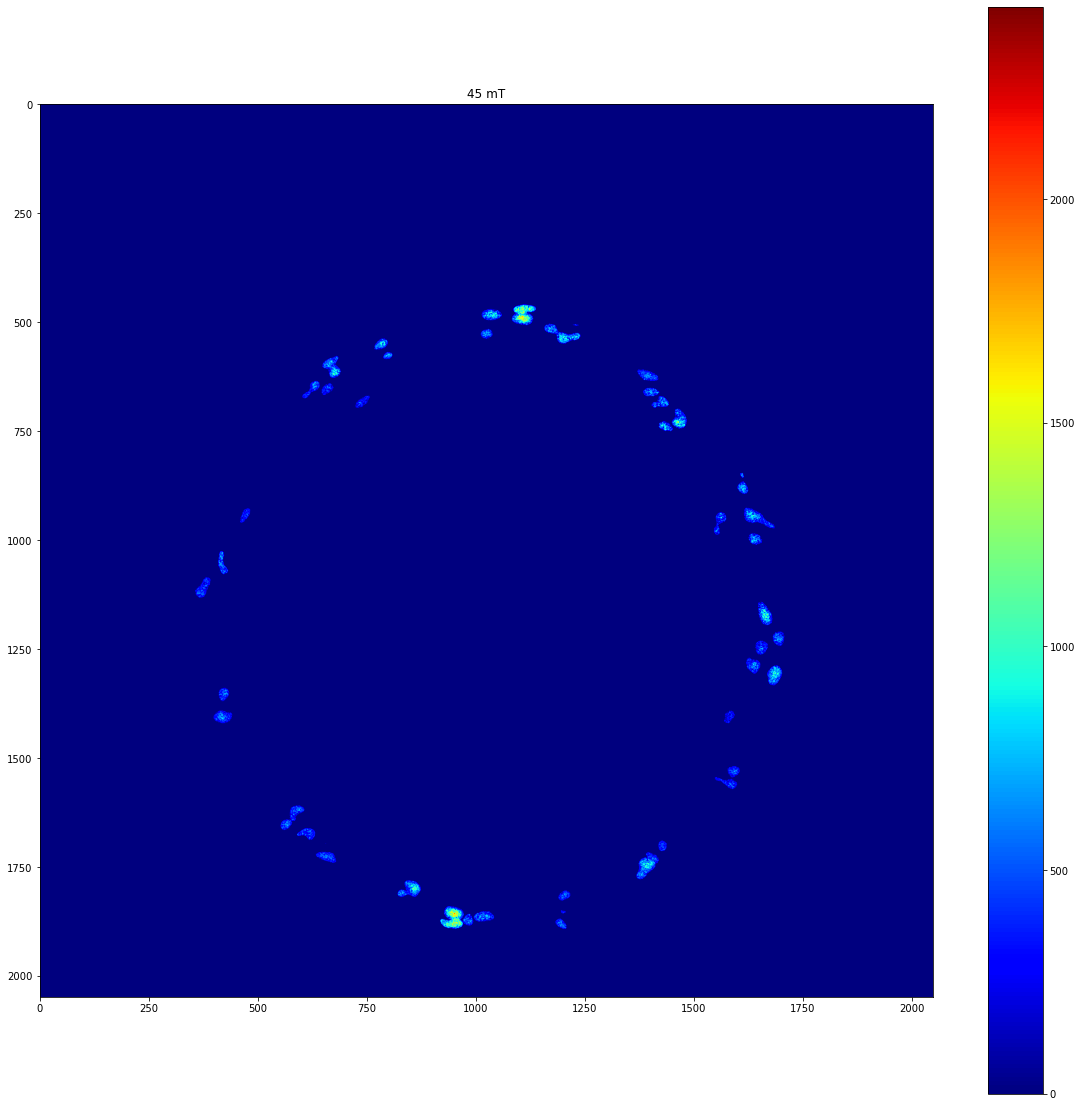

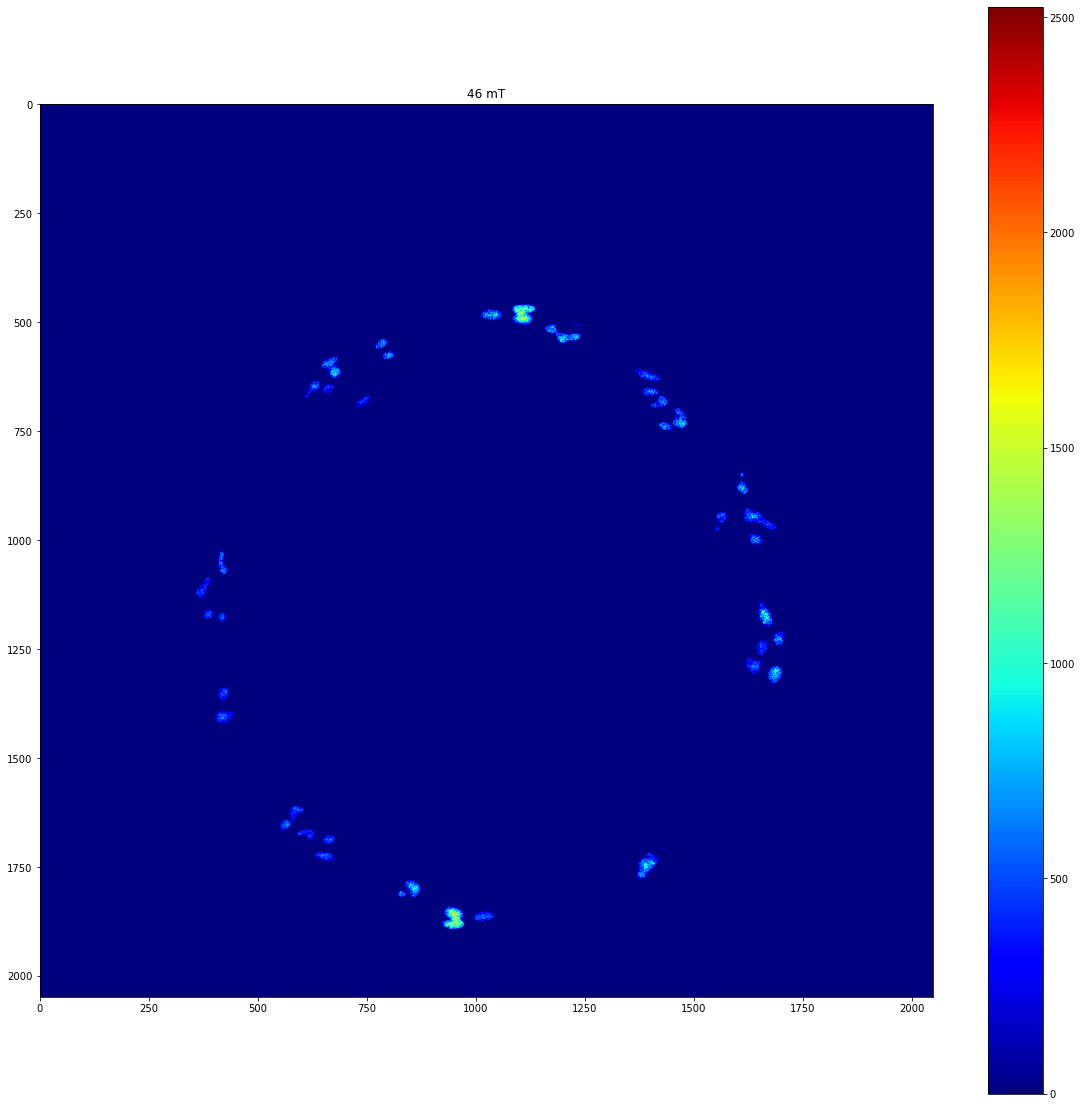

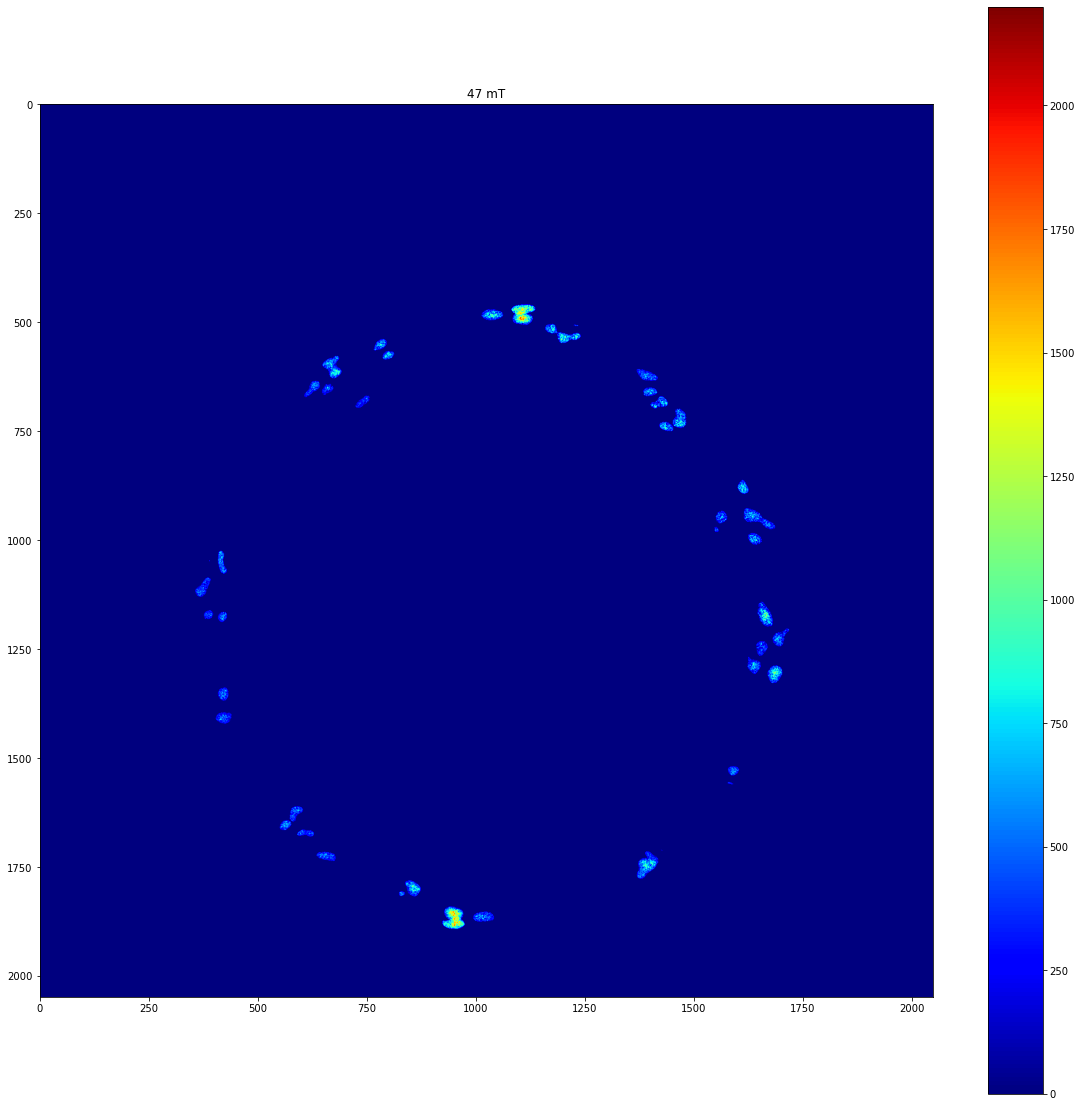

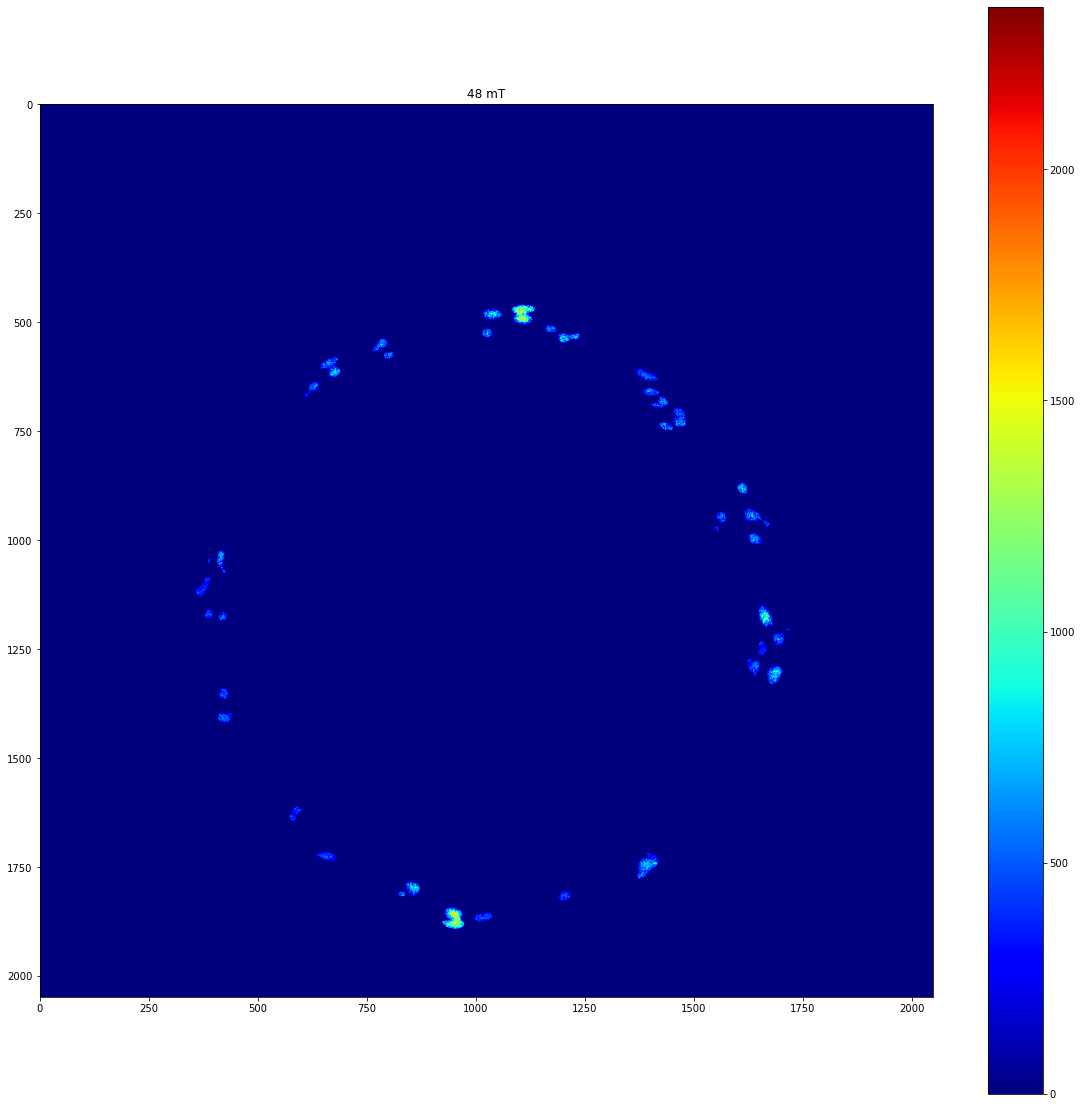

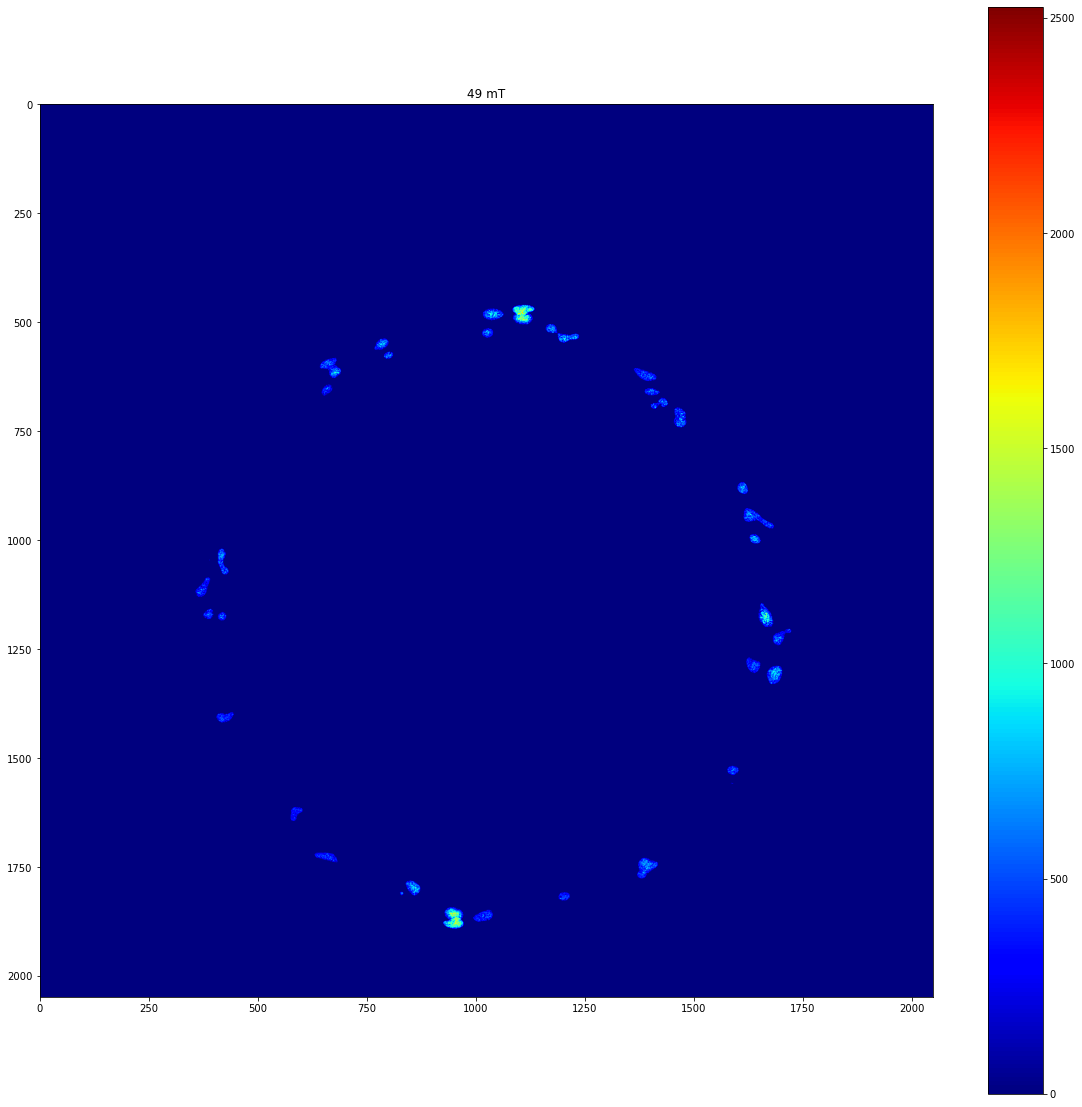

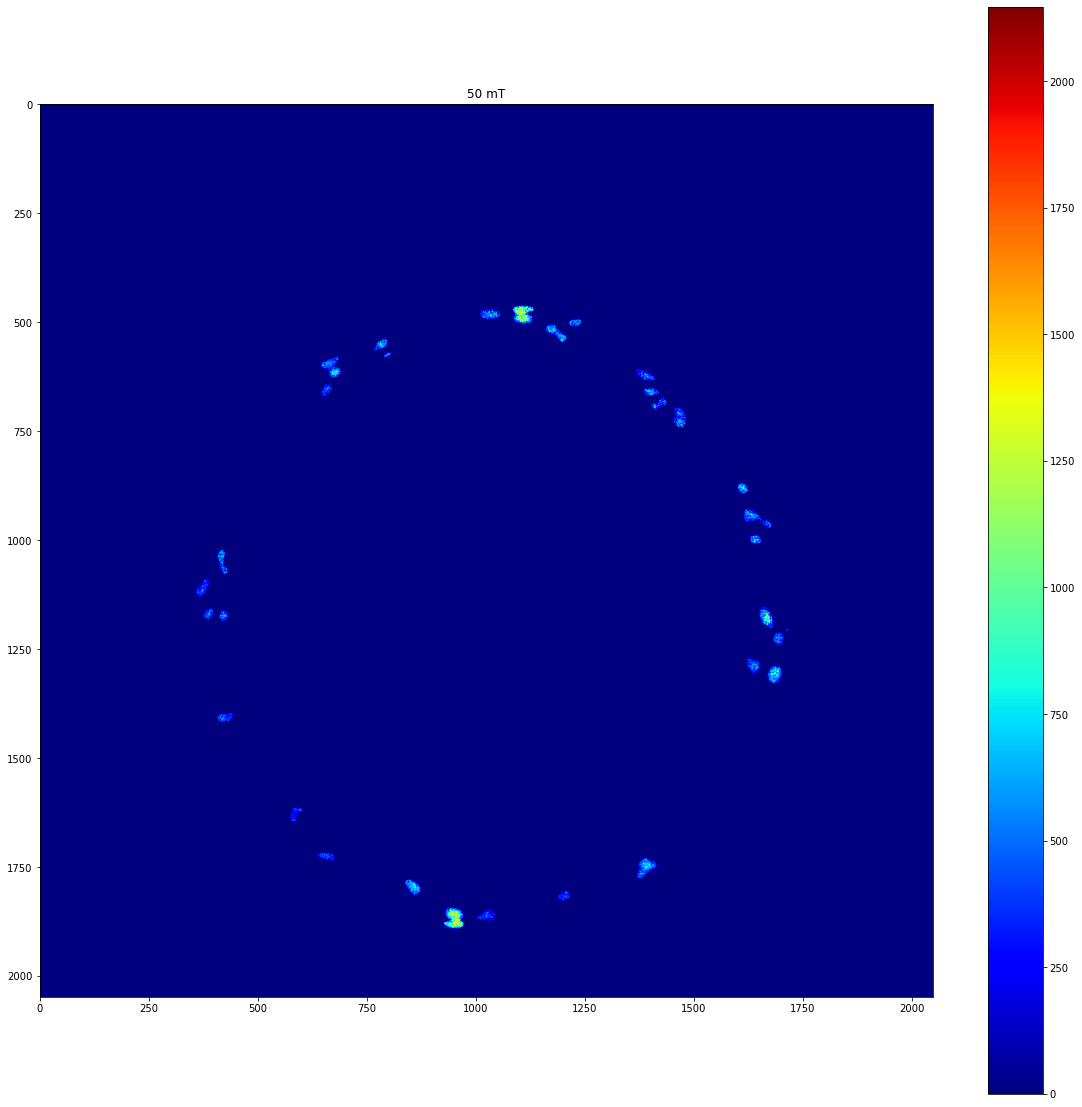

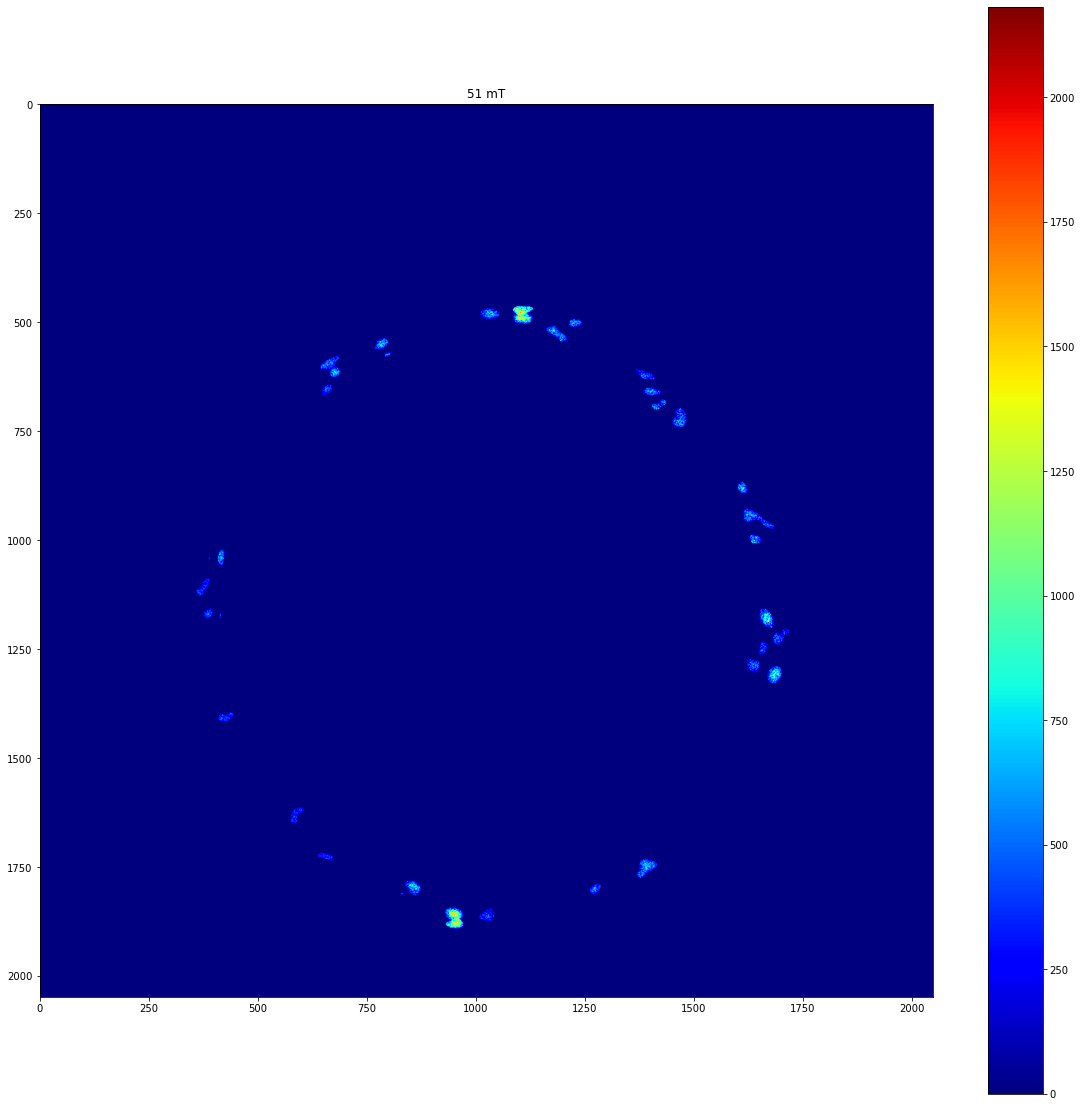

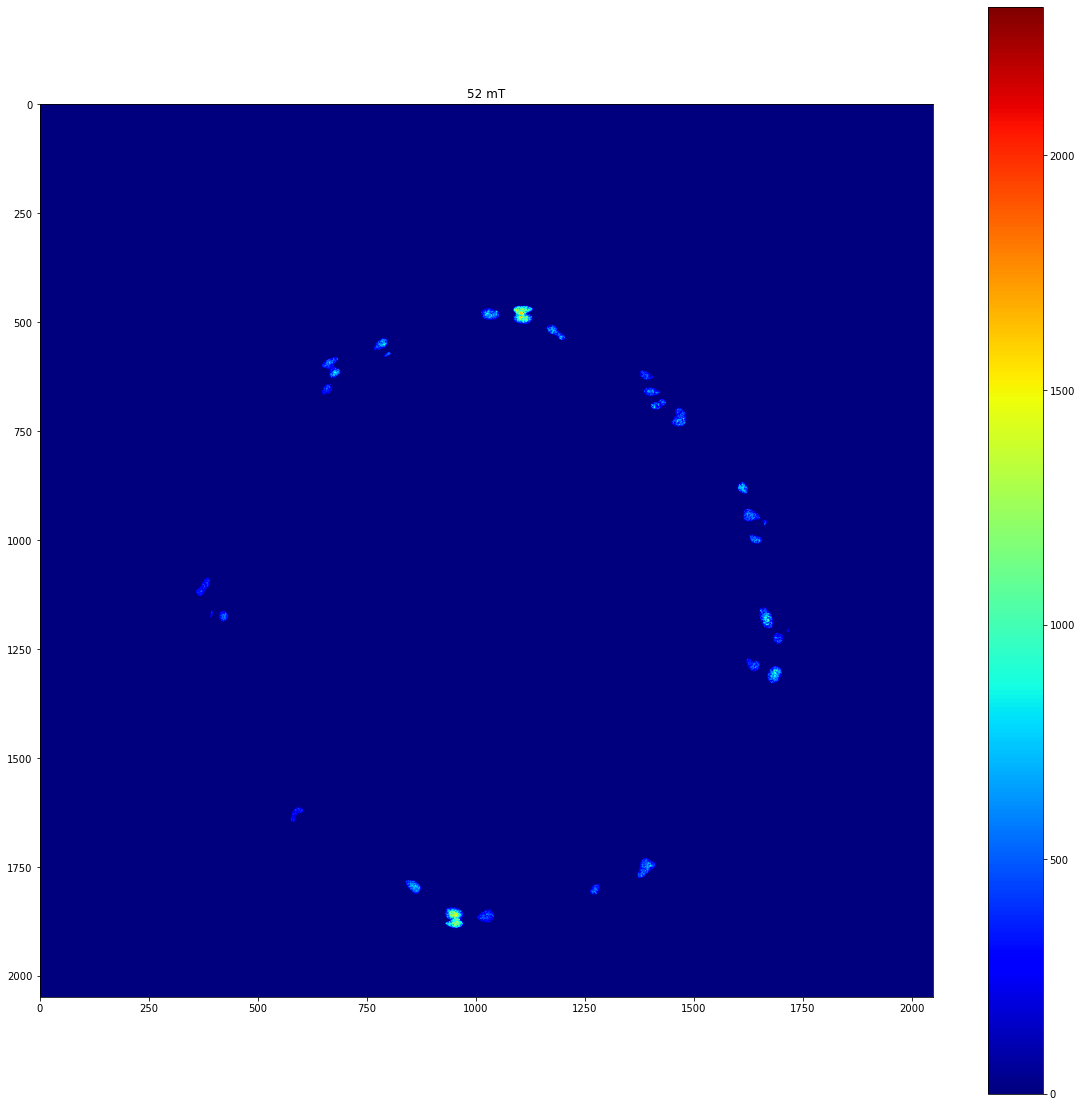

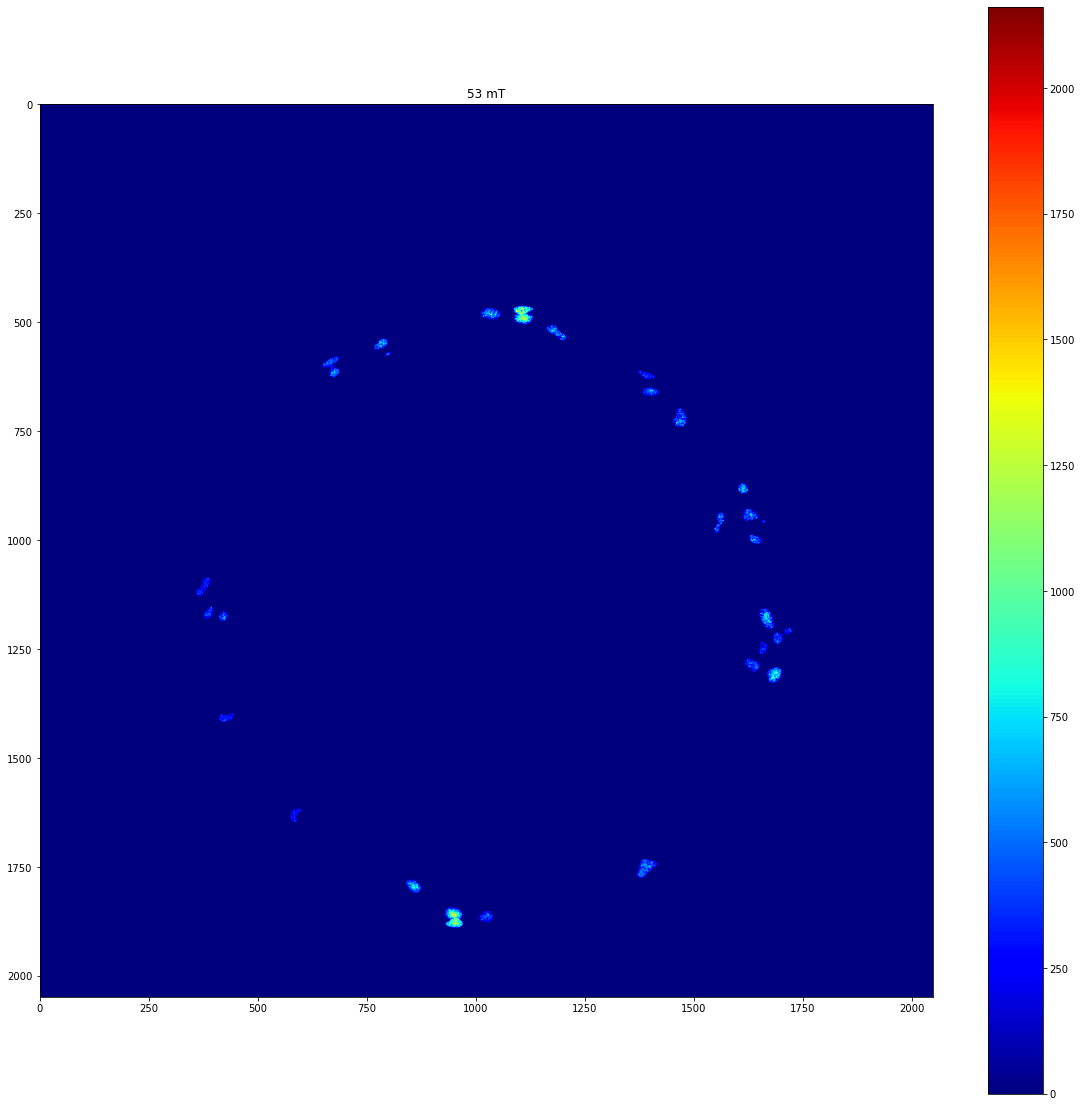

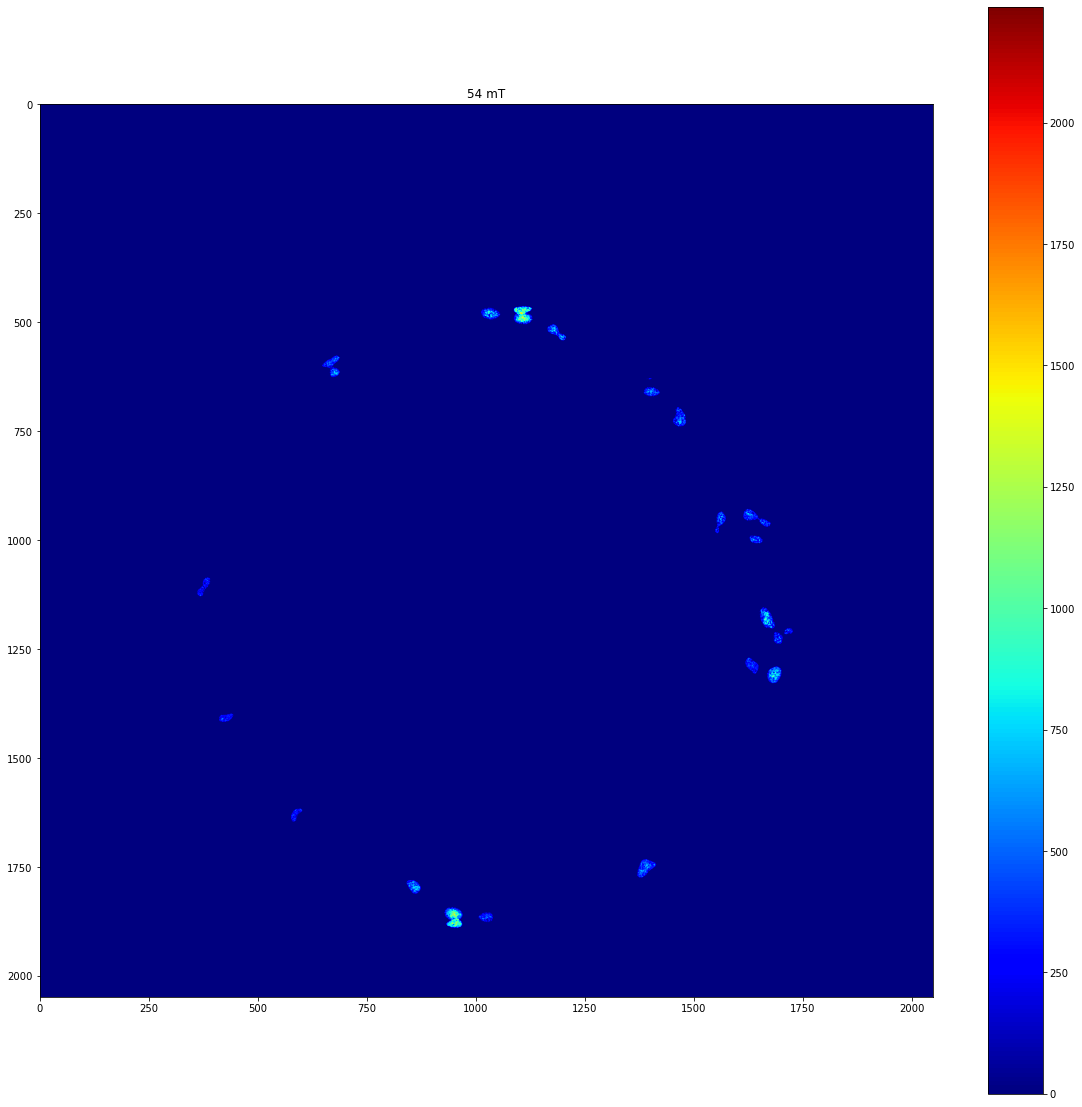

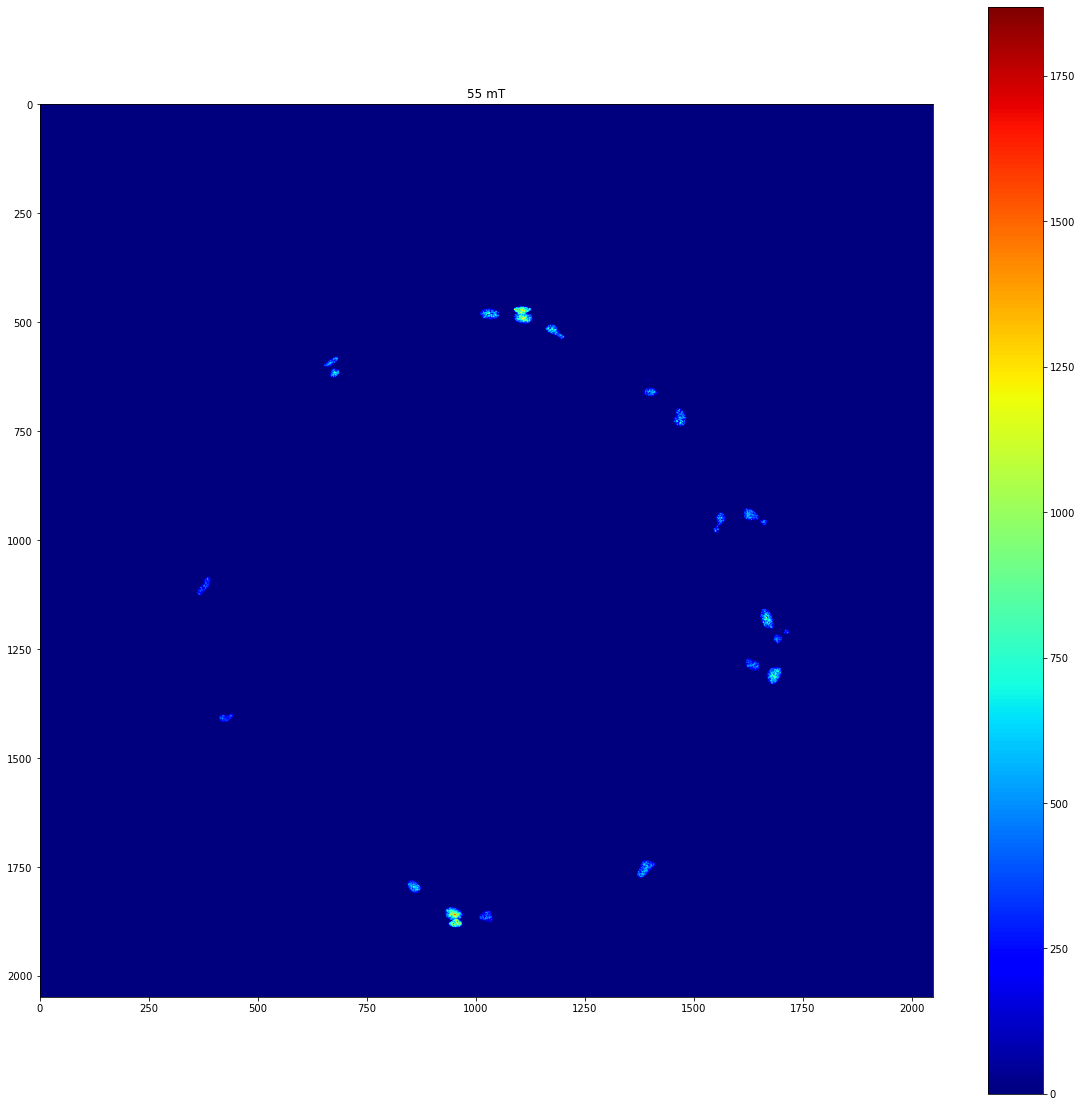

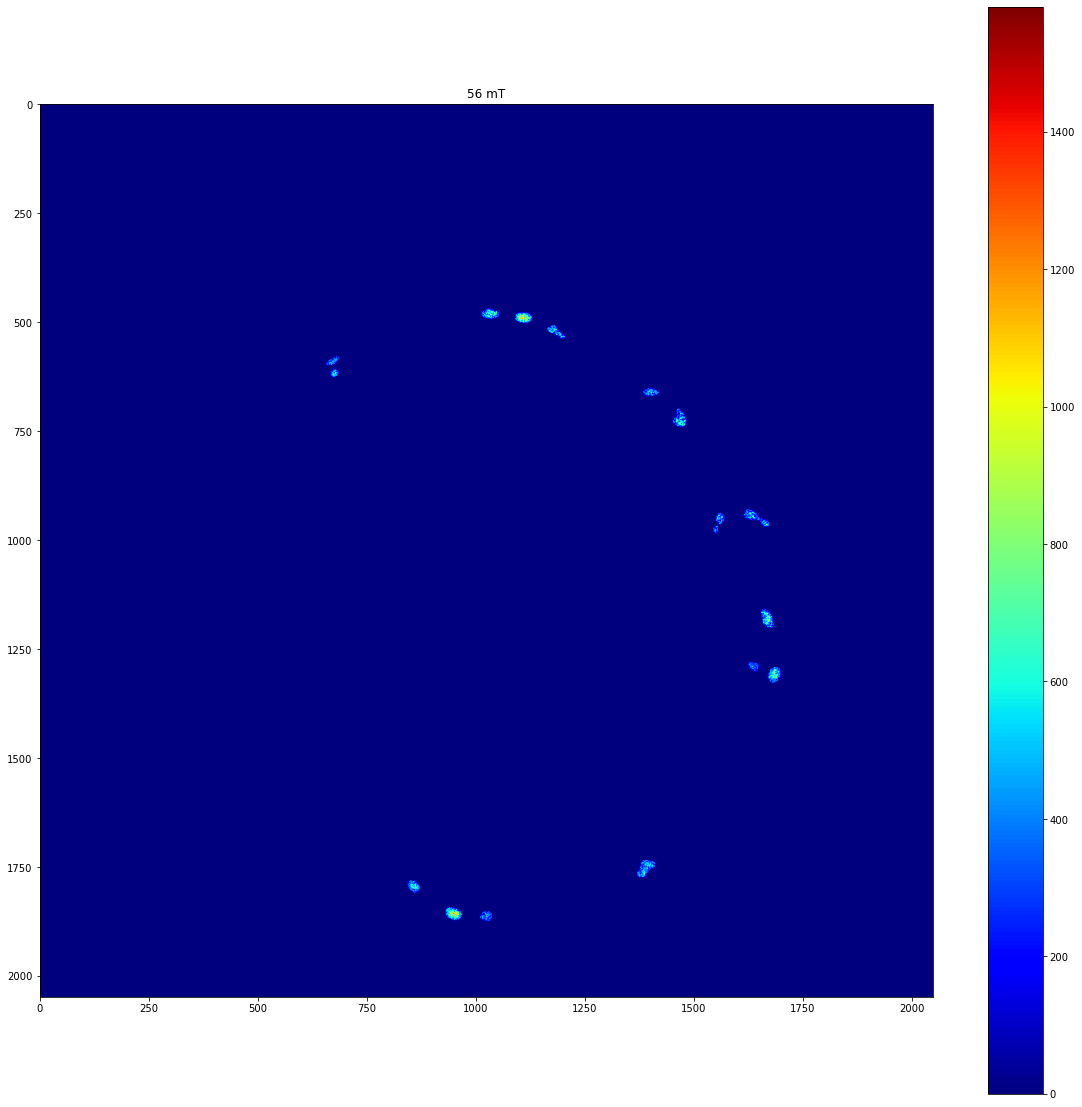

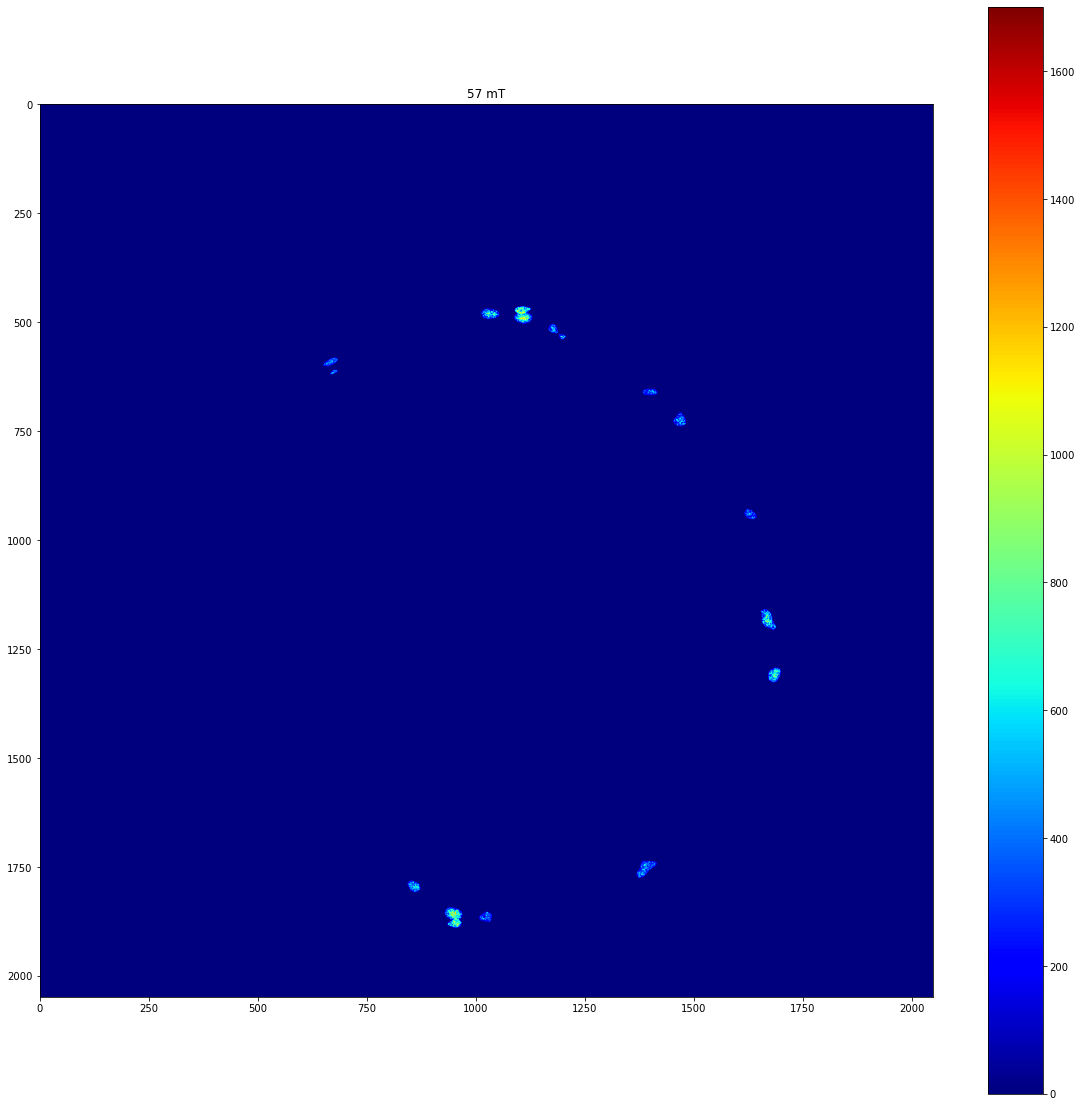

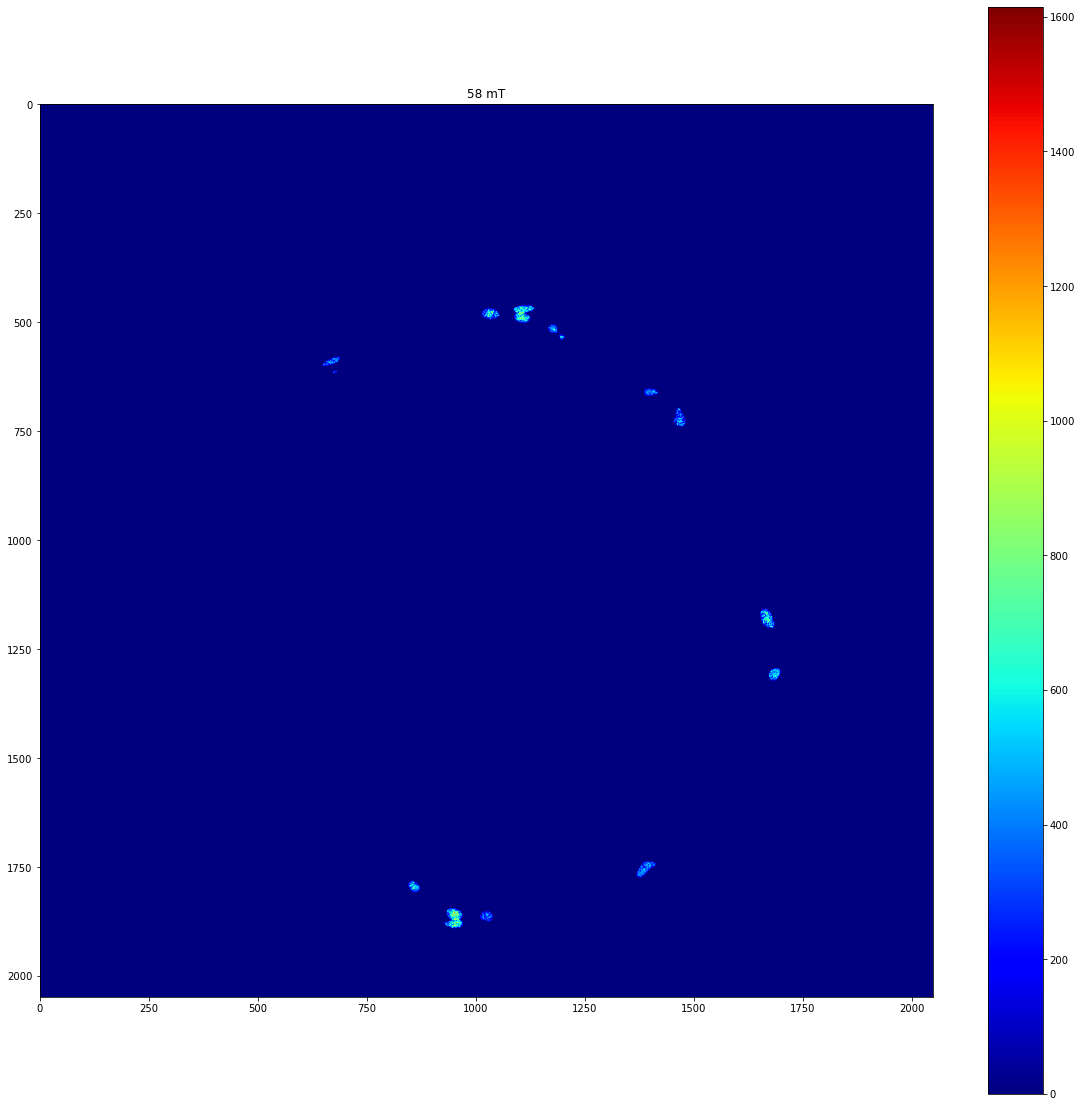

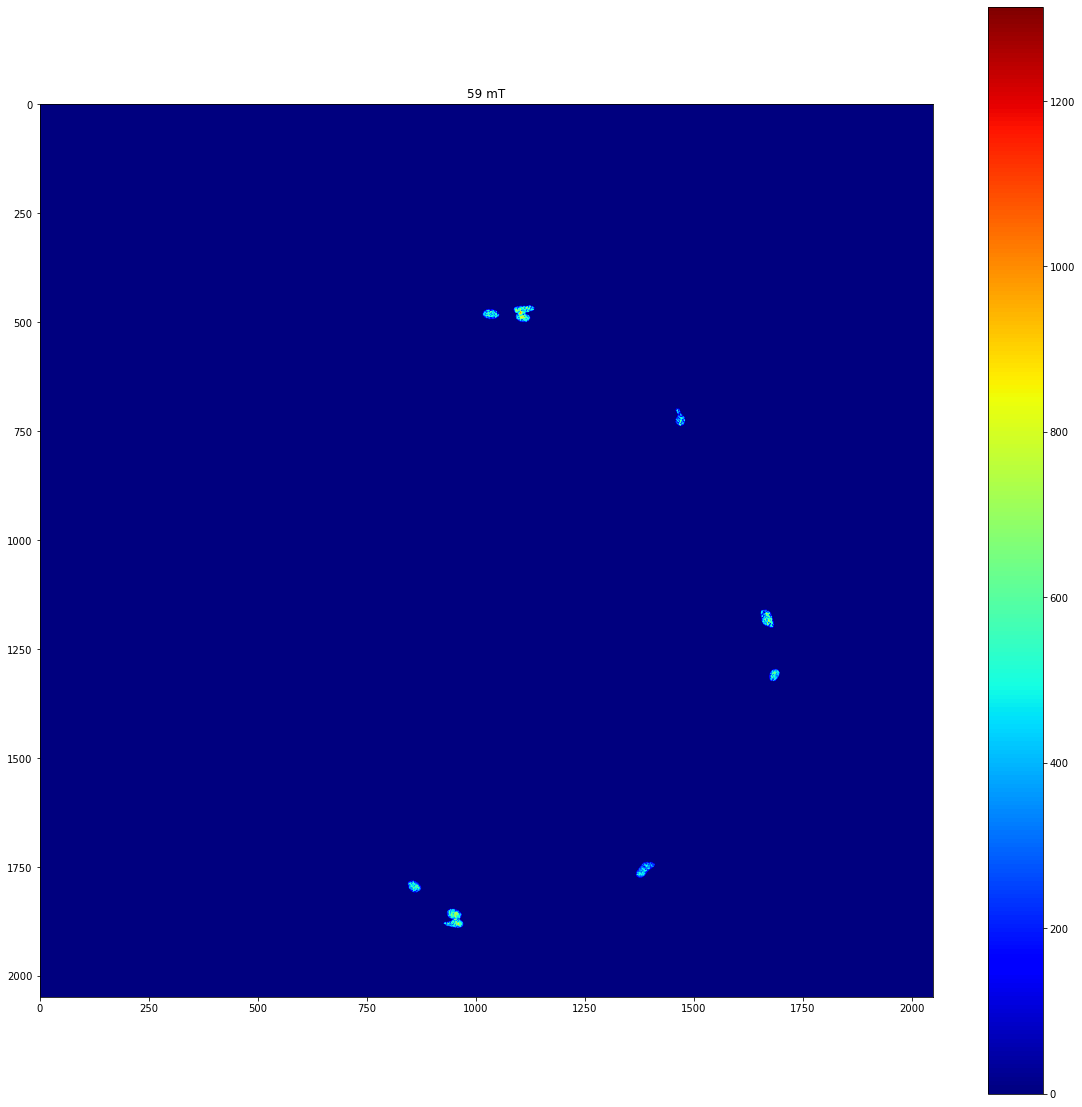

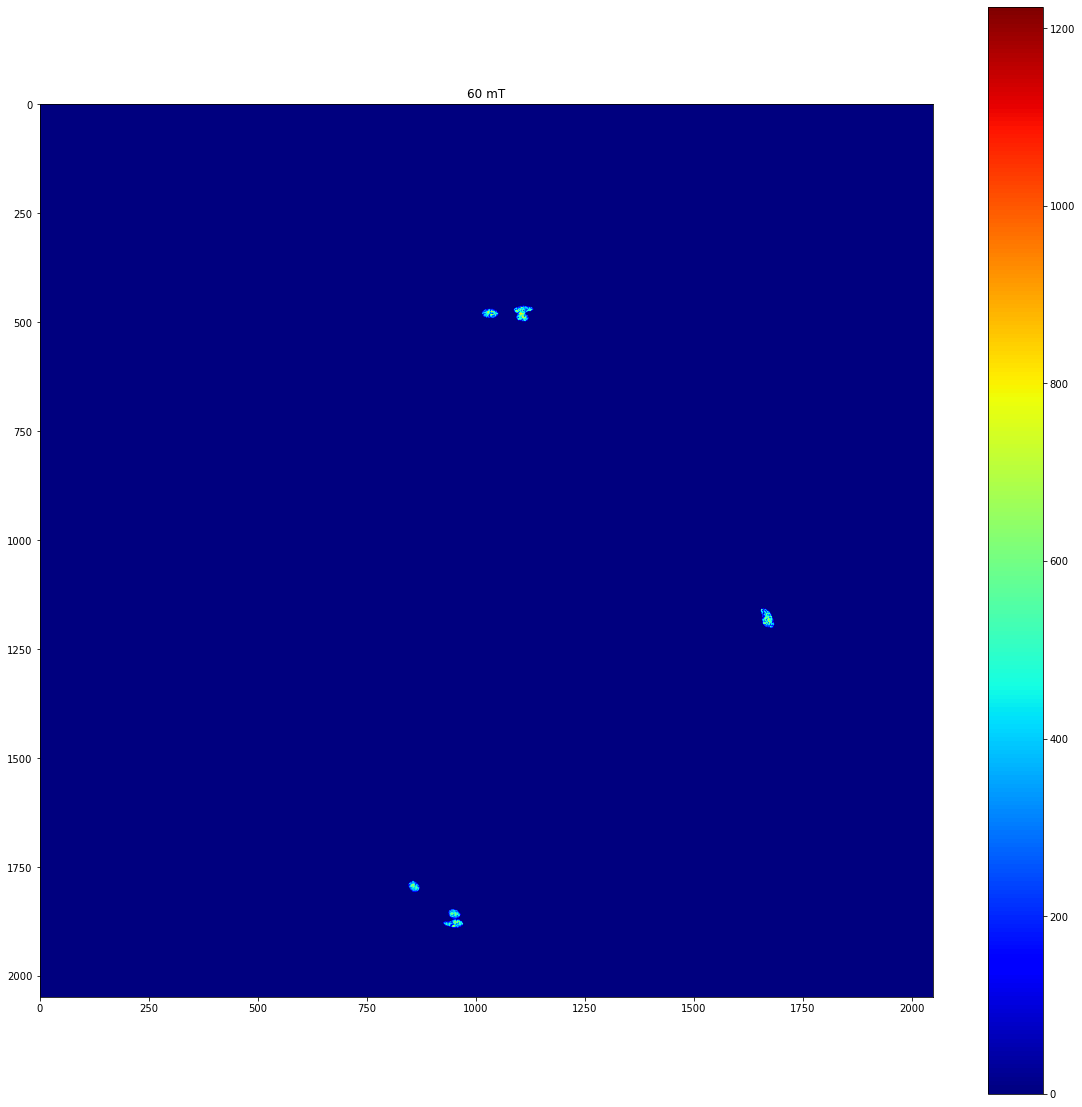

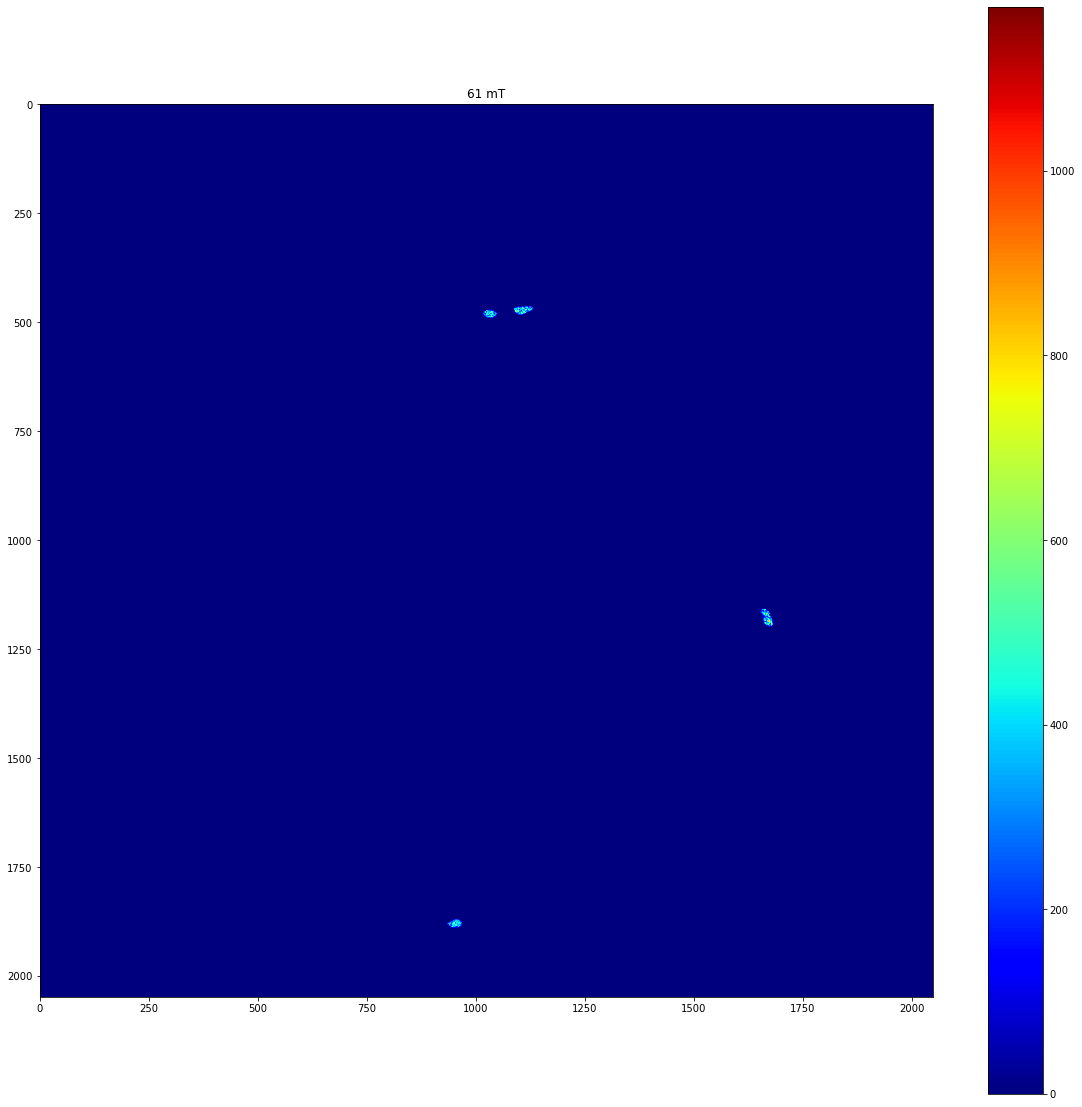

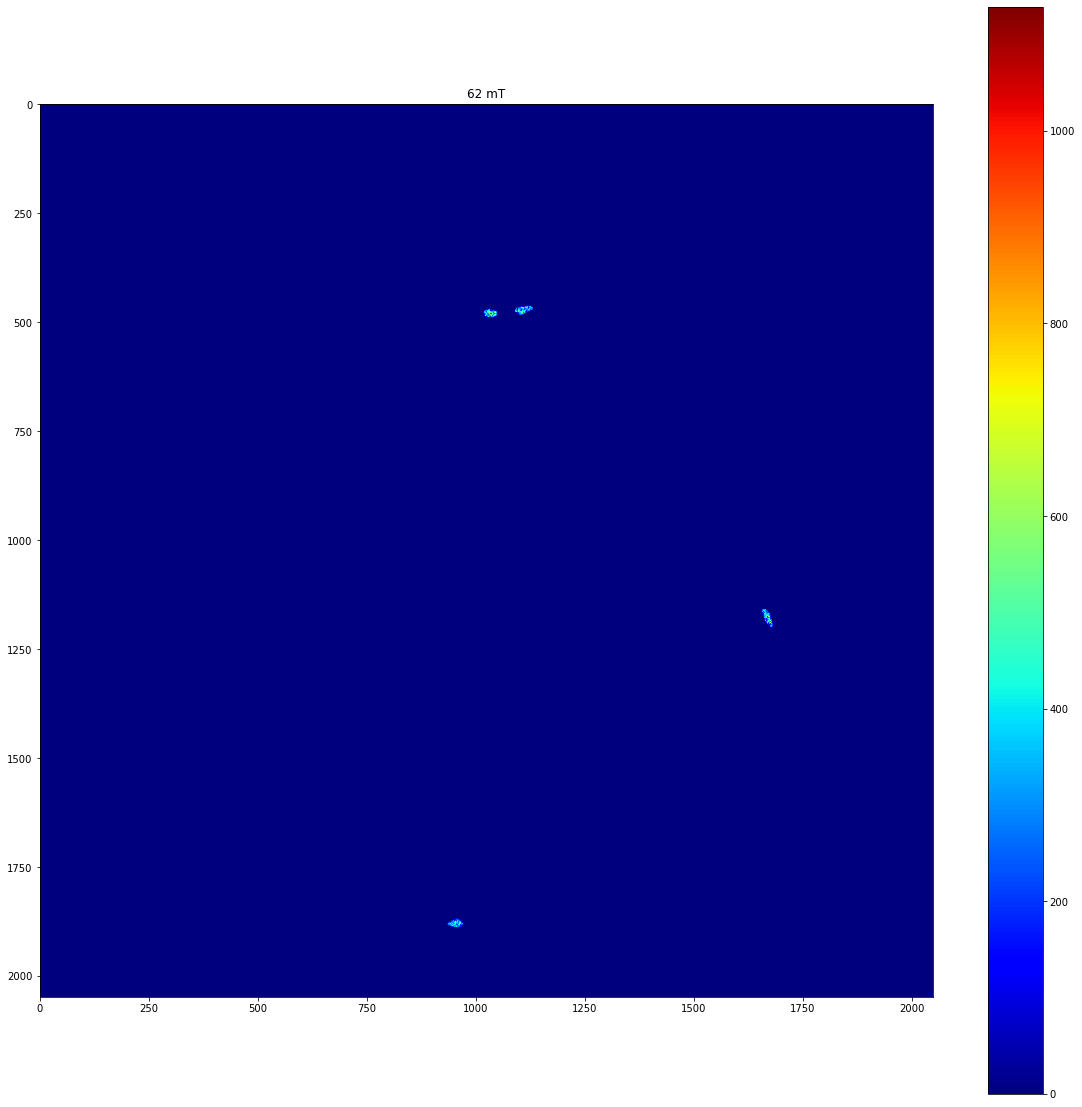

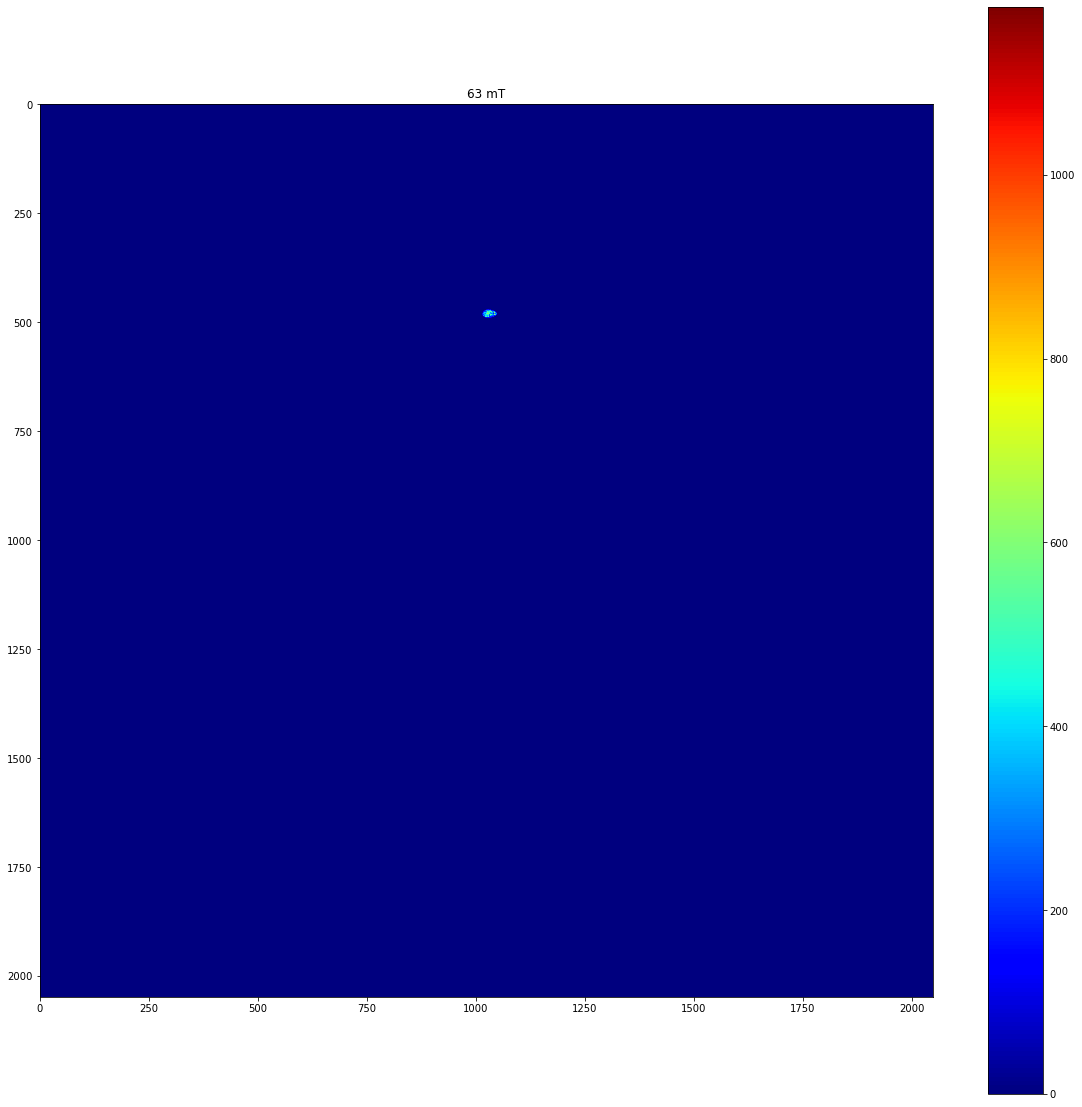

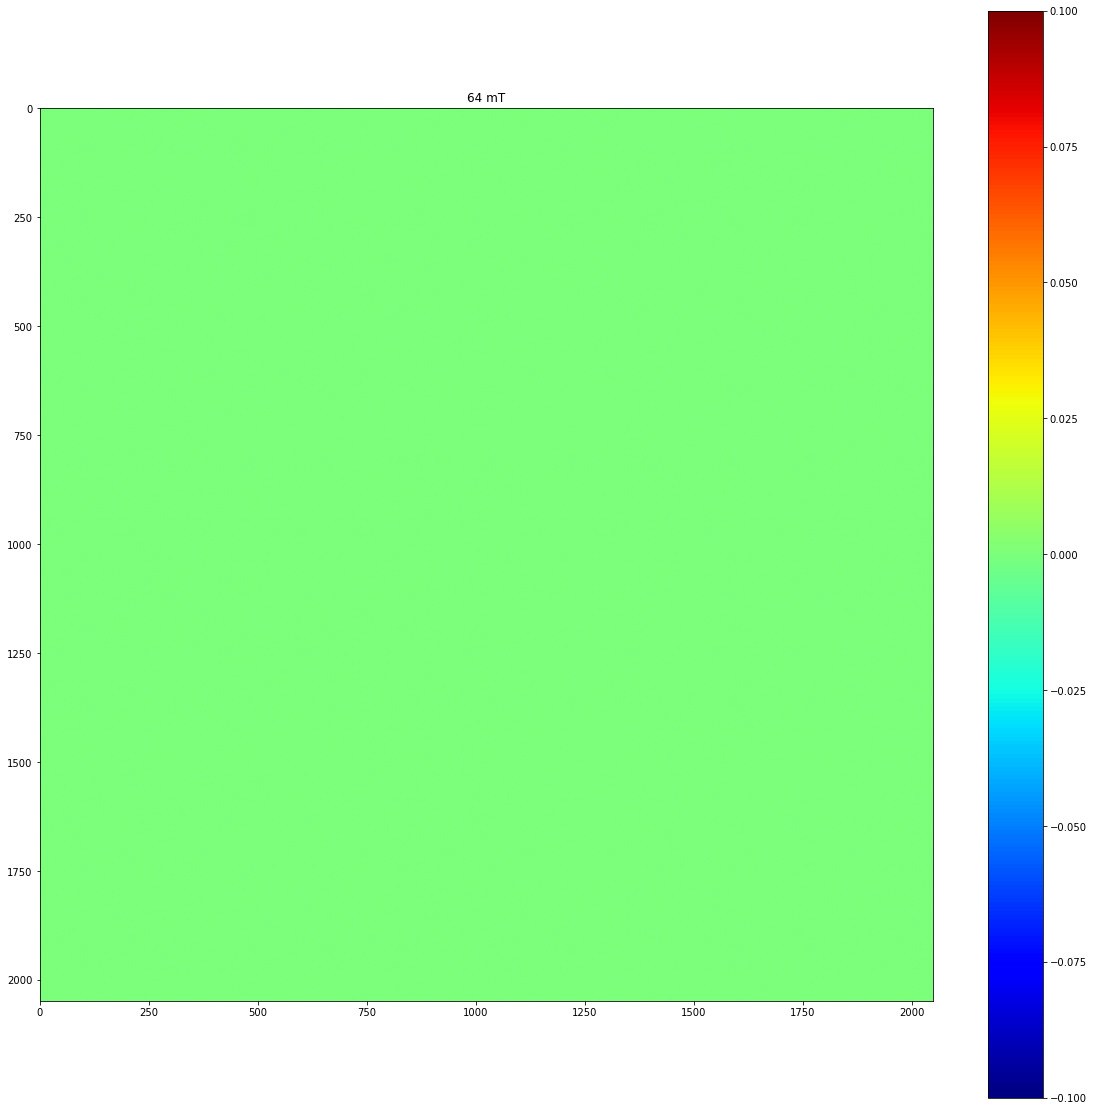

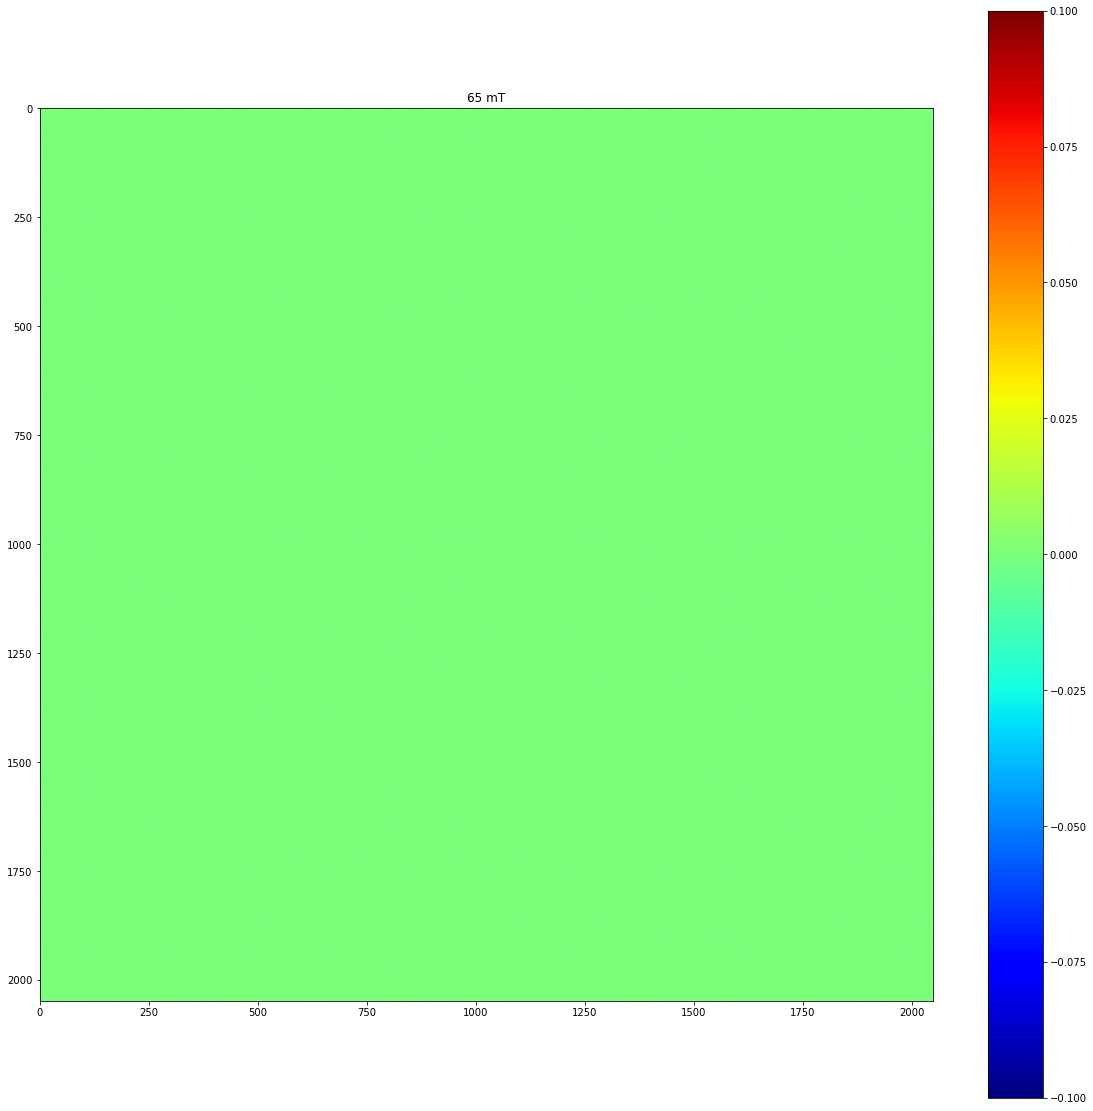

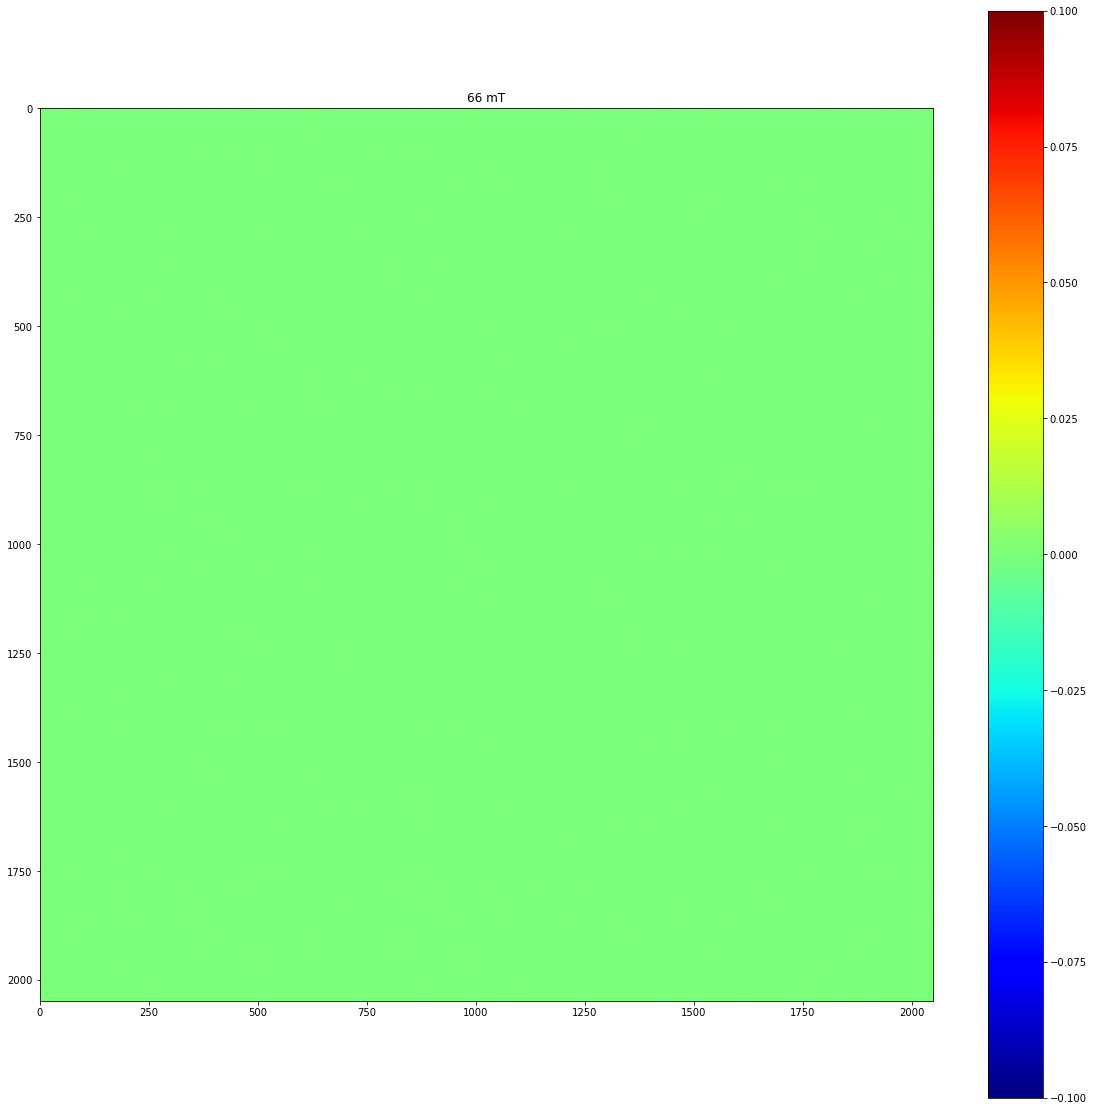

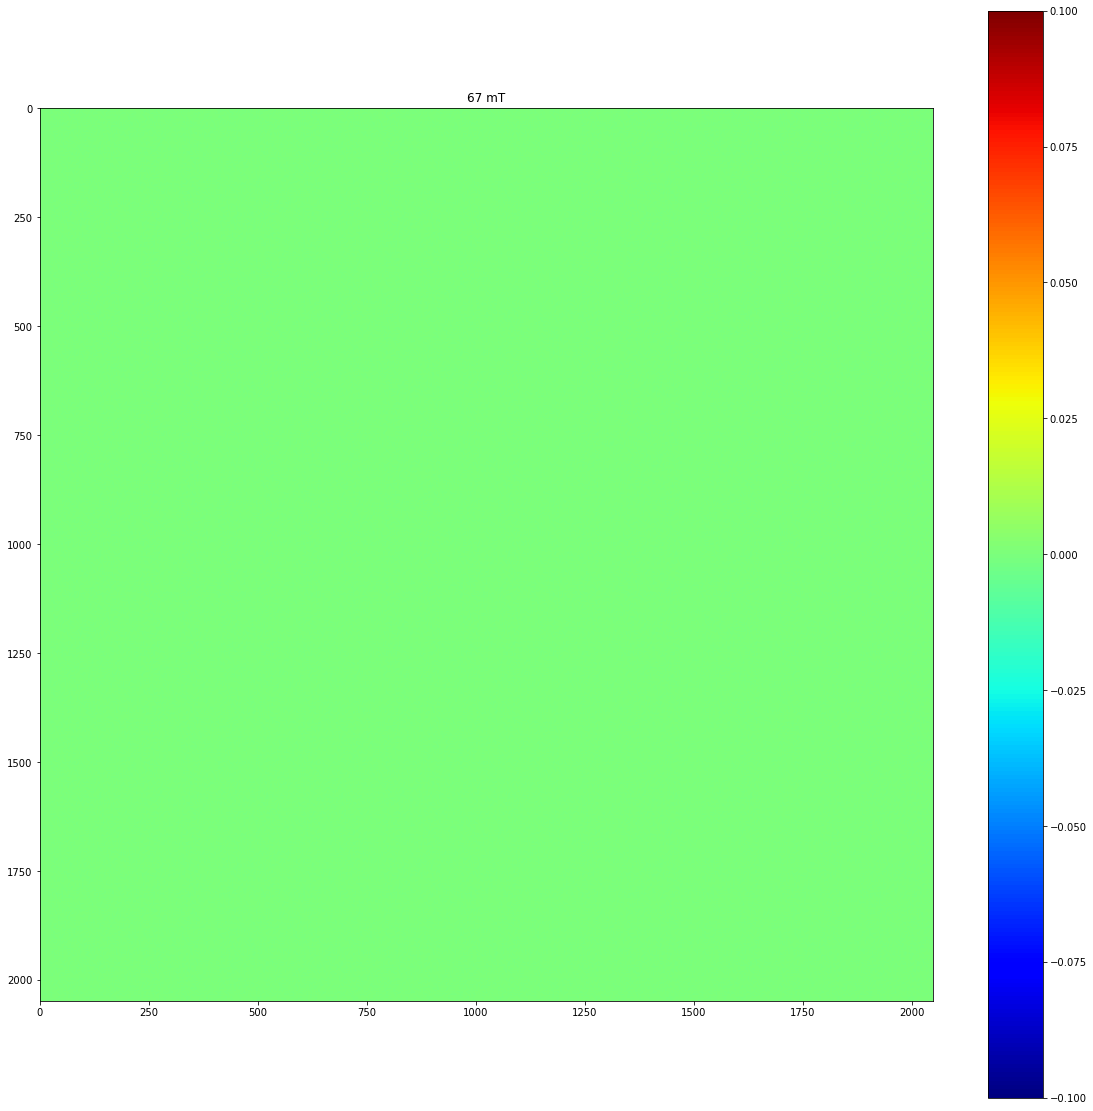

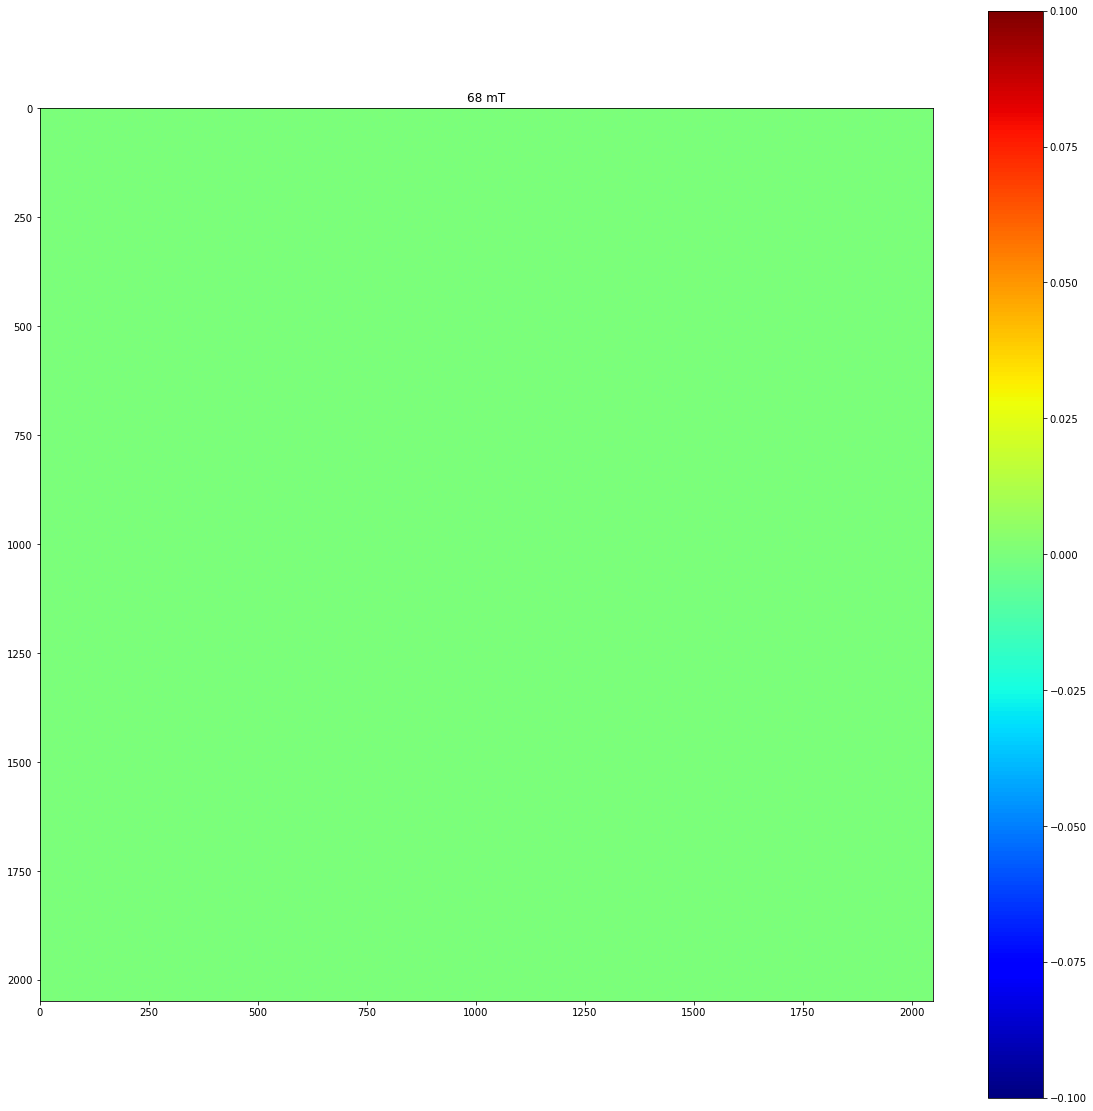

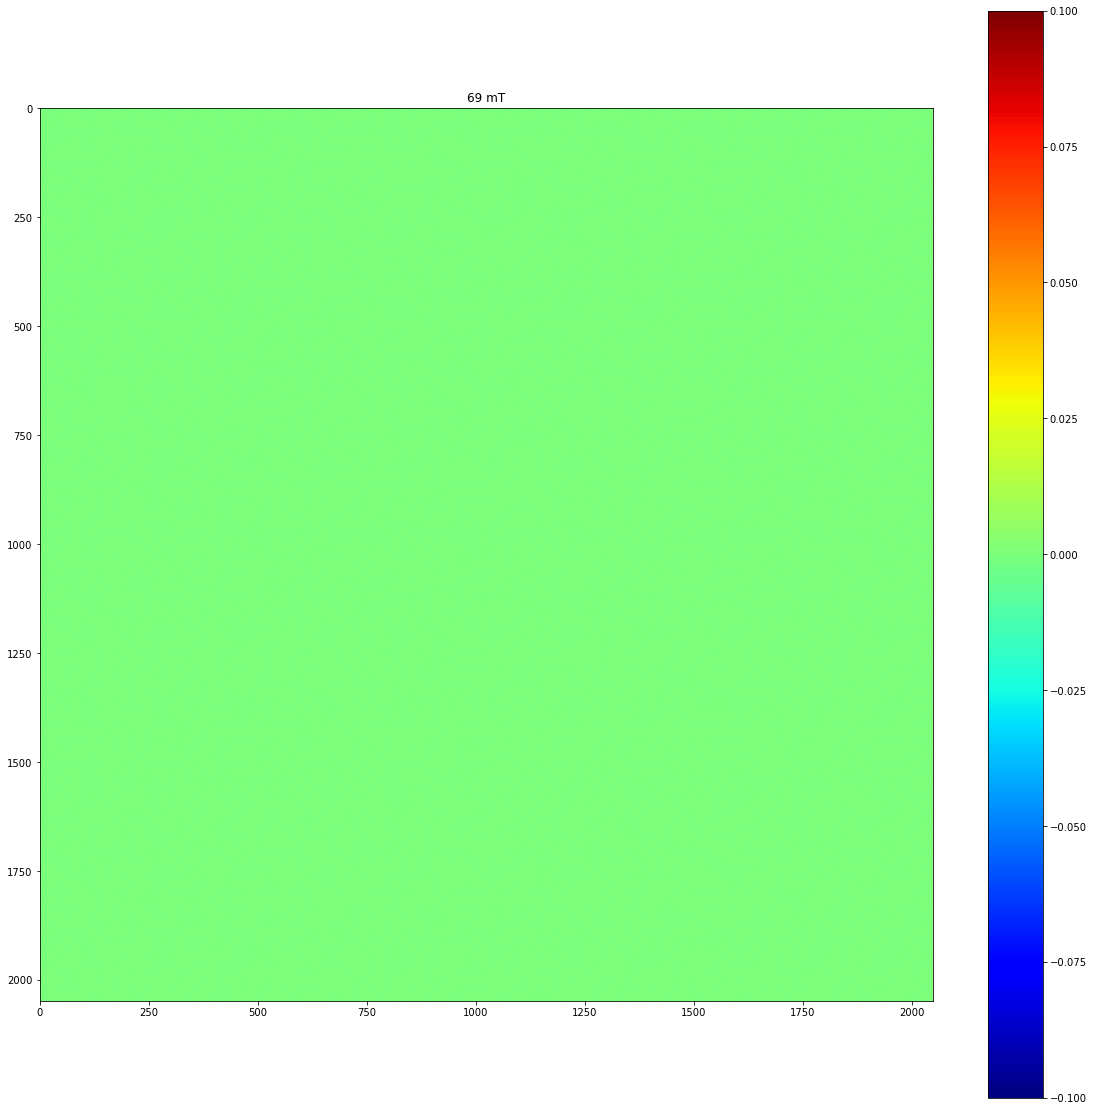

In [14]:
"""
Display the results.
"""
importlib.reload(utils)

for field in range(70):
    utils.imshow(bkg_in_clusters_per_field_20K[field], title=f"{field} mT")


In [6]:
# Save this data.
for field in range(70):
    np.save(f"20K_bkg_in_clusters_at_{field}mT", 
            bkg_in_clusters_per_field_20K[field])


In [16]:
"""
Plot wavelength vs field.
"""
# Run some azimuthal integrations on the data.
import pyFAI

# Initialize the integrator.
fai = pyFAI.load(utils.PONI_PATH)

def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, np.sqrt(variance))


azimuthal_integrals = []
k_vectors = []
k_vector_errors = []
relative_errors = []

for field in range(56):
    shift = 4000 * field
    azimuthal_integrals.append(
        fai.integrate1d(bkg_in_clusters_per_field_20K[field], 1000))
    mean, stddev = weighted_avg_and_std(
        azimuthal_integrals[field][0], azimuthal_integrals[field][1])
    k_vectors.append(mean)
    k_vector_errors.append(stddev)
    relative_errors.append(k_vector_errors[field]/k_vectors[field])
# plt.plot(k_vectors)


<ErrorbarContainer object of 3 artists>

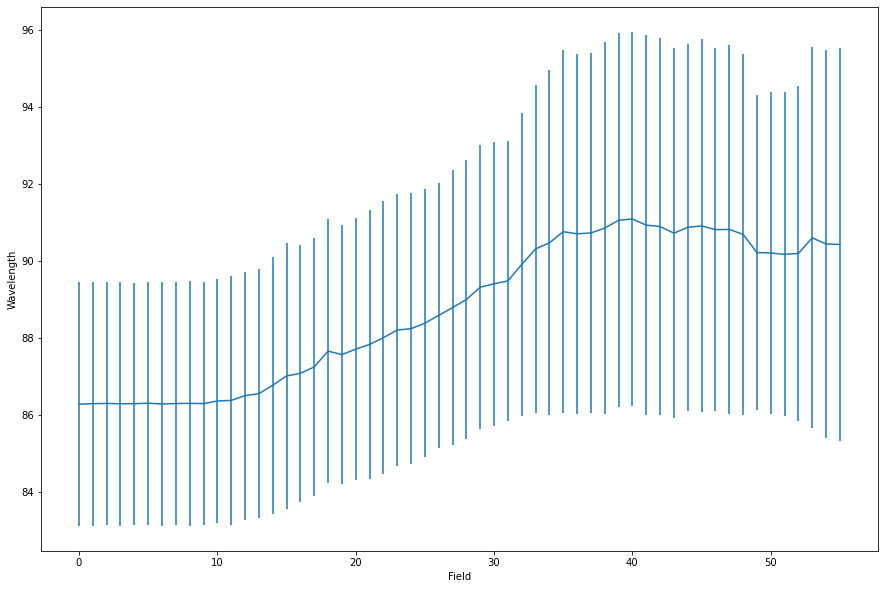

In [17]:
"""
Plot it.
"""

import matplotlib.pyplot as plt

wavelengths = 2*np.pi/np.array(k_vectors)

plt.figure(figsize=(15, 10))
plt.xlabel("Field")
plt.ylabel("Wavelength")
plt.errorbar(range(56), wavelengths, yerr=np.array(
    relative_errors)*wavelengths)
